# Esame Data Science - a.a. 2022/2023

Di seguitono sono proposti gli esercizi per la prova d'esame.
Per presentarsi all'esame è necessario aver implementato una soluzione per tutti i punti elencati.

1. [Analisi descrittiva](#esercizio1)
2. [Classificazione](#esercizio2)
3. [Rete neurale custom](#esercizio3)

In [1]:
#@markdown # Import delle librerie
%%capture

# Utility
import pandas as pd
import numpy as np
import itertools

# Statistic
from scipy.stats import chi2_contingency

# Processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import recall_score, auc, confusion_matrix, accuracy_score, roc_curve, classification_report, f1_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Neural networks
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU

import torch
import torch.nn as nn
import torch.nn.functional as F

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

RANDOM_STATE = 4623
scaler = StandardScaler()
%cd /content/gdrive/MyDrive/Colab Notebooks/BigDataPhysics

In [2]:
#@markdown # Funzioni utili
%%capture

def performance(y_val, y_pred):
    # Calcolo di varie metriche
    acc = str(accuracy_score(y_val, y_pred))
    prec = str(precision_score(y_val, y_pred))
    rec = str(recall_score(y_val, y_pred))
    f1 = str(f1_score(y_val, y_pred))

    # Matrice di confuzione
    cm = confusion_matrix(y_val, y_pred)

    # Valore della ROC
    roc = roc_auc_score(y_val, y_pred)
    return acc, prec, rec, f1, roc, cm


def roc_auc_curve(names, pred_list, y_val):
    '''
    Funzione per plottare diverse curve ROC-AUC data una lista di classificatori
    '''

    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 10})


    for name, prd in zip(names, pred_list):

        fpr, tpr, thresholds = roc_curve(y_val, prd)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves')
        plt.legend(loc="lower right")


def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):
    '''
    Plots confusion matrices in a subplots.
    Args:
        names : list of names of the classifier
        classifiers : list of classification algorithms
        nrows, ncols : number of rows and rows in the subplots
        fig_a, fig_b : dimensions of the figure size
    '''

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))
    plt.rcParams.update({'font.size': 20})

    i = 0
    for cm, ax in zip(classifiers, axes.flatten()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax = ax)
        plt.grid(False)
        ax.title.set_text(names[i],)
        i = i + 1

    plt.tight_layout()
    plt.grid(False)
    plt.show()

<a id="esercizio1"></a>
## Analisi descrittiva

Partendo dal dataset `data/german.data` effettuare una analisi descrittiva dei dati in esso contenuti.

Il dataset contiene dei dati rispetto a crediti realizzati in Germania e ha 1000 record.
Il dataset ha 20 attributi (7 numerici e 13 categorici) qui descritti:

**Attributo 1: (qualitativo)**
Stato del conto corrente esistente
- A11 : ... < 0 DM
- A12 : 0 <= ... < 200 DM
- A13 : ... >= 200 DM / assegnazioni di stipendio per almeno 1 anno
- A14 : nessun conto corrente

**Attributo 2: (numerico)**
Durata in mesi

**Attributo 3: (qualitativo)**
Storia del credito
- A30 : nessun credito preso/tutti i crediti rimborsati debitamente
- A31 : tutti i crediti presso questa banca rimborsati debitamente
- A32 : crediti esistenti regolarmente rimborsati fino ad ora
- A33 : ritardo nel pagamento in passato
- A34 : conto critico/ altri crediti esistenti (non presso questa banca)

**Attributo 4: (qualitativo)**
Scopo della richiesta di creidto
- A40 : auto (nuova)
- A41 : auto (usata)
- A42 : mobili/attrezzature
- A43 : radio/televisione
- A44 : elettrodomestici
- A45 : riparazioni
- A46 : educazione
- A47 : (vacanze - non esiste?)
- A48 : riqualificazione
- A49 : affari
- A410 : altri

**Attributo 5: (numerico)**
Ammontare del credito

**Attributo 6: (qualitativo)**
Conto di risparmio/obbligazioni
- R61 : ... < 100 Marchi
- A62 : 100 <= ... < 500 DM
- A63 : 500 <= ... < 1000 DM
- A64 : .. >= 1000 DM
- A65 : sconosciuto/ nessun conto di risparmio

**Attributo 7: (qualitativo)**
Occupazione attuale
- A71: disoccupato
- R72 : ... < 1 anno
- A73 : 1 <= ... < 4 anni
- A74 : 4 <= ... < 7 anni
- A75 : .. >= 7 anni

**Attributo 8: (numerico)**
Tasso di rata in percentuale del reddito disponibile

**Attributo 9: (qualitativo)**
Stato personale e sesso
- A91 : maschio : divorziato/separato
- A92 : femmina : divorziata/separata/sposata
- A93 : maschio : singolo
- A94 : maschio : sposato/vedovo
- A95 : femmina : single

**Attributo 10: (qualitativo)**
Altri debitori/garanti
- A101 : nessuno
- A102 : co-candidato
- A103 : garante

**Attributo 11: (numerico)**
Attuale residenza da allora

**Attributo 12: (qualitativo)**
Proprietà
- A121 : immobiliare
- A122 : se non A121 : contratto di risparmio della società di costruzione/ assicurazione sulla vita
- A123 : se non A121/A122 : automobile o altro, non nell'attributo 6
- A124 : sconosciuto / nessuna proprietà

**Attributo 13: (numerico)**
Età in anni

**Attributo 14: (qualitativo)**
Altri piani di rateizzazione
- A141 : banca
- A142 : negozi
- A143 : nessuno

**Attributo 15: (qualitativo)**
Abitazione
- A151 : affitto
- A152 : proprio
- A153 : gratis

**Attributo 16: (numerico)**
Numero di crediti esistenti presso questa banca

**Attributo 17: (qualitativo)**
Lavoro
- A171 : disoccupato/non qualificato - non residente
- A172 : non qualificato - residente
- A173 : impiegato/funzionario qualificato
- A174 : dirigente/ lavoratore autonomo/ impiegato/funzionario altamente qualificato

**Attributo 18: (numerico)**
Numero di persone tenute a provvedere al mantenimento

**Attributo 19: (qualitativo)**
Telefono
- A191 : nessuno
- A192 : sì, registrato a nome del cliente

**Attributo 20: (qualitativo)**
lavoratore straniero
- A201 : sì
- A202 : no

**Attributo 21: (label)**
Classificazione del credito
- 1 : buono
- 2 : cattivo

Si richiede di leggere il dataset, verificare la pulizia e completezza dei dati e quindi effettuare le analisi descrittive necessarie a meglio comprendere il contenuto del file di dati.

### Sistemazione dataset

In [ ]:
# Lettura
data = pd.read_csv('german.data', sep=" ", header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


Vado ad imporre il tipo (categorico/qualitativo) in base alle indicazioni precedenti.

In [ ]:
data = data.astype({0: 'category', 1: int, 2: 'category', 3: 'category', 4: int, 5: 'category', 6: 'category', 7: int, 8: 'category', 9: 'category', 10: int, 11: 'category',
                    12: int, 13: 'category', 14: 'category', 15: int, 16: 'category', 17: int, 18: 'category', 19: 'category', 20: 'category'})

Iniziamo a valutare alcune caratteristiche del dataset:

In [ ]:
print("Dimensioni:", data.shape)
print("Numero di duplicati:", data.duplicated().sum())
print("Valori mancanti:\n", data.isna().sum())

Dimensioni: (1000, 21)
Numero di duplicati: 0
Valori mancanti:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
dtype: int64


Il dataset è composto da 1000 osservazioni, ciascuna con 21 attributi. Non ci sono duplicati all'interno del dataset. Non c'è evidenza nemmeno di valori mancanti. Successivamente, nell'analisi singola di ciascun attributo, controllerò che i valori delle singole variabili siano consistenti con le indicazioni iniziali.

### Esplorazione dei dati

Per dare un'idea generale su ciascun attributo utilizzo il metodo `describe`. Successivamente si entrerà nel dettagli di ciascun attributo:


In [ ]:
data.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,...,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000.0
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,...,4,NaN,3,3,NaN,4,NaN,2,2,2.0
top,A14,NaN,A32,A43,NaN,A61,A73,NaN,A93,A101,...,A123,NaN,A143,A152,NaN,A173,NaN,A191,A201,1.0
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,...,332,NaN,814,713,NaN,630,NaN,596,963,700.0
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,...,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN,NaN
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,...,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN,NaN
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,...,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,...,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,...,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN


Consistentemente con il tipo degli attributi, abbiamo indicazioni sulla distribuzione delle variabili solo per quelle numeriche. I valori di conteggio confermano che non ci sono valori mancanti. Per le variabili categoriche, i valori unici registrati sono coerenti con la descrizione iniziale delle singole variabili.

### Analisi univariata

#### Attributi categorici

Parto analizzando i 13 (+1, la label) attributi categoriali contenuti nel dataset.

##### **Attributo 1:** Stato del conto corrente esistente

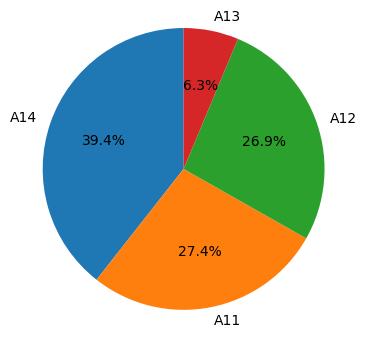

In [ ]:
freq_table = data[0].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

I dati sono consistenti con la descrizione iniziale. Si nota che il 40% circa non ha ancora un conto corrente (A14). La categoria meno popolata è A13, quella riferita a conti corrente con ≥ 200 DM.

##### **Attributo 3:** Storia del credito

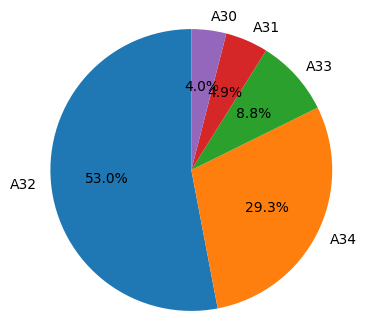

In [ ]:
freq_table = data[2].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig2, ax2 = plt.subplots(figsize=(4,4))
ax2.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
plt.show()

In questo caso possiamo notare che più del 50% dei record sono riferiti a crediti esistenti (nella banca considerata) debitamente rimborsati. Quasi il 30% dei record, invece, è riferito a conti critici o ad altri crediti esistenti. I valori di questo attributo sono consistenti con la descrizione.

##### **Attributo 4:** Scopo della richiesta di creidto

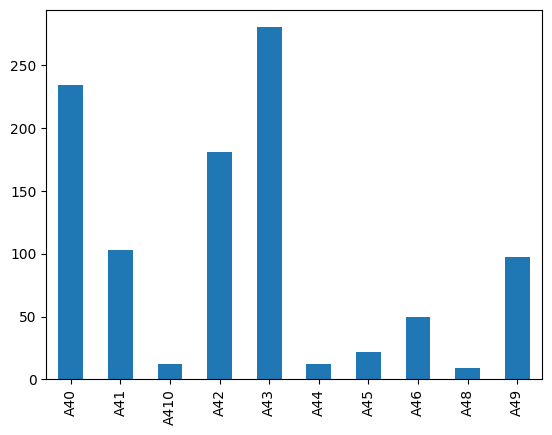

In [ ]:
freq_table = data[3].value_counts().sort_index()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

ax3 = freq_table.plot.bar(x=xaxis.categories, y=value)

Avendo un numero di modalità più elevato, in questo caso è più adatto un bar chart per mostrare le caratteristiche di questo attributo. I valori sono consistenti con la descrizione dell'attributo, e possiamo notare che le richieste di credito sono prevalentemente per radio o televisione (A43) o per un'auto nuova (A40). I valori più bassi si hanno per lavori di riqualificazione o per altre richieste.

##### **Attributo 6:** Conto di risparmio/obbligazioni

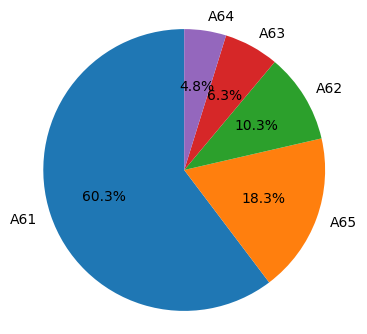

In [ ]:
freq_table = data[5].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig4, ax4 = plt.subplots(figsize=(4,4))
ax4.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax4.axis('equal')
plt.show()

Per quest'attributo la moda è data dal valore A61, riferito a conti di risparmio inferiori a 100 marchi. Il secondo valore più elevato è riferito ad assenza del conto o a conti sconosciuti (A65).

##### **Attributo 7:** Occupazione attuale

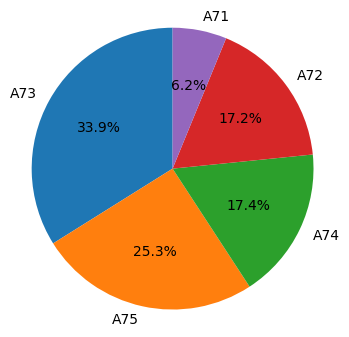

In [ ]:
freq_table = data[6].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig5, ax5 = plt.subplots(figsize=(4,4))
ax5.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax5.axis('equal')
plt.show()

Per quanto riguarda l'occupazione dei clienti, la maggior parte sono impiegati da 1 a 4 anni (A73). Solo in minima parte (A71) sono disoccupati.

##### **Attributo 9:** Stato personale e sesso

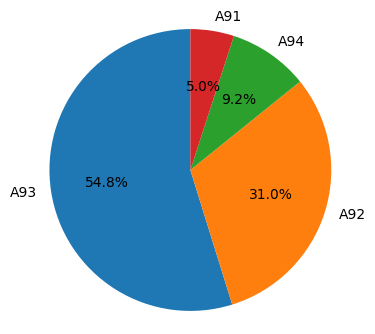

In [ ]:
freq_table = data[8].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig6, ax6 = plt.subplots(figsize=(4,4))
ax6.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax6.axis('equal')
plt.show()

La maggior parte dei clienti sono maschi single o donne divorziate, separate o sposate. Da segnalare l'assenza di clienti donne single (A95).

##### **Attributo 10:** Altri debitori/garanti

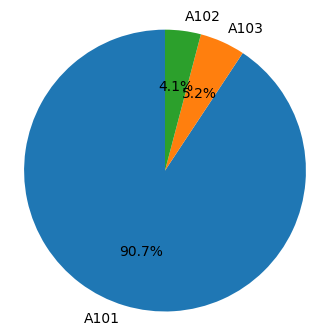

In [ ]:
freq_table = data[9].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig7, ax7 = plt.subplots(figsize=(4,4))
ax7.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax7.axis('equal')
plt.show()

In questo caso è netta la prevalenza di clienti appartenenti alla classe A101, riferita a clienti che non hanno altri debitori o garanti.

##### **Attributo 12:** Proprietà

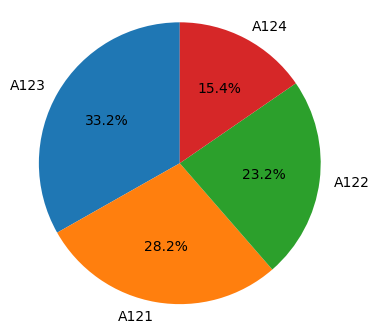

In [ ]:
freq_table = data[11].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig8, ax8 = plt.subplots(figsize=(4,4))
ax8.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax8.axis('equal')
plt.show()

La distribuzine di questa variabile risulta maggiormente omogenea rispetto alle precedenti. La maggior parte dei clienti appartengono alla categoria A123, proprietari di un'automobile non considerata nell'attributo 6. Un 15% non ha proprietà.

##### **Attributo 14:** Altri piani di rateizzazione

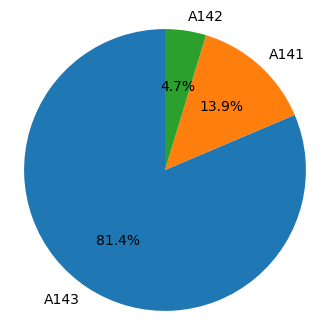

In [ ]:
freq_table = data[13].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig9, ax9 = plt.subplots(figsize=(4,4))
ax9.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax9.axis('equal')
plt.show()

Più dell'80% dei clienti non hanno altri piani di rateizzazione. Fra coloro che hanno altri piani, questi li hanno prevalentemente in un'altra banca.

##### **Attributo 15:** Abitazione

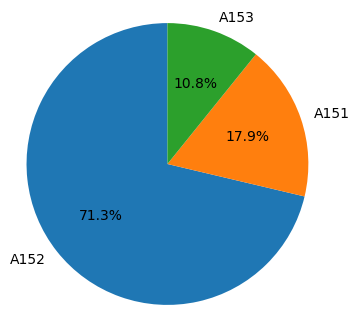

In [ ]:
freq_table = data[14].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig10, ax10 = plt.subplots(figsize=(4,4))
ax10.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax10.axis('equal')
plt.show()

Oltre il 70% dei clienti possiedono un'abitazione propria. Poco più del 10% vivono gratuitamente in un'abitazione.

##### **Attributo 17:** Lavoro

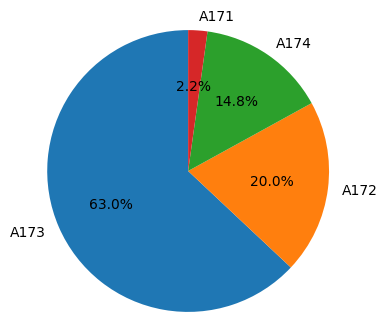

In [ ]:
freq_table = data[16].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig11, ax11 = plt.subplots(figsize=(4,4))
ax11.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax11.axis('equal')
plt.show()

La maggior parte dei clienti sono impiegati qualificati (A173). Solo il 2% è disoccupato o ha un lavoro non qualificato.

##### **Attributo 19:** Telefono

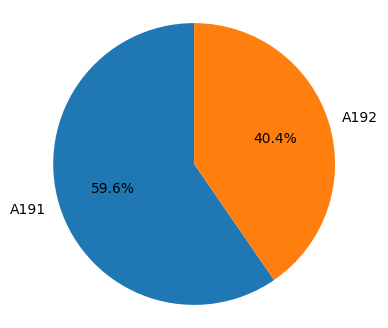

In [ ]:
freq_table = data[18].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig12, ax12 = plt.subplots(figsize=(4,4))
ax12.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax12.axis('equal')
plt.show()

In questo caso si nota che la maggior parte dei clienti non hanno un telefono registrato.

##### **Attributo 20:** lavoratore straniero

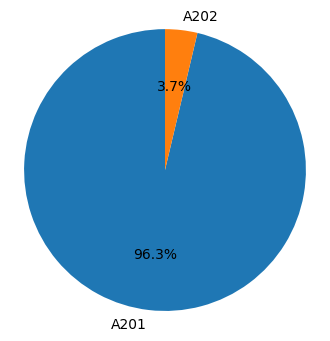

In [ ]:
freq_table = data[19].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig13, ax13 = plt.subplots(figsize=(4,4))
ax13.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax13.axis('equal')
plt.show()

Interessante notare che la quasi totalità del dataset è riferita a lavoratori stranieri.

##### **Label:** Classificazione del credito

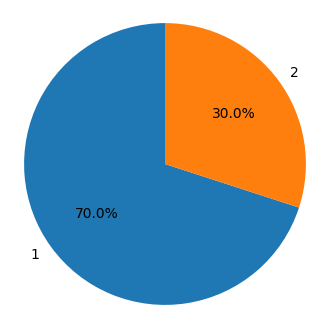

In [ ]:
freq_table = data[20].value_counts()
xaxis = freq_table.index
value = freq_table.values

# Controllo che il totale dei valori estratti sia esattamente 1000 come ulteriore
# verifica sulla completezza dei dati

if value.sum() != 1000:
  print('Ci sono dei valori mancanti. Value =', value.sum())

fig14, ax14 = plt.subplots(figsize=(4,4))
ax14.pie(value, labels=xaxis, autopct='%1.1f%%', startangle=90)
ax14.axis('equal')
plt.show()

Osservando l'attributo che riporta la label associata a ciascun record possiamo notare che il 70% ha un credito classificato come positivo, il restante 30% come negativo.

#### Attributi numerici

Come prima cosa, vado a calcolare media e deviazione standard per i vari attributi numerici:

In [ ]:
numeric_data = data.select_dtypes(include='int64')
means = {}
stdev = {}

for i in numeric_data.columns:
  means[i] = numeric_data[i].mean()
  stdev[i] = numeric_data[i].std()

In [ ]:
print("Attributo 2: Durata in mesi |", round(means[1], 2), "+/-", round(stdev[1], 2))
print("Attributo 5: Ammontare del credito |", round(means[4], 2), "+/-", round(stdev[4], 2))
print("Attributo 8: Tasso di rata in percentuale del reddito disponibile |", round(means[7], 2), "+/-", round(stdev[7], 2))
print("Attributo 11: Attuale residenza da allora |", round(means[10], 2), "+/-", round(stdev[10], 2))
print("Attributo 13: Età in anni |", round(means[12], 2), "+/-", round(stdev[12], 2))
print("Attributo 16: Numero di crediti esistenti presso questa banca |", round(means[15], 2), "+/-", round(stdev[15], 2))
print("Attributo 18: Numero di persone tenute a provvedere al mantenimento |", round(means[17], 2), "+/-", round(stdev[17], 2))

Attributo 2: Durata in mesi | 20.9 +/- 12.06
Attributo 5: Ammontare del credito | 3271.26 +/- 2822.74
Attributo 8: Tasso di rata in percentuale del reddito disponibile | 2.97 +/- 1.12
Attributo 11: Attuale residenza da allora | 2.84 +/- 1.1
Attributo 13: Età in anni | 35.55 +/- 11.38
Attributo 16: Numero di crediti esistenti presso questa banca | 1.41 +/- 0.58
Attributo 18: Numero di persone tenute a provvedere al mantenimento | 1.16 +/- 0.36


Abbiamo una prima indicazione dell'intervallo di valori su cui sono definite le variabili numeriche. Si può notare facilmente dai valori di deviazione standard che la variabilità interna ai dati è piuttosto importante.

Per avere una descrizione più approfondita della distribuzione dei dati vado a realizzare il box-plot di ciascuna variabile numerica:

In [ ]:
numeric_data = numeric_data.rename(columns={1: "Attributo1", 4: "Attributo4", 7: "Attributo7", 10: "Attributo10", 12: "Attributo12", 15: "Attributo15", 17: "Attributo17"})

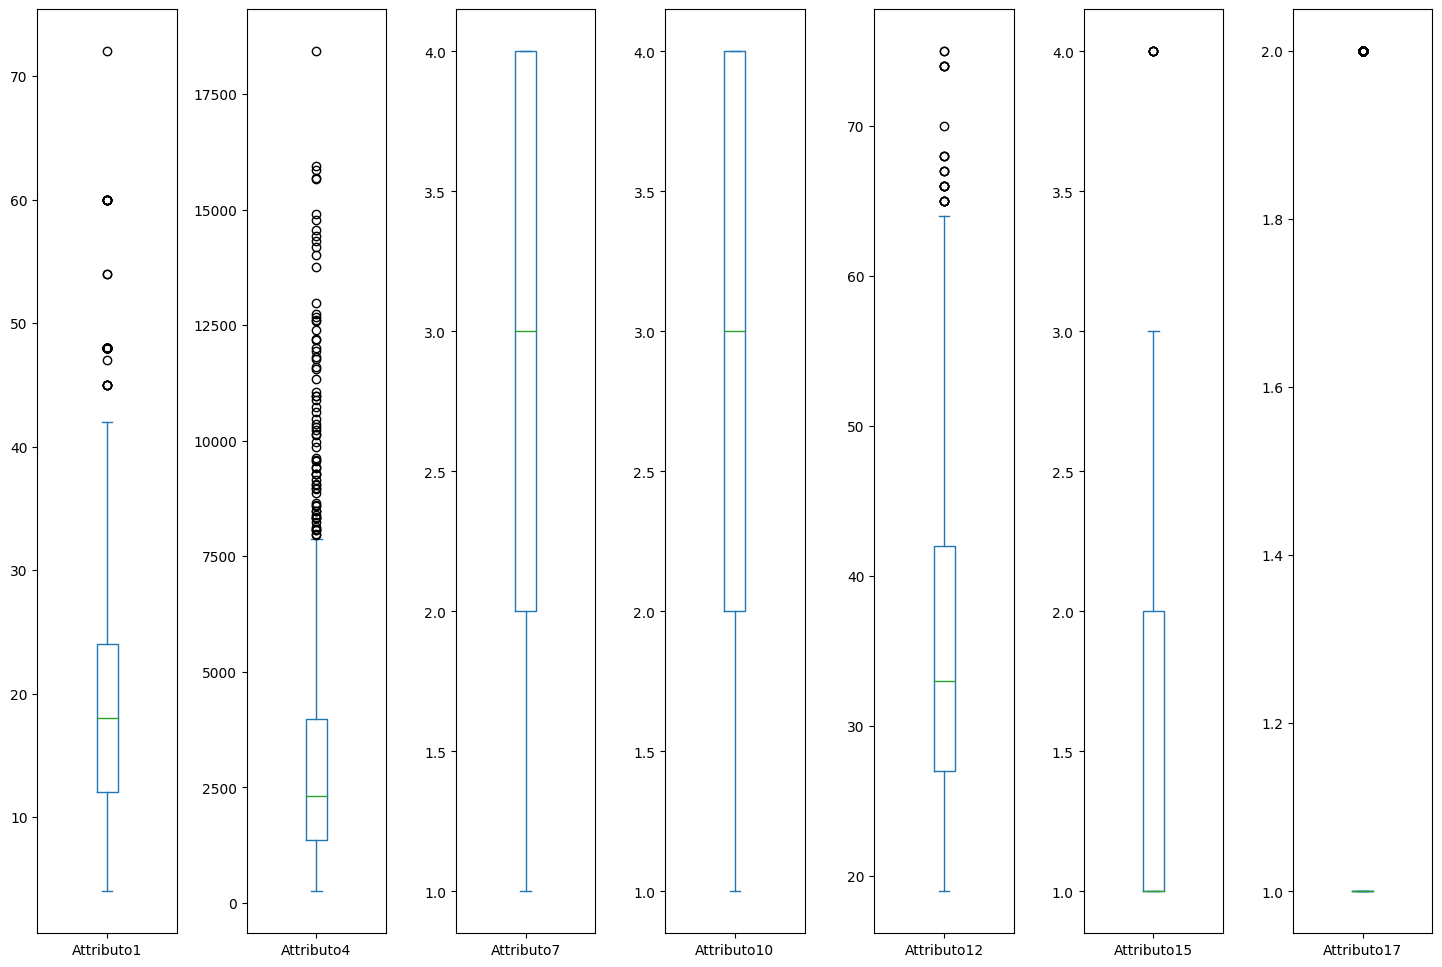

In [ ]:
numeric_data.plot(kind='box',
                  subplots=True,
                  sharey=False,
                  figsize=(18, 12))

plt.subplots_adjust(wspace=0.5)
plt.show()

Attraverso queste distribuzioni possiamo già notare qualcosa di più significativo:


*   la durata in mesi del credito (Attributo 1) si distribuisce prevalentemente nell'intervallo fra 5 e 40 mesi circa, con qualche outlier che arriva fino a un massimo di 70 mesi;
*   l'ammontare del credito (Attributo 4) presenta un elevato numero di outliers;
*   gli attributi 7, 10 e 15 (tasso di rata in percentuale, attuale residenza e numero di crediti esistenti) hanno tutti un range compreso fra 1 e 4;
*   l'età media dei clienti (Attributo 12) è prevalentemente compresa fra i 20 e i 60 anni, con la presenza di qualche outlier oltre i 65 anni circa;
*   la variabile riferita al numero di persone tenute a provvedere al mantenimento (Attributo 17) assume solamente valore 1 e 2.



### Analisi multivariata

A questo punto, può essere interessante andare ad indagare le relazioni fra le variabili all'interno del dataset. Il dataset in questione è caratterizzato da una prevalenza di variabili categoriche non ordinali (non è possibile stabilire un ordinamento fra le modalità delle variabili) e da alcune variabili numeriche.

Per il confronto fra le variabili categoriche del dataset verranno quindi utilizzate delle tabelle di contingenza, così da poter mettere in evidenza la distribuzione congiunta di variabili di questo tipo. Inoltre, si può andare a calcolare l'indice V di Cramer per quantificare la forza di tale associazione.

Per confrontare le variabili numeriche, invece, è possibile ricorrere al calcolo della correlazione, mediante il coefficiente di correlazione di Pearson.

Infine, per mettere in mostra la possibile relazione fra variabili numeriche e categoriche mi affiderò a dei box-plot condizionati.

Come ultima cosa, verrà analizzata la distribuzione dei singoli attributi rispetto alla variabile target.


In [ ]:
sns.set(rc={'figure.figsize':(18, 12)})

#### Relazioni fra variabili categoriche

Come prima cosa, vado a calcolare l'indice V di Cramer per ciascuna coppia di variabili categoriche contenute nel dataset. La V di Cramer, prendendo in considerazione una tabella di contingenza di una coppia di variabili categoriche, si calcola come:

$𝗩 = \sqrt{\frac{Χ^2}{(k-1)(r-1)n}}$

dove $\chi^{2}$ è il chi quadrato, n è il numero totale di osservazioni, k è il numero di colonne e r è il numero di righe.

Più il valore della V di Cramer è elevato, maggiore è la forza dell'associazione tra le variabili. Orientativamente, si può dire che se se il valore ottenuto della V di Cramer è compreso tra 0 e 0,3 si ha una bassa associazione, da 0,3 a 0,6 si ha una buona associazione, da 0,6 a 1 si ha un'ottima associazione.

Per calcolare l'indice per ciascuna coppia di variabili categoriche ho la necessità di trasformare tali variabili utilizzando il `labelencoder` di `sklearn`.


In [ ]:
categoric_data = data.select_dtypes(include='category')
categoric_data.head()

,0,2,3,5,6,8,9,11,13,14,16,18,19,20
0,A11,A34,A43,A65,A75,A93,A101,A121,A143,A152,A173,A192,A201,1
1,A12,A32,A43,A61,A73,A92,A101,A121,A143,A152,A173,A191,A201,2
2,A14,A34,A46,A61,A74,A93,A101,A121,A143,A152,A172,A191,A201,1
3,A11,A32,A42,A61,A74,A93,A103,A122,A143,A153,A173,A191,A201,1
4,A11,A33,A40,A61,A73,A93,A101,A124,A143,A153,A173,A191,A201,2


In [ ]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in categoric_data.columns:
  data_encoded[i]=label.fit_transform(categoric_data[i])

data_encoded.head()

,0,2,3,5,6,8,9,11,13,14,16,18,19,20
0,0,4,4,4,4,2,0,0,2,1,2,1,0,0
1,1,2,4,0,2,1,0,0,2,1,2,0,0,1
2,3,4,7,0,3,2,0,0,2,1,1,0,0,0
3,0,2,3,0,3,2,2,1,2,2,2,0,0,0
4,0,3,0,0,2,2,0,3,2,2,2,0,0,1


In [ ]:
# Funzione per il calcolo della V di Cramer

def cramers_V(var1,var2):
  # Costruzione della tabella di contingenza
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  # Calcolo del Chi quadro
  stat = chi2_contingency(crosstab)[0]
  # Numero di osservazioni
  obs = np.sum(crosstab)
  # Estrazione del valore minimo fra righe e colonne della tabella di contingenza
  mini = min(crosstab.shape)-1
  return (stat/(obs*mini))

In [ ]:
# Costruzione della matrice delle V di Cramer
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    # Computazione della V di Cramer di var1 con tutte le possibili altre var2
    cramers = cramers_V(data_encoded[var1], data_encoded[var2])
    # Aggiungo alla lista col il valore della V arrotondato
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
categoric_cramer = pd.DataFrame(cramers_results, columns = data_encoded.columns, index = data_encoded.columns)

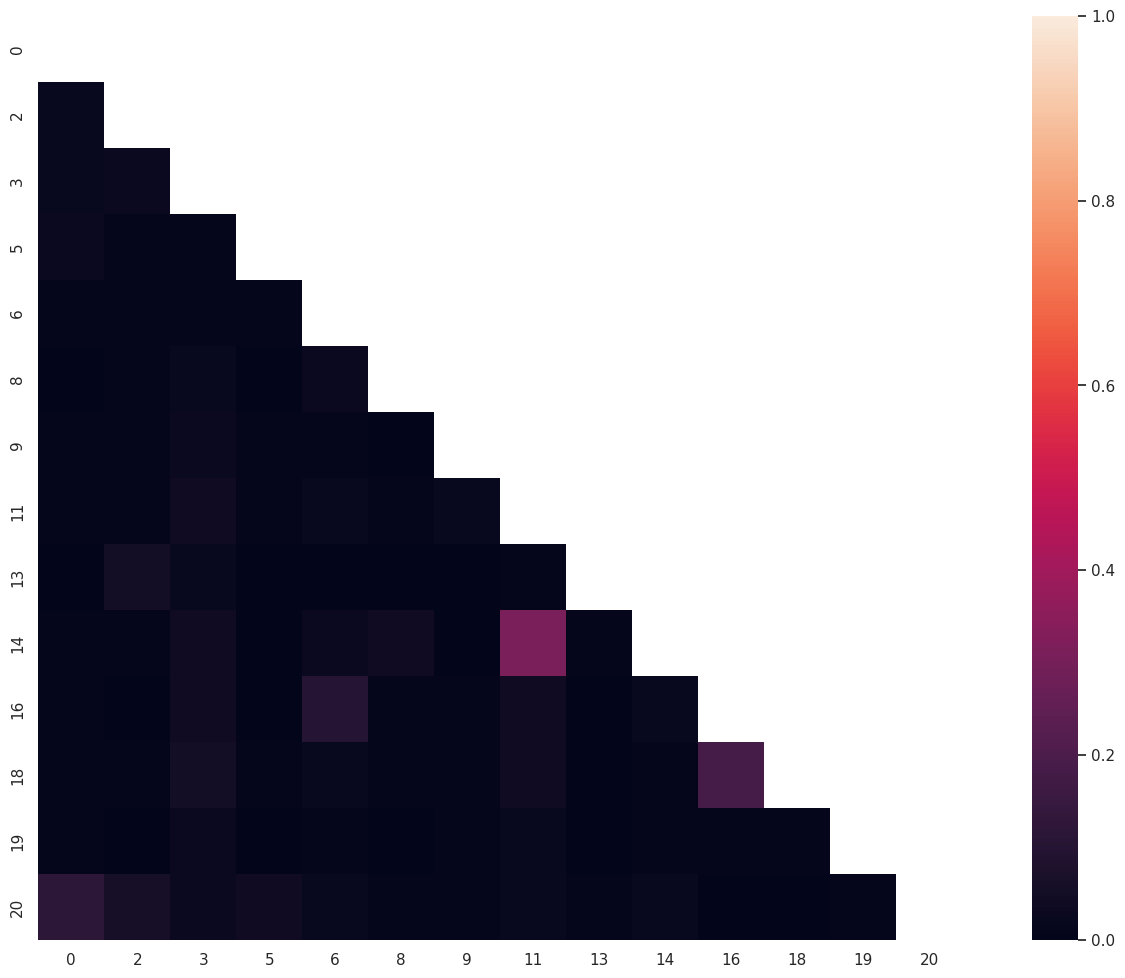

In [ ]:
mask = np.zeros_like(categoric_cramer, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(categoric_cramer, mask=mask, vmin=0., vmax=1, square=True)

plt.show()

Dalla heatmap appena mostrata non sembra esserci un'associazione significativa fra le diverse coppie di variabili categoriche prese in considerazione. L'unica che si distingue dalle altre è l'associazione fra le variabili 11 e 14, rispettivamente Proprietà e Abitazione. Per tale coppia possiamo mostrare direttamente la tabella di contingenza:

In [ ]:
c_table = pd.crosstab(data[11], data[14], margins = False)
c_table

14,A151,A152,A153
11,,,
A121,55,226,1
A122,46,184,2
A123,60,271,1
A124,18,32,104


Come si può notare dai valori stampati, la (debole) associazione fra le due variabili sembra essere dovuta più che altro alle modalità A153 con A124, mentre per la altre modalità non sembra esserci una tendenza evidente.

#### Relazioni fra variabili numeriche

Per quanto riguarda la relazione fra variabili numeriche, è possibile andare a calcolare l'indice di correlazione di Pearson:

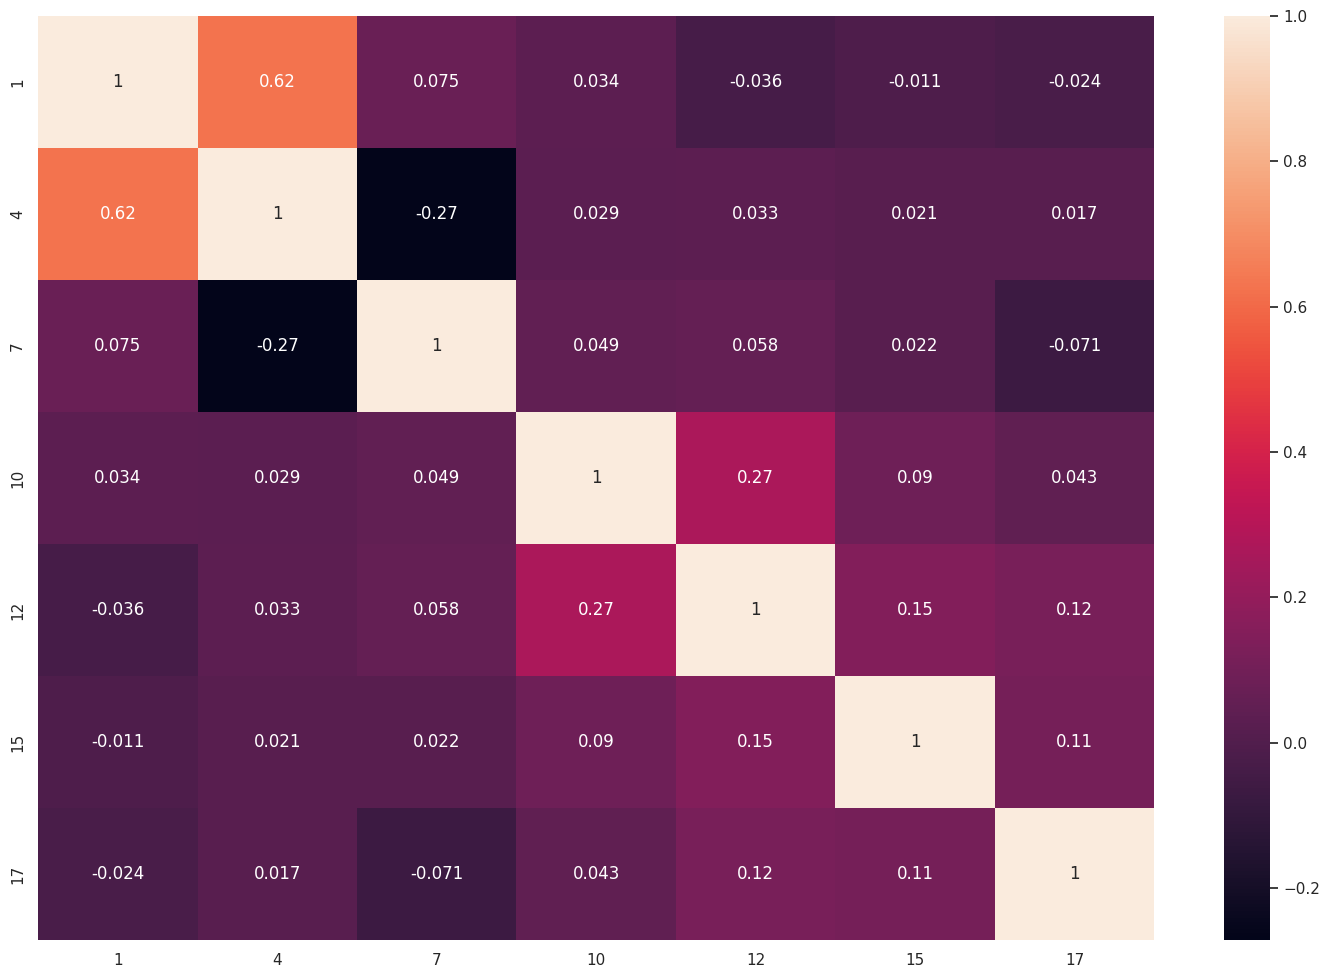

In [ ]:
f, ax = plt.subplots(figsize=(18,12))
sns.heatmap(data.corr(), annot=True);

Non si notano correlazioni particolarmente forti fra le variabili numeriche del dataset. Abbiamo una correlazione moderatamente forte (0.62) fra le variabili di durata in mesi e ammontare del credito. Concentrandosi più nel dettaglio rispetto alla variabile target:

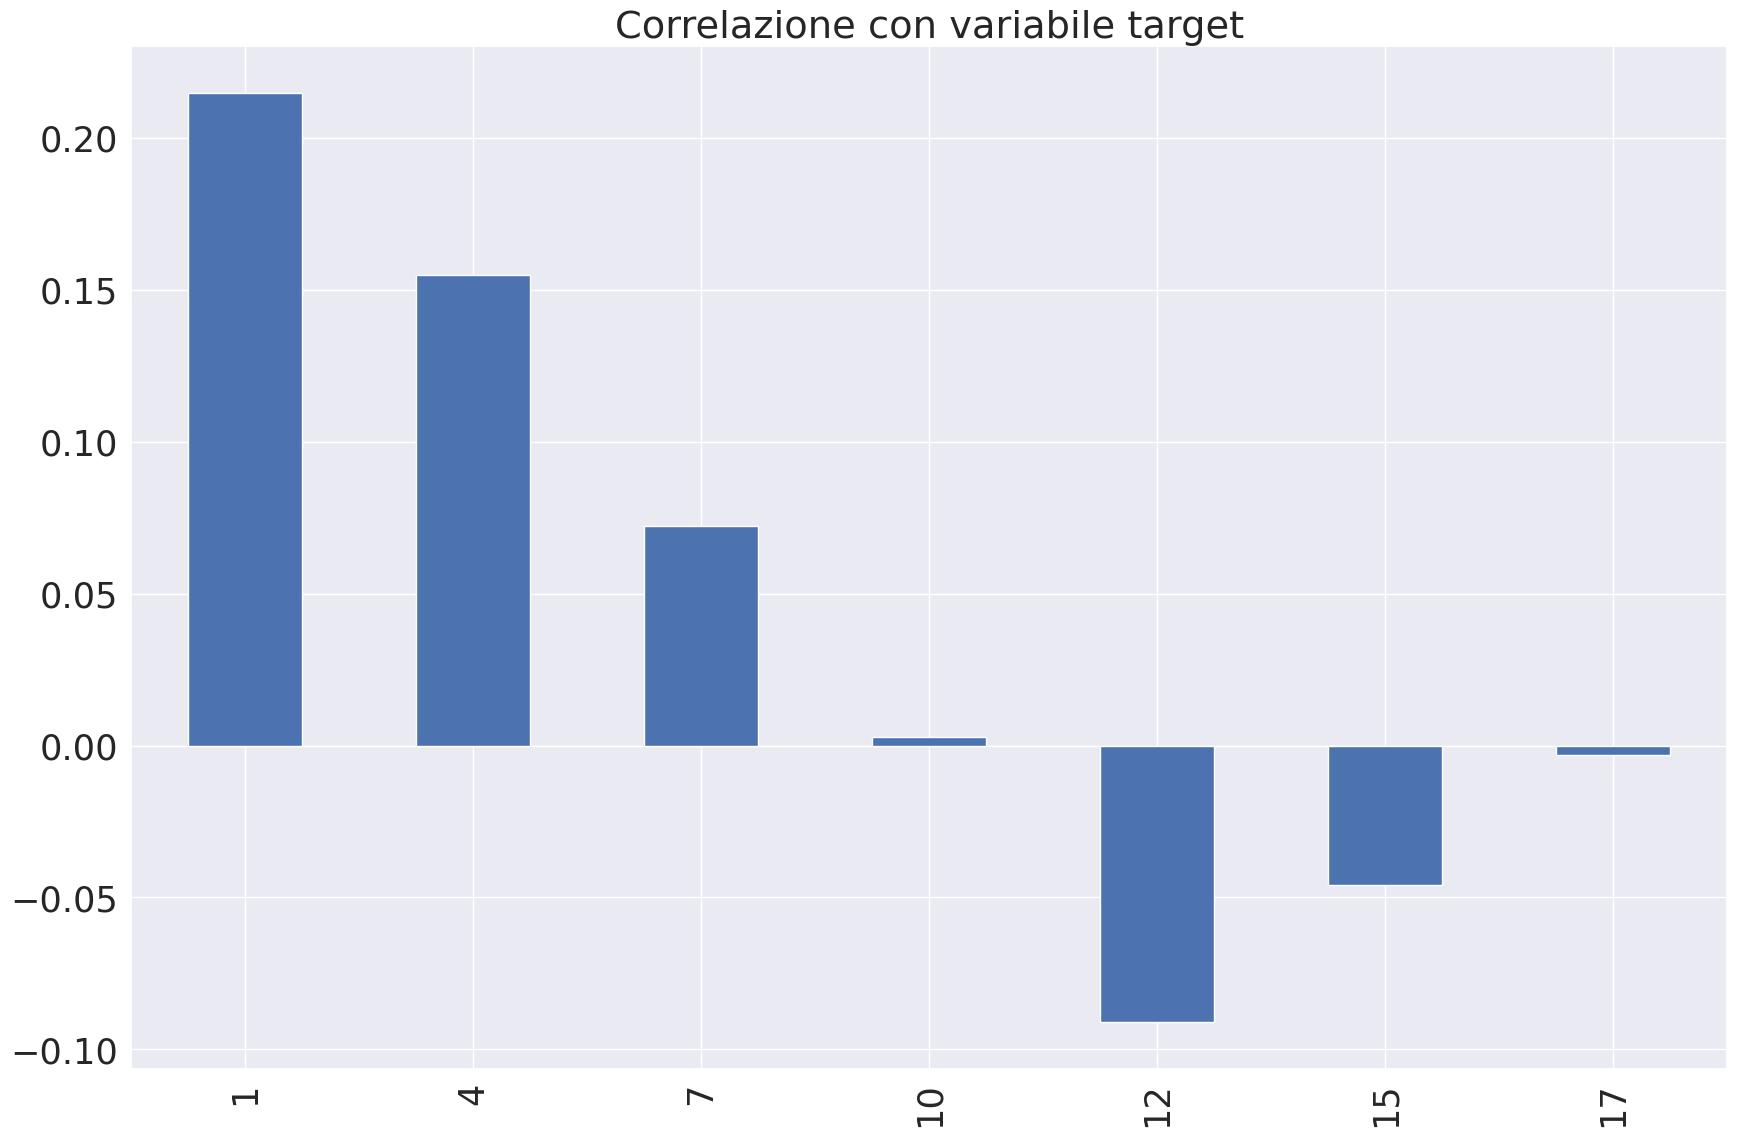

In [ ]:
sns.set_context('notebook',font_scale = 2.3)
data.drop(20, axis=1).corrwith(data[20]).plot(kind='bar', grid=True, figsize=(18, 12), title="Correlazione con variabile target")
plt.tight_layout()

Vediamo che le variabili numeriche del dataset non sembrano essere particolarmente correlate con la variabile target. Si nota solo una debole correlazione positiva con i primi due attributi (durata del credito e ammontare del credito) e una debole correlazione negativa con l'attributo riferito all'età del cliente.

#### Relazioni fra variabili categoriche e numeriche

Per indagare la possibile correlazione fra variabili numeriche e categoriche mi affido a dei box-plot condizionati. Idealmente potrebbe essere realizzato un box-plot condizionato per ciascuna coppia di variabili. Fra le diverse coppie valutate, mostro solamente quelle più interessanti.

##### vs. Scopo del credito

Text(0, 0.5, 'Ammontare del credito')

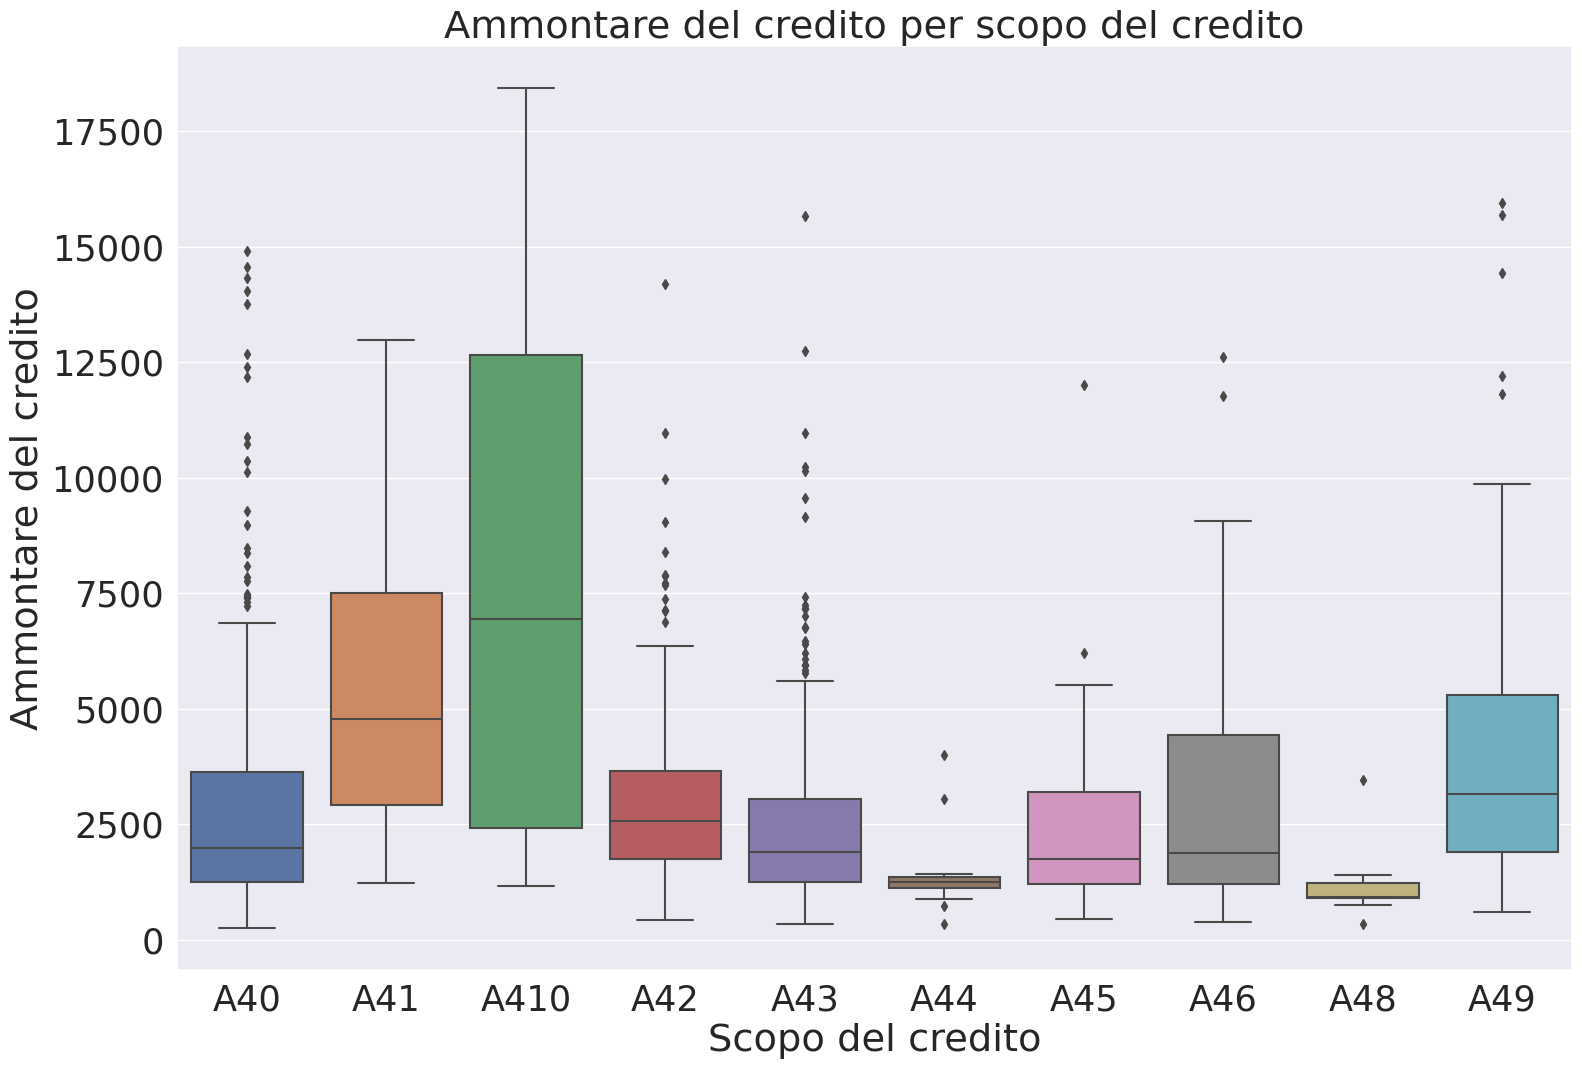

In [ ]:
ax = sns.boxplot(x=3, y=4, data=data)
ax.set_title('Ammontare del credito per scopo del credito')
ax.set_xlabel('Scopo del credito')
ax.set_ylabel('Ammontare del credito')

Possiamo vedere che la media più alta per l'ammontare del credito corrisponde a crediti richiesti per la categoria A410, corrispondente ad "altro". Successivamente, i crediti più elevati sono riferiti ad auto usate (A41) e affari (A49).

Text(0, 0.5, 'Durata del credito (mesi)')

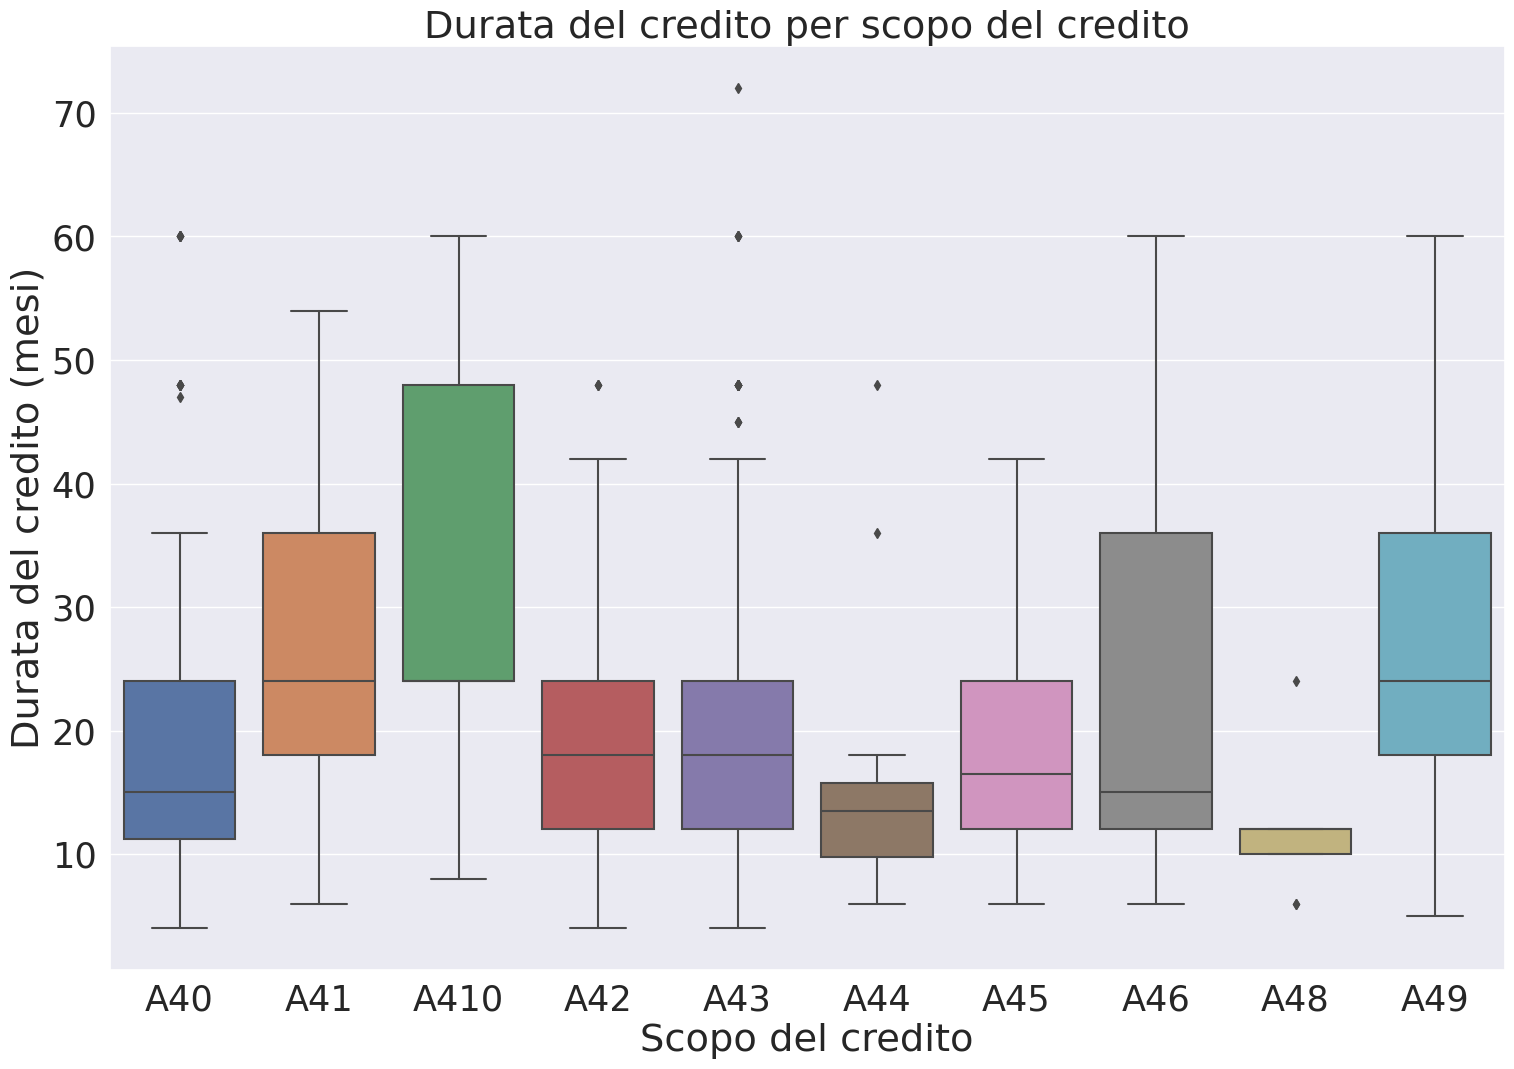

In [ ]:
ax = sns.boxplot(x=3, y=1, data=data)
ax.set_title('Durata del credito per scopo del credito')
ax.set_xlabel('Scopo del credito')
ax.set_ylabel('Durata del credito (mesi)')

Ci sono differenze abbastanza evidenti anche per quanto riguarda la durata del credito. Si nota una grande variabilità per le categorie A410 e A46 (altro e istruzione), mentre la varaibilità è minima per A44 e A48 (elettrodomestici e riqualificazione). Mediamente, i crediti più duraturi sono quelli per auto nuove (A41) e per gli affari (A49).

##### vs. Abitazione

Text(0, 0.5, 'Ammontare del credito')

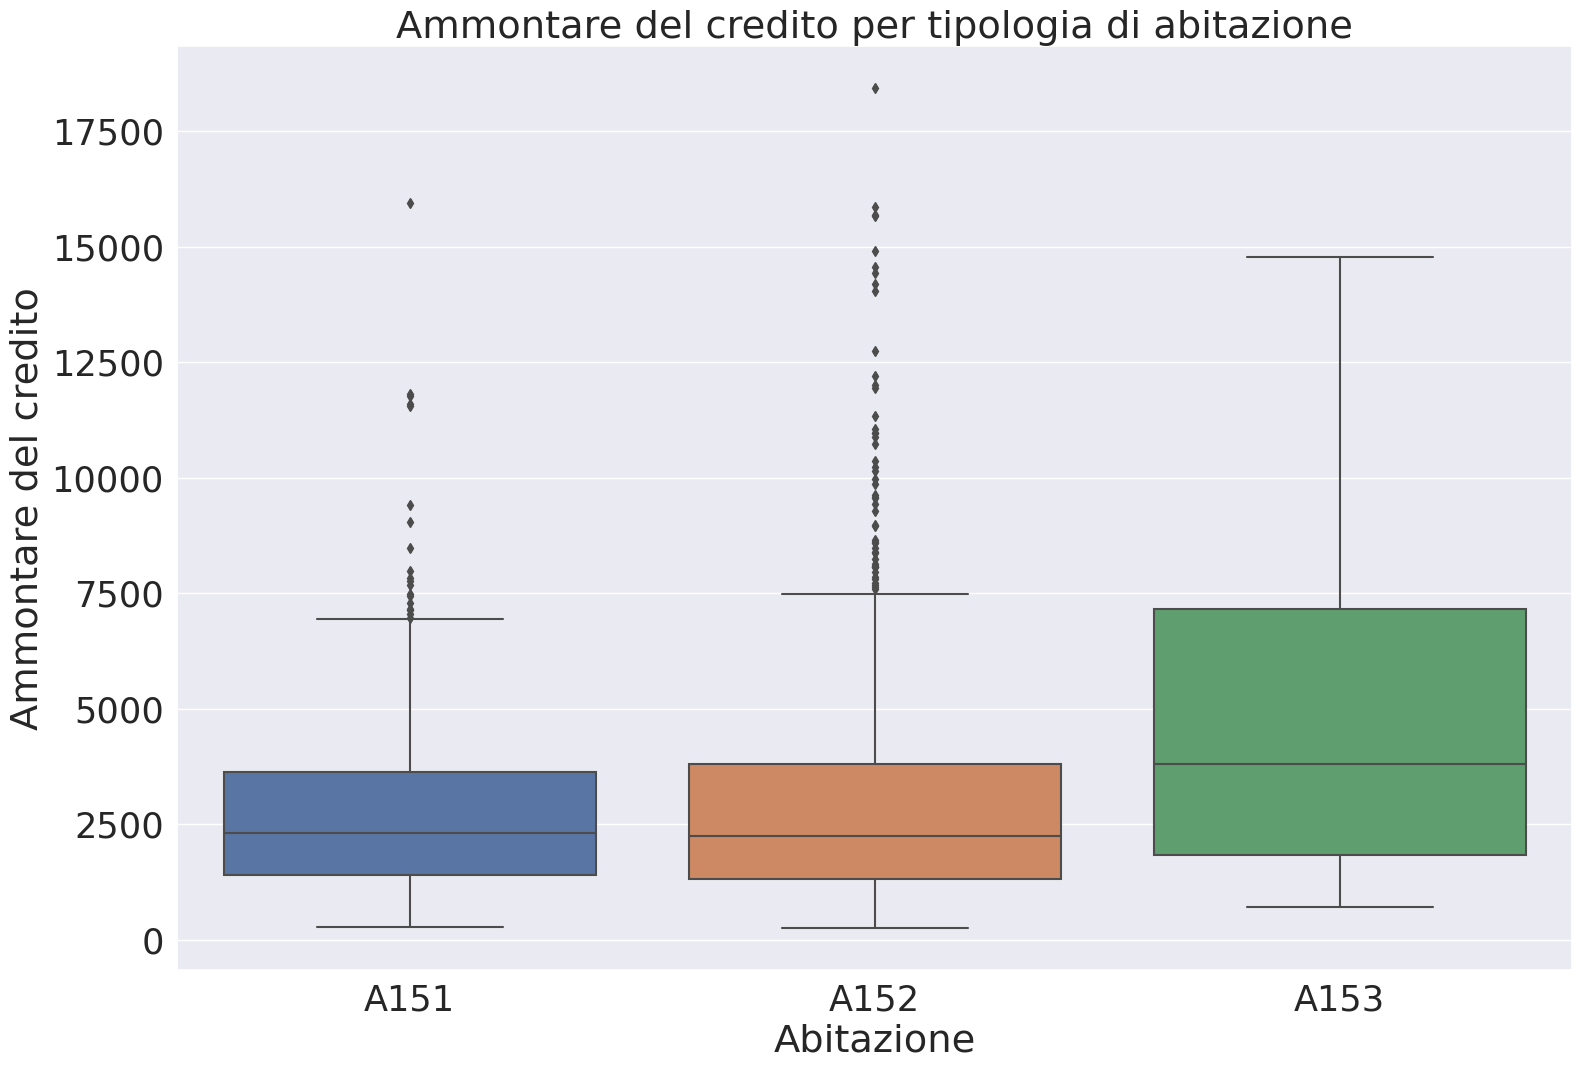

In [ ]:
ax = sns.boxplot(x=14, y=4, data=data)
ax.set_title('Ammontare del credito per tipologia di abitazione')
ax.set_xlabel('Abitazione')
ax.set_ylabel('Ammontare del credito')

In questo caso si nota come i clienti che appartengono alla categoria A151 e A152 per quanto riguarda l'abitazione (in affitto o in proprio) abbiano dei crediti di quantità mediamente inferiori rispetto a chi appartiene alla categoria A153. Tale differenza sembra significativa (mediana di A153 fuori dal box di A151 e A152).

Text(0, 0.5, 'Durata del credito (mesi)')

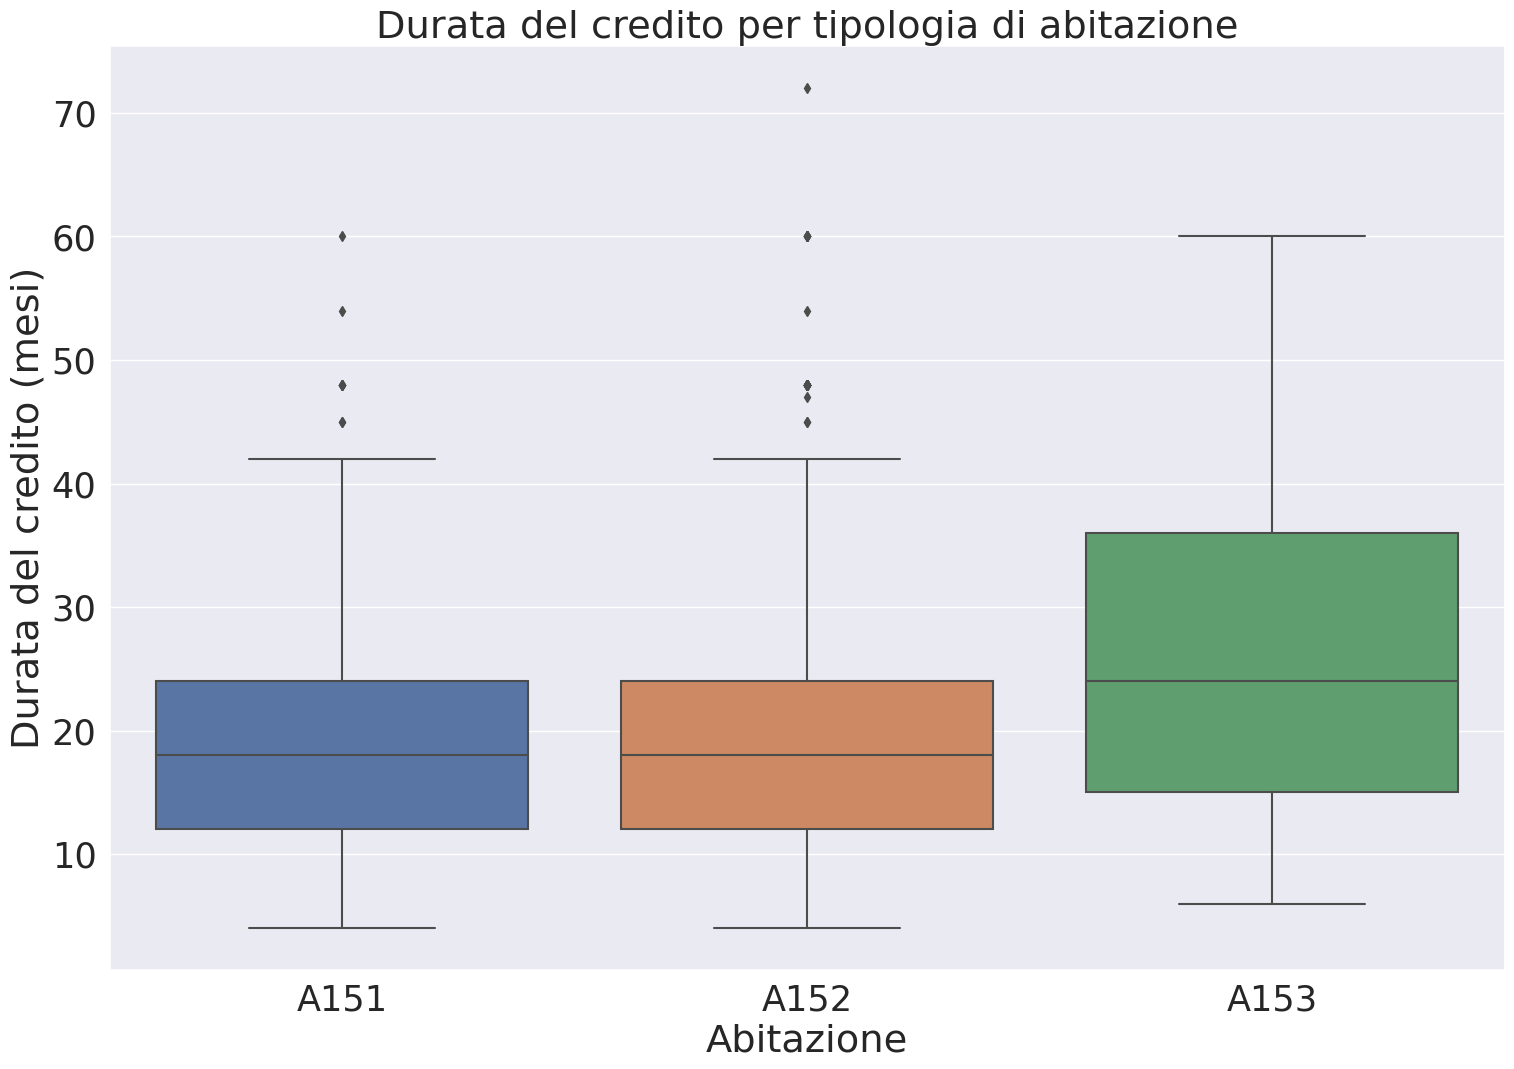

In [ ]:
ax = sns.boxplot(x=14, y=1, data=data)
ax.set_title('Durata del credito per tipologia di abitazione')
ax.set_xlabel('Abitazione')
ax.set_ylabel('Durata del credito (mesi)')

Consistentemente a ciò, anche la durata del credito è più elevata per chi ha abitazione gratis.

##### vs. lavoro

Text(0, 0.5, 'Ammontare del credito')

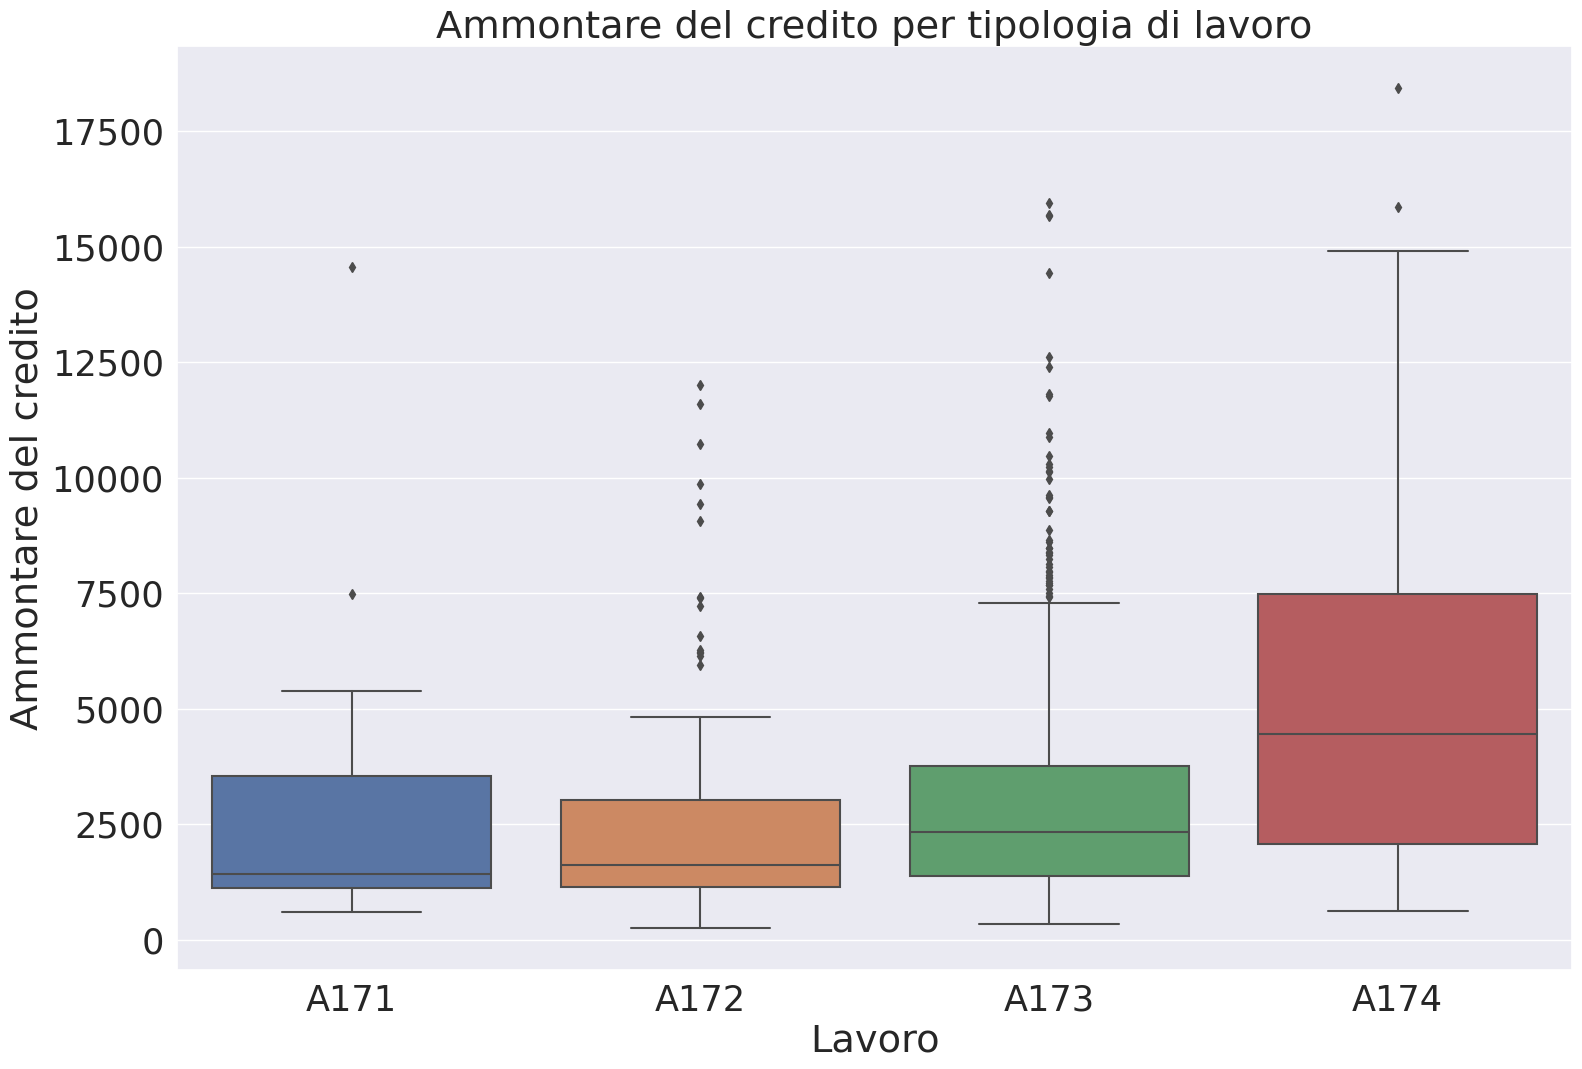

In [ ]:
ax = sns.boxplot(x=16, y=4, data=data)
ax.set_title('Ammontare del credito per tipologia di lavoro')
ax.set_xlabel('Lavoro')
ax.set_ylabel('Ammontare del credito')

Interessante notare come i crediti più elevati siano per la maggior parte a carico di persone appartenenti alla categoria A174 (dirigente/ lavoratore autonomo/ impiegato/funzionario altamente qualificato). Allo stesso modo, disoccupati e non qualificati (sia residenti che non, A171 e A172) abbiano dei crediti inferiori.

Text(0, 0.5, 'Durata del credito (mesi)')

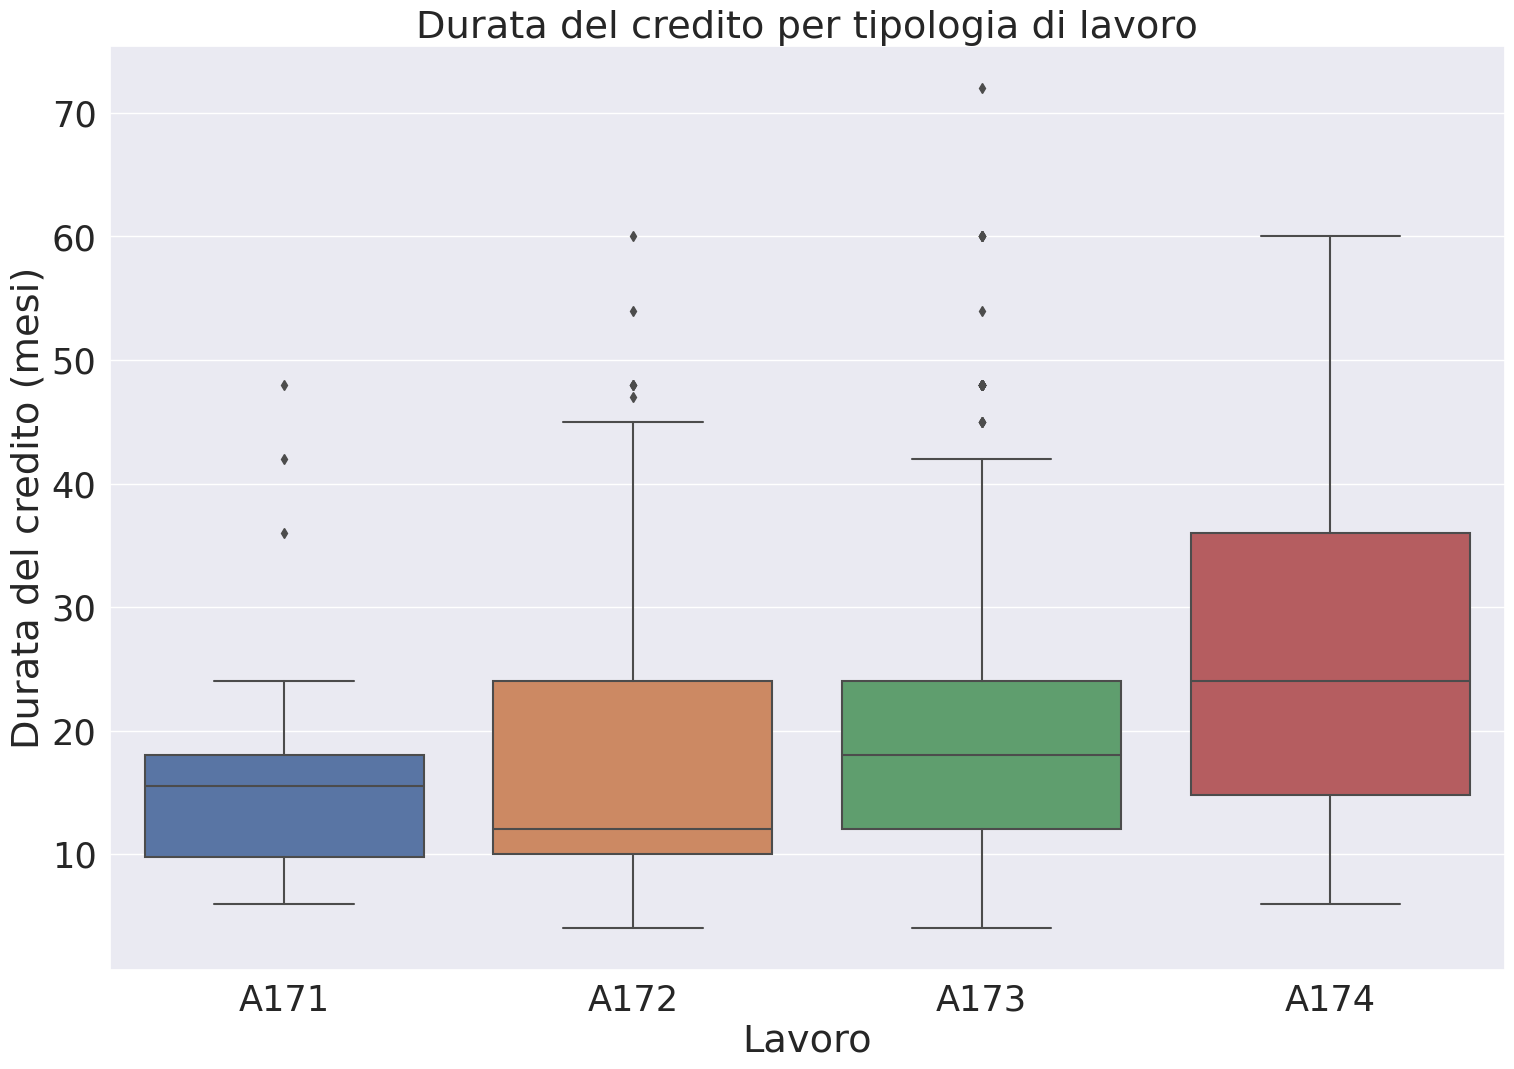

In [ ]:
ax = sns.boxplot(x=16, y=1, data=data)
ax.set_title('Durata del credito per tipologia di lavoro')
ax.set_xlabel('Lavoro')
ax.set_ylabel('Durata del credito (mesi)')

Allo stesso modo si nota che gli appartenenti alla categoria A174 sono colo che hanno un credito che va avanti mediamente da più tempo.

##### Età

Text(0, 0.5, 'Età del cliente')

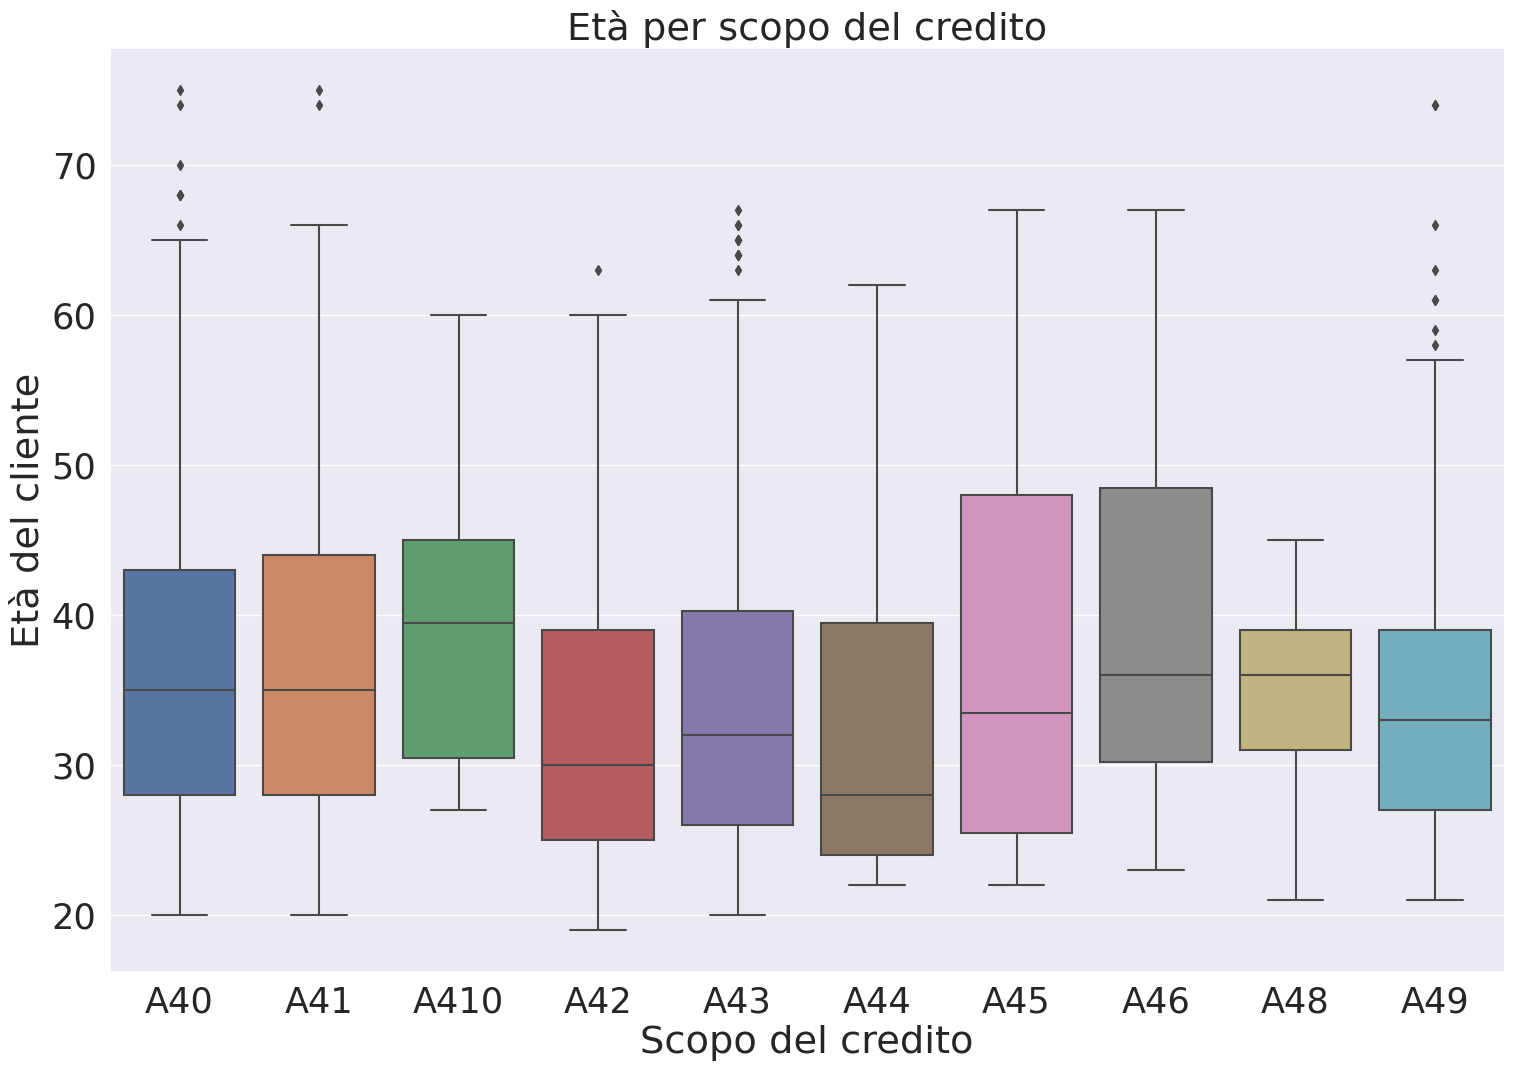

In [ ]:
ax = sns.boxplot(x=3, y=12, data=data)
ax.set_title('Età per scopo del credito')
ax.set_xlabel('Scopo del credito')
ax.set_ylabel('Età del cliente')

Si nota qualche differenza anche rispetto all'età. Le categorie A42 (mobili/attrezzature) e A44 (elettrodomestici) sono richieste da persone mediamente più giovani, mentre la media dei richiedenti risulta più elevata per categorie come A40/A41 (auto nuove e usate), A46 (istruzione) o A410 (altro).

Text(0, 0.5, 'Età')

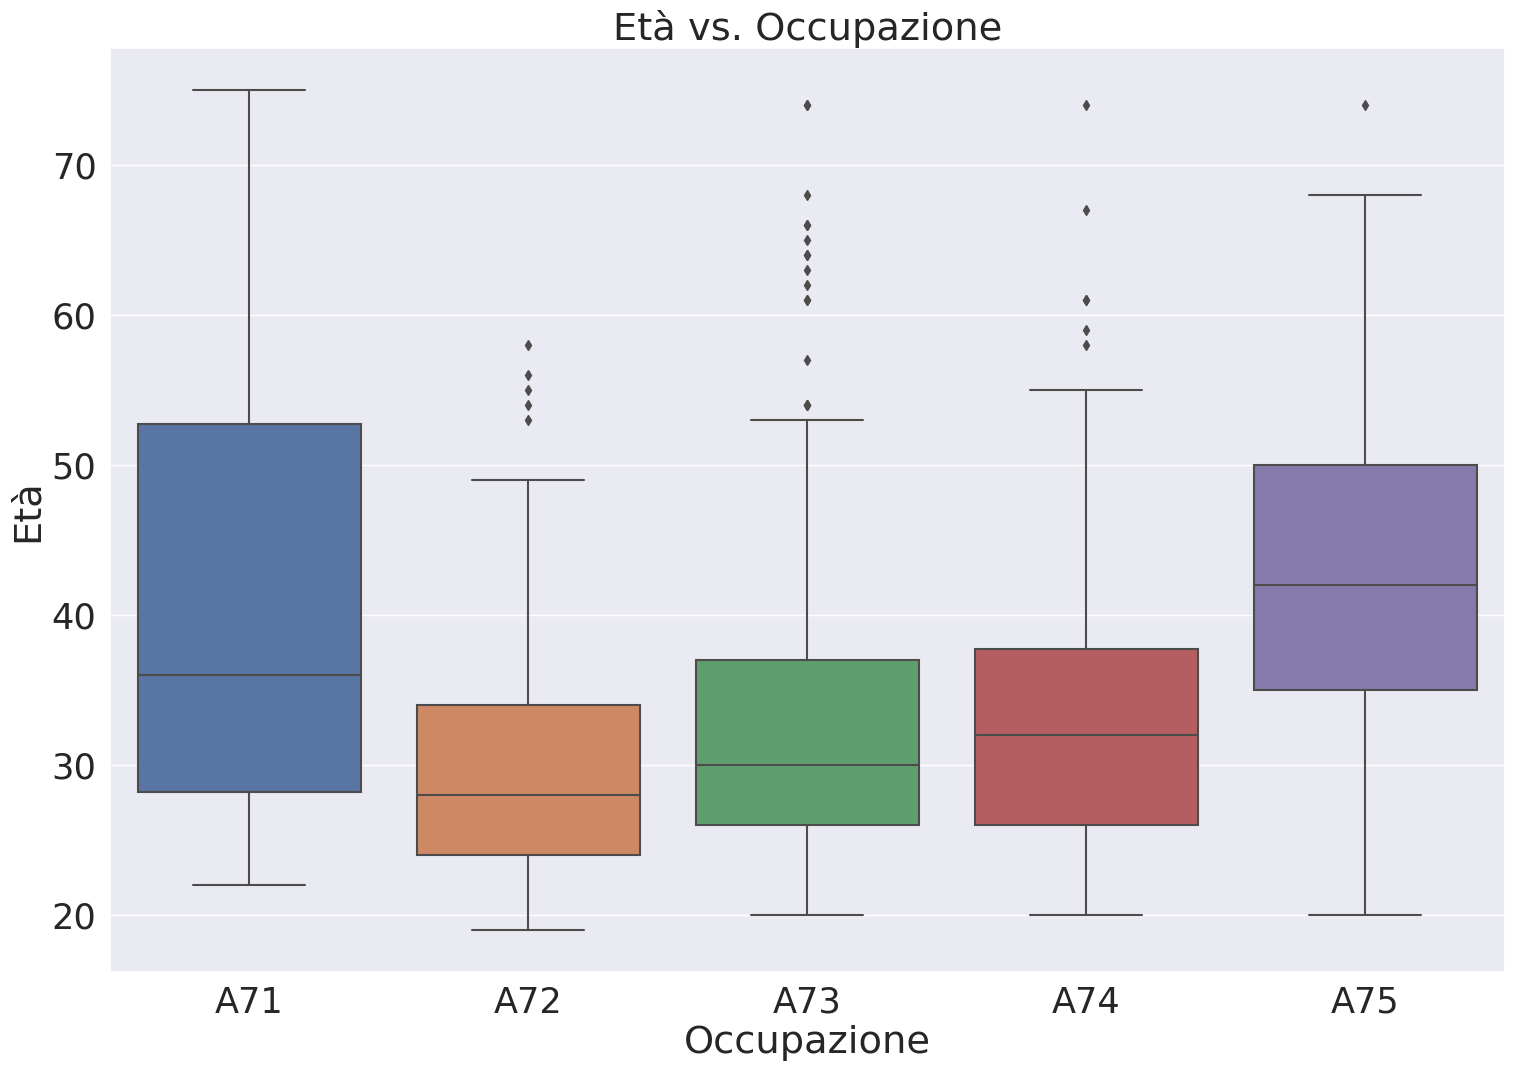

In [ ]:
ax = sns.boxplot(x=6, y=12, data=data)
ax.set_title('Età vs. Occupazione')
ax.set_xlabel('Occupazione')
ax.set_ylabel('Età')

Come informazione marginale è interessante anche osservare come le categorie con un'età media più elevata siano quelle di disoccupati o di persone con un impiego stablile da più di 7 anni.

#### Distribuzione condizionata della variabile target

In [ ]:
data.columns = ['status', 'durata', 'storia', 'scopo', 'valore_credito', 'conto_risparmio',
                'occupazione', 'tasso_rata', 'stato_persona', 'altri_debitori', 'residenza',
                'proprietà', 'età', 'altri_piani', 'abitazione', 'n_crediti', 'lavoro',
                'n_persone', 'telefono', 'straniero', 'label']

Dopo aver indagato le relazioni fra le possibili coppie di variabili all'interno del dataset, ci si concentra sulla distribuzione condizionata dell'attributo target rispetto ai vari altri attributi.

Si parte dalla relazione con gli attributi categorici, indagata mediante un semplice bar plot condizionato.

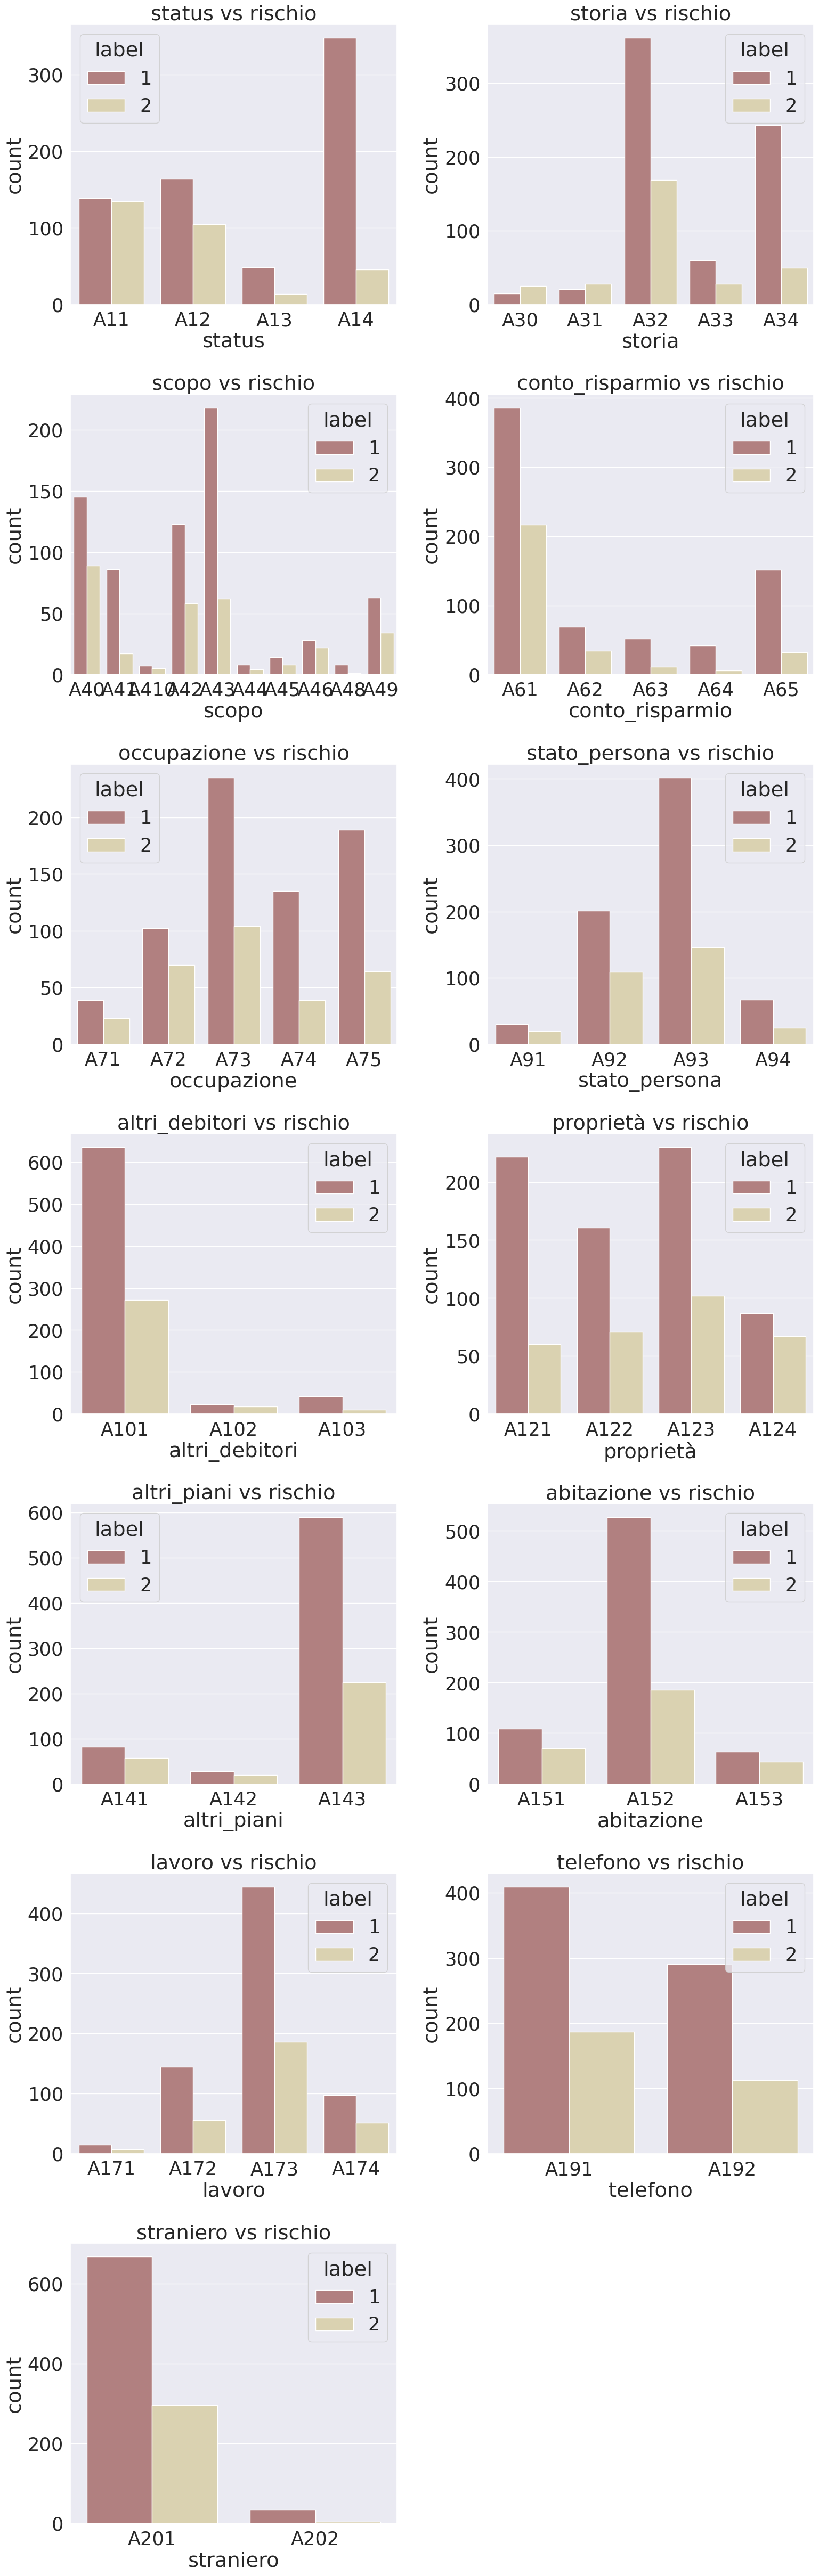

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8*2, 7*7))

# Attributi categorici
categorical_attr = ['status', 'storia', 'scopo', 'conto_risparmio', 'occupazione',
                   'stato_persona', 'altri_debitori', 'proprietà', 'altri_piani',
                   'abitazione', 'lavoro', 'telefono', 'straniero']

# Mostra ogni variabile categorica rispetto all'attributo target
for i, var in enumerate(categorical_attr):
    row = i // 2  # Calcolo l'indice di riga
    col = i % 2   # Calcolo l'indice di colonna

    sns.countplot(x=var, hue="label", data=data, ax=axes[row, col], palette = "pink")
    axes[row, col].set_title(f'{var} vs rischio')

# Cancello il grafico in eccesso
fig.delaxes(axes[6][1])

plt.tight_layout()
plt.show()

Alcune cose da segnalare. Si nota una quantità molto bassa di label 2 (classificazione credito "cattivo") per osservazioni il cui status corrisponde alla modalità A14 ("nessun conto corrente"). Anche rispetto all'attributo storia, la quantità di label rispetto alla modalità A34 ("conto critico/ altri crediti esistenti (non presso questa banca)") è bassa, nonostante per conto critico si sia portati a pensare che la classificazione del credito debba essere cattiva. Per il resto, la proporzione fra label 1 e 2 segue a grandi linee la distribuzione dei dati fra le diverse modalità degli attributi.

Si procede ora con l'analisi rispetto agli attributi numerici. Per quanto già visto in precedenza, quando tali attributi sono stati analizzati singolarmente, vengono considerati solamente le variabili di durata del credito, valore del credito ed età. Le altre variabili numeriche (tasso rata percentuale, residenza, numero di crediti e numero di persone) assumono valori interi nel range [1, 2] o [1, 4], pertanto le rispettive distribuzioni condizionate alla label sono poco indicative in quanto totalmente identiche. Il grafico sfruttato, in questo caso, è un box plot.

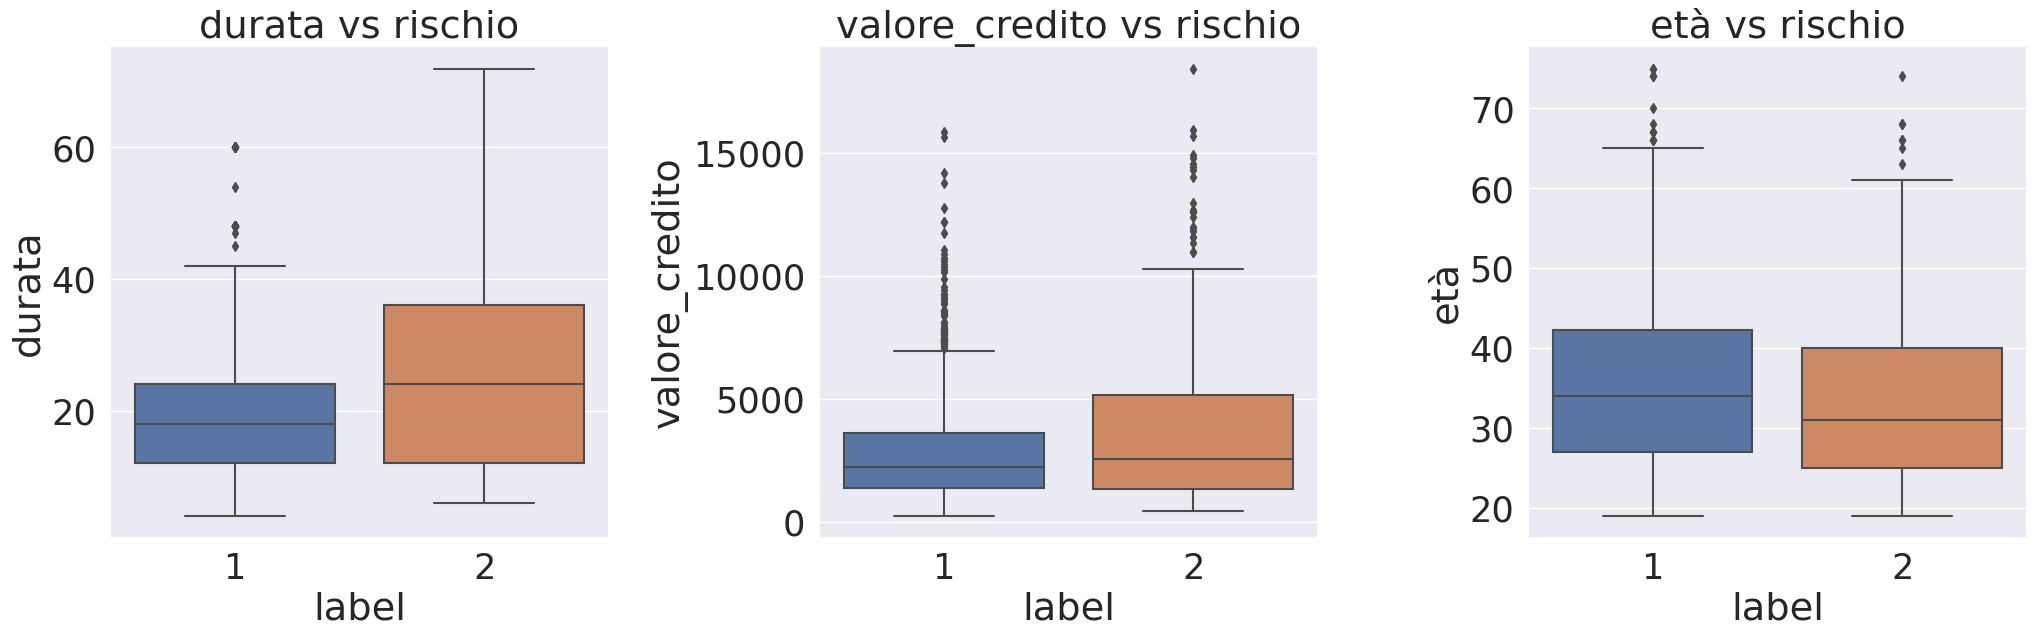

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

numeric_attr = ['durata', 'valore_credito', 'età']

# Mostra ogni variabile categorica rispetto all'attributo target
for i, var in enumerate(numeric_attr):
    sns.boxplot(x='label', y=var, data=data, ax=axes[i])
    axes[i].set_title(f'{var} vs rischio')

plt.tight_layout()
plt.show()

In questo caso possiamo vedere che rispetto alla label 2 la durata del credito è mediamente più elevata, mentre rispetto alle altre variabili le distribuzioni non sono significativamente differenti.

<a id="esercizio2"></a>
## Classificazione

Partendo dal dataset precedentemente analizzato e ripulito, in questa parte d'esercizio vi viene richiesto di eseguire una classificazione del dataset.

L'ultima colonna (**Attributo 21**) contiene la label che il modello deve imparare ad apprendere.

Viene richiesto di utilizzare diversi modelli di clusterizzazione, praparare i dati e le feature per il loro utilizzo e quindi effettuare la previsione. Viene chiesto di valutare la bontà della previsione del modello e di commentare la sua capacità di apprendimento.

Avendo utilizzato diversi modelli, viene inoltre richiesto di confrontare i risultati dei diversi modelli utilizzati e di commentare quale sia, a vostro giudizio, il modello preferibile.

E' già stato mostrato che il dataset non ha valori mancanti. La preparazione dei dati per la parte di classificazione è quindi legata a due passaggi:

*   sistemazione delle features;
*   sbilanciamento delle classi.



### Sistemazione delle features

Per rendere il modello più leggibile, andiamo a dare dei nomi a ciascuna delle features contenute nel dataset:

In [ ]:
data.columns = ['status', 'durata', 'storia', 'scopo', 'valore_credito', 'conto_risparmio',
                'occupazione', 'tasso_rata', 'stato_persona', 'altri_debitori', 'residenza',
                'proprietà', 'età', 'altri_piani', 'abitazione', 'n_crediti', 'lavoro',
                'n_persone', 'telefono', 'straniero', 'label']

A questo punto possiamo separare i regressori utilizzati per prevedere la feature target e la label stessa. Per i regressori, andiamo a trasformare le variabili categoriche in variabili dummy:

In [ ]:
categoric_names = ['status', 'storia', 'scopo', 'conto_risparmio', 'occupazione',
                   'stato_persona', 'altri_debitori', 'proprietà', 'altri_piani',
                   'abitazione', 'lavoro', 'telefono', 'straniero']

X = data.drop(columns=['label'])

# Creazione dummy
X = pd.get_dummies(X, columns=categoric_names)

y = data.label
y = y.map({1:0, 2:1})

In [ ]:
X.head()

,durata,valore_credito,tasso_rata,residenza,età,n_crediti,n_persone,status_A11,status_A12,status_A13,...,abitazione_A152,abitazione_A153,lavoro_A171,lavoro_A172,lavoro_A173,lavoro_A174,telefono_A191,telefono_A192,straniero_A201,straniero_A202
0,6,1169,4,4,67,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0


In [ ]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: category
Categories (2, int64): [0, 1]

### Sbilanciamento delle classi

Uno dei problemi più annosi nell'ambito della classificazione è la gestione dello sbilanciamento fra le classi target. Infatti, un dataset fortemente sbilanciato può compromettere le capacità previsive dell'algoritmo, che potrebbe raggiungere buone metriche semplicemente concentrandosi sulla classe minoritaria (se le classi hanno una proporzione 0.95/0.05, il classificatore raggiunge il 95% di accuratezza semplicemente attribuendo tutte le osservazioni alla classe maggioritaria). Per evitare bias all'interno dell'algoritmo, quindi, è necessario avere un dataset bilanciato. Pertanto, andiamo a verificare la popolazione delle due classi del dataset corrente.

Classe 0: 700
Classe 1: 300
Proporzione: 2.33 : 1


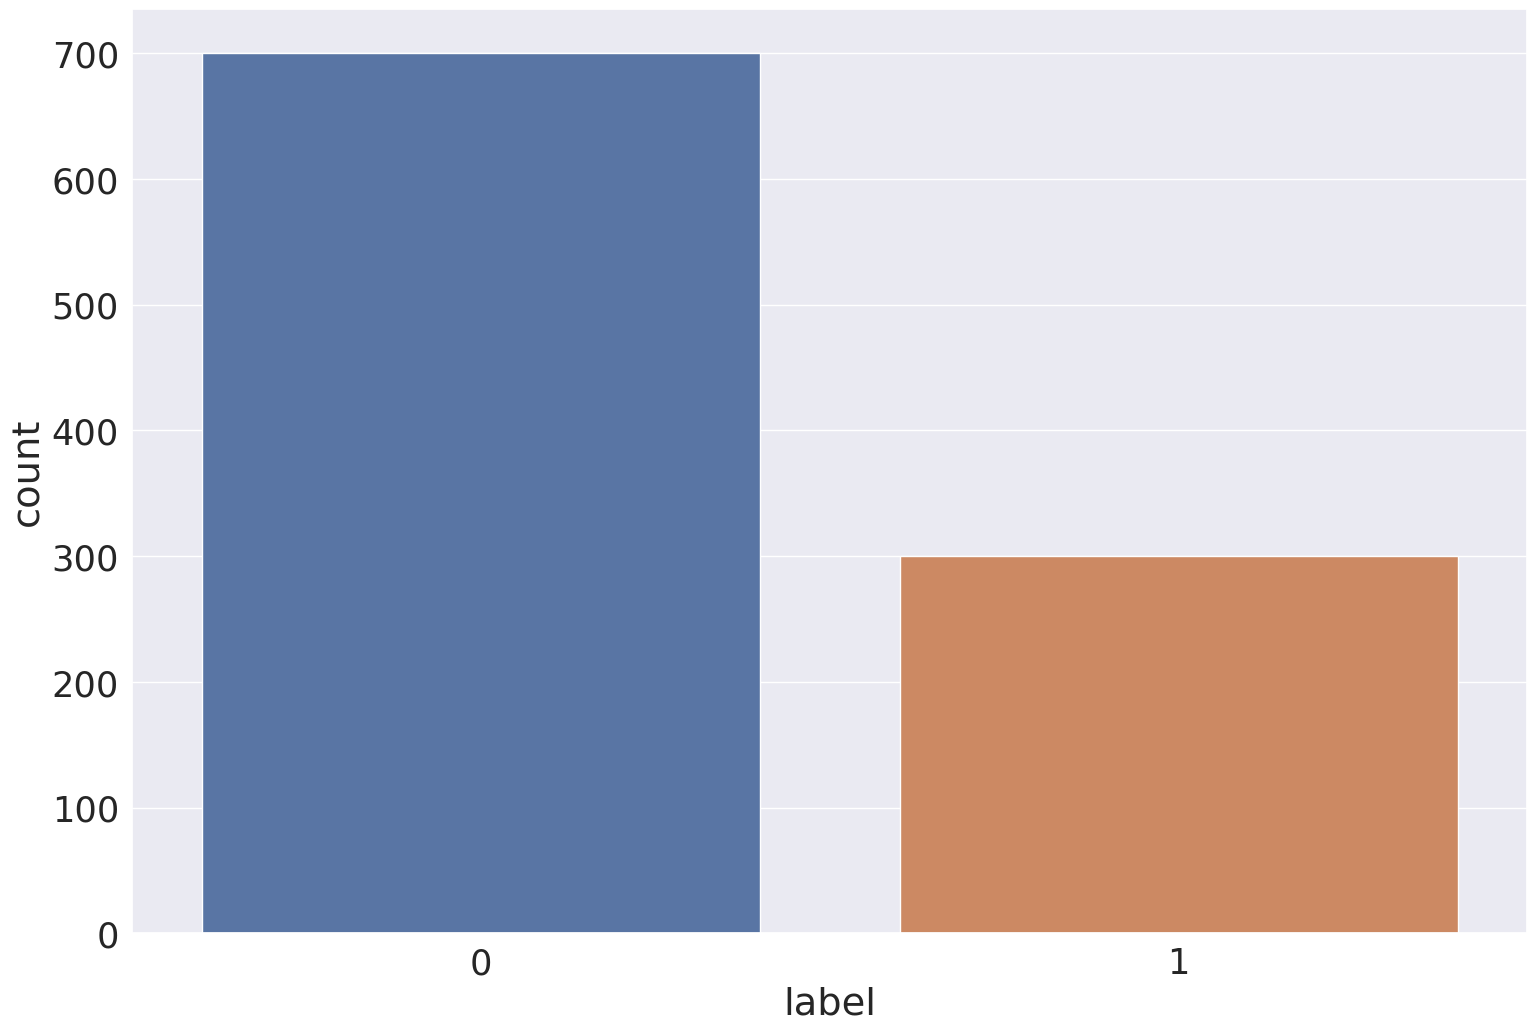

In [ ]:
ax = sns.countplot(x=y)

target_count = data.label.value_counts()
print('Classe 0:', target_count[1])
print('Classe 1:', target_count[2])
print('Proporzione:', round(target_count[1] / target_count[2], 2), ': 1')

In questo caso notiamo una distribuzione 70/30. Non esiste una regola generale, ma di norma si tendono a considerare come fortemente/estremamente sbilanciati dataset in cui la proporzione fra classe maggioritaria e minoritaria è di 100:1/1000:1. In questo caso il dataset potrebbe essere considerato come moderatamente sbilanciato, pertanto non è strettamente necessario intervenire per ridurre lo sbilanciamento.

Le operazioni che, quindi, verranno eseguite di seguito saranno:



*   Split in train/test con proporzione 90/10. Il train set verrà utilizzato per l'addestramento dei modelli, la fase di cross validation e l'ottimizzazione degli iperparametri. Il test set verrà inizialmente messo da parte, in modo da avere un insieme di dati utili a valutare in maniera non distorta le performance dei modelli finali;
*   Valutazione dei modelli sul dataset sbilanciato. I modelli verranno valutati attraverso una procedura di cross validation, utile ad ottenere stime più consistenti, meno influenzate possibile dai dati selezionati per train e validation set;
*   Valutazione dei modelli sul dataset bilanciato. Sempre attraverso una procedura di cross validation, i modelli saranno testati sul dataset bilanciato. Fra le tecniche di bilanciamento esistenti si decide di utilizzare la strategia SMOTE, una delle più popolari tecniche di oversampling. Va sottolineato che, per utilizzare cross validation e oversampling in maniera corretta, i due step saranno inseriti in una pipeline che, ad ogni iterazione della cross validation, applicherà l'algoritmo SMOTE solo alla porzione di dati utilizzata per il training del modello, con il validation set di volta in volta lasciato inalterato, con la distribuzione originale dei dati;
*   Una volta determinato quale dei due precedenti approcci porta ai risultati migliori, verrà applicata una procedura di GridSearchCV per individuare il miglior set di parametri per ciascun modello;
*   Individuato anche il set ottimale di parametri per ciascun modello, i modelli ottimale saranno testati sul test set.

Si inizierà considerando una serie di modelli piuttosto semplici, per poi tentare, alla fine, l'utilizzo di qualche modello più avanzato.


In [ ]:
# Train/Test split, 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=RANDOM_STATE)

# Dimensioni
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('y_train distribution:\n', y_train.value_counts())
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('y_test distribution:\n', y_test.value_counts())

X_train:  (900, 61)
y_train:  (900,)
y_train distribution:
 0    622
1    278
Name: label, dtype: int64
X_test:  (100, 61)
y_test:  (100,)
y_test distribution:
 0    78
1    22
Name: label, dtype: int64


Come detto sopra, 900 dati verranno utilizzati per le varie procedure di cross validation e ottimizzazione, laddove invece i restanti 100 saranno utilizzati alla fine per la valutazione dei modelli. Train e test set sono estratti in maniera stratificata (i.e. mantenendo la distribuzione originale fra le classi).

Come ultima cosa prima di procedere andiamo a standardizzare i valori degli attributi numerici. Questo è necessario per evitare che variabili definite su intervalli differenti finiscano per avere pesi differenti all'interno del modello:

In [ ]:
scale_cols = ['durata', 'valore_credito', 'tasso_rata', 'residenza', 'età', 'n_crediti', 'n_persone']
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.fit_transform(X_test[scale_cols])

### Dataset sbilanciato

Come descritto sopra, eseguiamo una procedura di cross validation in modo da ottenere risultati consistenti per ciascuno dei 6 modelli selezionati. In questa prima fase i parametri dei modelli saranno lasciati al loro valore standard.

In [ ]:
folds = StratifiedKFold(n_splits = 10)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results_dict = {}
results_dict_bal = {}

In [ ]:
# Logistic regression
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_scores = cross_validate(lr, X_train, y_train, cv = folds, scoring=scoring)

print("Logistic regression")
print("Mean accuracy: ", lr_scores['test_accuracy'].mean())
print("Mean precision: ", lr_scores['test_precision'].mean())
print("Mean recall: ", lr_scores['test_recall'].mean())
print("Mean f1: ", lr_scores['test_f1'].mean())
print("Mean roc_auc: ", lr_scores['test_roc_auc'].mean())

results_dict['LR'] = {'Accuracy': lr_scores['test_accuracy'].mean().round(2),
                      'Precision': lr_scores['test_precision'].mean().round(2),
                      'Recall': lr_scores['test_recall'].mean().round(2),
                      'F1': lr_scores['test_f1'].mean().round(2),
                      'ROC_AUC': lr_scores['test_roc_auc'].mean().round(2)}

Logistic regression
Mean accuracy:  0.7522222222222222
Mean precision:  0.6232033074138337
Mean recall:  0.5141534391534391
Mean f1:  0.5604298590056657
Mean roc_auc:  0.8024930780755154


In [ ]:
# Naive Bayes
nb = GaussianNB()
nb_scores = cross_validate(nb, X_train, y_train, cv = folds, scoring=scoring)

print("Naive Bayes")
print("Mean accuracy: ", nb_scores['test_accuracy'].mean())
print("Mean precision: ", nb_scores['test_precision'].mean())
print("Mean recall: ", nb_scores['test_recall'].mean())
print("Mean f1: ", nb_scores['test_f1'].mean())
print("Mean roc_auc: ", nb_scores['test_roc_auc'].mean())

results_dict['NB'] = {'Accuracy': nb_scores['test_accuracy'].mean().round(2),
                      'Precision': nb_scores['test_precision'].mean().round(2),
                      'Recall': nb_scores['test_recall'].mean().round(2),
                      'F1': nb_scores['test_f1'].mean().round(2),
                      'ROC_AUC': nb_scores['test_roc_auc'].mean().round(2)}

Naive Bayes
Mean accuracy:  0.691111111111111
Mean precision:  0.5116275279587973
Mean recall:  0.7371693121693121
Mean f1:  0.5994588315148189
Mean roc_auc:  0.7565080313288199


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_scores = cross_validate(dt, X_train, y_train, cv = folds, scoring=scoring)

print("Decision Tree")
print("Mean accuracy: ", dt_scores['test_accuracy'].mean())
print("Mean precision: ", dt_scores['test_precision'].mean())
print("Mean recall: ", dt_scores['test_recall'].mean())
print("Mean f1: ", dt_scores['test_f1'].mean())
print("Mean roc_auc: ", dt_scores['test_roc_auc'].mean())

results_dict['DT'] = {'Accuracy': dt_scores['test_accuracy'].mean().round(2),
                      'Precision': dt_scores['test_precision'].mean().round(2),
                      'Recall': dt_scores['test_recall'].mean().round(2),
                      'F1': dt_scores['test_f1'].mean().round(2),
                      'ROC_AUC': dt_scores['test_roc_auc'].mean().round(2)}

Decision Tree
Mean accuracy:  0.6511111111111111
Mean precision:  0.4390488319923803
Mean recall:  0.4498677248677249
Mean f1:  0.4420145705165409
Mean roc_auc:  0.5955047789725209


In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_scores = cross_validate(rf, X_train, y_train, cv = folds, scoring=scoring)

print("Random Forest")
print("Mean accuracy: ", rf_scores['test_accuracy'].mean())
print("Mean precision: ", rf_scores['test_precision'].mean())
print("Mean recall: ", rf_scores['test_recall'].mean())
print("Mean f1: ", rf_scores['test_f1'].mean())
print("Mean roc_auc: ", rf_scores['test_roc_auc'].mean())

results_dict['RF'] = {'Accuracy': rf_scores['test_accuracy'].mean().round(2),
                      'Precision': rf_scores['test_precision'].mean().round(2),
                      'Recall': rf_scores['test_recall'].mean().round(2),
                      'F1': rf_scores['test_f1'].mean().round(2),
                      'ROC_AUC': rf_scores['test_roc_auc'].mean().round(2)}

Random Forest
Mean accuracy:  0.7488888888888889
Mean precision:  0.6510764849185902
Mean recall:  0.4208994708994709
Mean f1:  0.5050949692367313
Mean roc_auc:  0.7915141235705752


In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 4)
knn_scores = cross_validate(knn, X_train, y_train, cv = folds, scoring=scoring)

print("KNN")
print("Mean accuracy: ", knn_scores['test_accuracy'].mean())
print("Mean precision: ", knn_scores['test_precision'].mean())
print("Mean recall: ", knn_scores['test_recall'].mean())
print("Mean f1: ", knn_scores['test_f1'].mean())
print("Mean roc_auc: ", knn_scores['test_roc_auc'].mean())

results_dict['KNN'] = {'Accuracy': knn_scores['test_accuracy'].mean().round(2),
                      'Precision': knn_scores['test_precision'].mean().round(2),
                      'Recall': knn_scores['test_recall'].mean().round(2),
                      'F1': knn_scores['test_f1'].mean().round(2),
                      'ROC_AUC': knn_scores['test_roc_auc'].mean().round(2)}

KNN
Mean accuracy:  0.7155555555555555
Mean precision:  0.6251398601398601
Mean recall:  0.2011904761904762
Mean f1:  0.30045209275670653
Mean roc_auc:  0.7004585774971079


In [ ]:
# SVM
svm = SVC(random_state = RANDOM_STATE)
svm_scores = cross_validate(svm, X_train, y_train, cv = folds, scoring=scoring)

print("KNN")
print("Mean accuracy: ", svm_scores['test_accuracy'].mean())
print("Mean precision: ", svm_scores['test_precision'].mean())
print("Mean recall: ", svm_scores['test_recall'].mean())
print("Mean f1: ", svm_scores['test_f1'].mean())
print("Mean roc_auc: ", svm_scores['test_roc_auc'].mean())

results_dict['SVM'] = {'Accuracy': svm_scores['test_accuracy'].mean().round(2),
                      'Precision': svm_scores['test_precision'].mean().round(2),
                      'Recall': svm_scores['test_recall'].mean().round(2),
                      'F1': svm_scores['test_f1'].mean().round(2),
                      'ROC_AUC': svm_scores['test_roc_auc'].mean().round(2)}

KNN
Mean accuracy:  0.7533333333333333
Mean precision:  0.6576346391826268
Mean recall:  0.41693121693121693
Mean f1:  0.5078448560822025
Mean roc_auc:  0.7989114562591265


In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,Accuracy,Precision,Recall,F1,ROC_AUC
LR,0.75,0.62,0.51,0.56,0.80
NB,0.69,0.51,0.74,0.60,0.76
DT,0.65,0.44,0.45,0.44,0.60
RF,0.75,0.65,0.42,0.51,0.79
KNN,0.72,0.63,0.20,0.30,0.70
SVM,0.75,0.66,0.42,0.51,0.80


In [ ]:
results_df.to_csv('dataset_sbilanciato.csv')

### Dataset bilanciato

Vogliamo valutare l'effetto del bilanciamento del dataset sulle metriche dei vari modelli. Come citato in precedenza, per effettuare correttamente l'oversampling nel contesto di una cross validation è necessario utilizzare una pipeline che bilanci di volta in volta solamente il training set. Per fare ciò, sfrutterò la libreria `imblearn`.

In [ ]:
lr_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                            LogisticRegression(random_state=RANDOM_STATE))
nb_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                            GaussianNB())
dt_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                            DecisionTreeClassifier(random_state=RANDOM_STATE))
rf_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                            RandomForestClassifier(random_state=RANDOM_STATE))
knn_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                             KNeighborsClassifier(n_neighbors = 4))
svm_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                             SVC(random_state = RANDOM_STATE))

In [ ]:
# Logistic regression
lr_scores_bal = cross_validate(lr_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("Logistic regression")
print("Mean accuracy: ", lr_scores_bal['test_accuracy'].mean())
print("Mean precision: ", lr_scores_bal['test_precision'].mean())
print("Mean recall: ", lr_scores_bal['test_recall'].mean())
print("Mean f1: ", lr_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", lr_scores_bal['test_roc_auc'].mean())

results_dict_bal['LR'] = {'Accuracy': lr_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': lr_scores_bal['test_precision'].mean().round(2),
                      'Recall': lr_scores_bal['test_recall'].mean().round(2),
                      'F1': lr_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': lr_scores_bal['test_roc_auc'].mean().round(2)}

Logistic regression
Mean accuracy:  0.7544444444444445
Mean precision:  0.6207729191461115
Mean recall:  0.5538359788359788
Mean f1:  0.5812756140955553
Mean roc_auc:  0.8025013749028087


In [ ]:
# Naive Bayes
nb_scores_bal = cross_validate(nb_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("Naive Bayes")
print("Mean accuracy: ", nb_scores_bal['test_accuracy'].mean())
print("Mean precision: ", nb_scores_bal['test_precision'].mean())
print("Mean recall: ", nb_scores_bal['test_recall'].mean())
print("Mean f1: ", nb_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", nb_scores_bal['test_roc_auc'].mean())

results_dict_bal['NB'] = {'Accuracy': nb_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': nb_scores_bal['test_precision'].mean().round(2),
                      'Recall': nb_scores_bal['test_recall'].mean().round(2),
                      'F1': nb_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': nb_scores_bal['test_roc_auc'].mean().round(2)}

Naive Bayes
Mean accuracy:  0.6711111111111111
Mean precision:  0.4830696042611759
Mean recall:  0.6794973544973545
Mean f1:  0.5607427523728672
Mean roc_auc:  0.7165320210123077


In [ ]:
# Decision Tree
dt_scores_bal = cross_validate(dt_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("Decision Tree")
print("Mean accuracy: ", dt_scores_bal['test_accuracy'].mean())
print("Mean precision: ", dt_scores_bal['test_precision'].mean())
print("Mean recall: ", dt_scores_bal['test_recall'].mean())
print("Mean f1: ", dt_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", dt_scores_bal['test_roc_auc'].mean())

results_dict_bal['DT'] = {'Accuracy': dt_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': dt_scores_bal['test_precision'].mean().round(2),
                      'Recall': dt_scores_bal['test_recall'].mean().round(2),
                      'F1': dt_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': dt_scores_bal['test_roc_auc'].mean().round(2)}

Decision Tree
Mean accuracy:  0.7
Mean precision:  0.5181523583727583
Mean recall:  0.5862433862433862
Mean f1:  0.5471230343210746
Mean roc_auc:  0.6685313193377709


In [ ]:
# Random Forest
rf_scores_bal = cross_validate(rf_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("Random Forest")
print("Mean accuracy: ", rf_scores_bal['test_accuracy'].mean())
print("Mean precision: ", rf_scores_bal['test_precision'].mean())
print("Mean recall: ", rf_scores_bal['test_recall'].mean())
print("Mean f1: ", rf_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", rf_scores_bal['test_roc_auc'].mean())

results_dict_bal['RF'] = {'Accuracy': rf_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': rf_scores_bal['test_precision'].mean().round(2),
                      'Recall': rf_scores_bal['test_recall'].mean().round(2),
                      'F1': rf_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': rf_scores_bal['test_roc_auc'].mean().round(2)}

Random Forest
Mean accuracy:  0.7488888888888889
Mean precision:  0.6104491254733336
Mean recall:  0.5425925925925925
Mean f1:  0.5701025376475822
Mean roc_auc:  0.7928467125599742


In [ ]:
# KNN
knn_scores_bal = cross_validate(knn_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("KNN")
print("Mean accuracy: ", knn_scores_bal['test_accuracy'].mean())
print("Mean precision: ", knn_scores_bal['test_precision'].mean())
print("Mean recall: ", knn_scores_bal['test_recall'].mean())
print("Mean f1: ", knn_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", knn_scores_bal['test_roc_auc'].mean())

results_dict_bal['KNN'] = {'Accuracy': knn_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': knn_scores_bal['test_precision'].mean().round(2),
                      'Recall': knn_scores_bal['test_recall'].mean().round(2),
                      'F1': knn_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': knn_scores_bal['test_roc_auc'].mean().round(2)}

KNN
Mean accuracy:  0.6944444444444444
Mean precision:  0.5034619666474505
Mean recall:  0.5251322751322751
Mean f1:  0.5114801627744832
Mean roc_auc:  0.7051597968936679


In [ ]:
# SVM
svm_scores_bal = cross_validate(svm_pipeline, X_train, y_train, cv = folds, scoring=scoring)

print("SVM")
print("Mean accuracy: ", svm_scores_bal['test_accuracy'].mean())
print("Mean precision: ", svm_scores_bal['test_precision'].mean())
print("Mean recall: ", svm_scores_bal['test_recall'].mean())
print("Mean f1: ", svm_scores_bal['test_f1'].mean())
print("Mean roc_auc: ", svm_scores_bal['test_roc_auc'].mean())

results_dict_bal['SVM'] = {'Accuracy': svm_scores_bal['test_accuracy'].mean().round(2),
                      'Precision': svm_scores_bal['test_precision'].mean().round(2),
                      'Recall': svm_scores_bal['test_recall'].mean().round(2),
                      'F1': svm_scores_bal['test_f1'].mean().round(2),
                      'ROC_AUC': svm_scores_bal['test_roc_auc'].mean().round(2)}

SVM
Mean accuracy:  0.7566666666666666
Mean precision:  0.6237688966806614
Mean recall:  0.5285714285714286
Mean f1:  0.5698440387683444
Mean roc_auc:  0.8006649314445013


In [ ]:
results_df_bal = pd.DataFrame.from_dict(results_dict_bal, orient='index')
results_df_bal

,Accuracy,Precision,Recall,F1,ROC_AUC
LR,0.75,0.62,0.55,0.58,0.80
NB,0.67,0.48,0.68,0.56,0.72
DT,0.70,0.52,0.59,0.55,0.67
RF,0.75,0.61,0.54,0.57,0.79
KNN,0.69,0.50,0.53,0.51,0.71
SVM,0.76,0.62,0.53,0.57,0.80


In [ ]:
results_df_bal.to_csv('dataset_bilanciato.csv')

### Conclusioni

In [ ]:
total_results = results_df.assign(Accuracy_Bal=results_df_bal['Accuracy'], Precision_Bal=results_df_bal['Precision'], Recall_Bal=results_df_bal['Recall'], F1_Bal=results_df_bal['F1'],
                                  ROC_AUC_Bal=results_df_bal['ROC_AUC'])
total_results = total_results[['Accuracy', 'Accuracy_Bal', 'Precision', 'Precision_Bal', 'Recall', 'Recall_Bal', 'F1', 'F1_Bal', 'ROC_AUC', 'ROC_AUC_Bal']]
total_results

,Accuracy,Accuracy_Bal,Precision,Precision_Bal,Recall,Recall_Bal,F1,F1_Bal,ROC_AUC,ROC_AUC_Bal
LR,0.75,0.75,0.62,0.62,0.51,0.55,0.56,0.58,0.80,0.80
NB,0.69,0.67,0.51,0.48,0.74,0.68,0.60,0.56,0.76,0.72
DT,0.65,0.70,0.44,0.52,0.45,0.59,0.44,0.55,0.60,0.67
RF,0.75,0.75,0.65,0.61,0.42,0.54,0.51,0.57,0.79,0.79
KNN,0.72,0.69,0.63,0.50,0.20,0.53,0.30,0.51,0.70,0.71
SVM,0.75,0.76,0.66,0.62,0.42,0.53,0.51,0.57,0.80,0.80


In [ ]:
total_results.to_csv('risultati_class_nohyper.csv')

Ad eccezione del Naive Bayes, tutti i modelli beneficiano del bilanciamento del dataset, specialmente in termini di recall. Considerando che, come verrà specificato in seguito, il nostro obiettivo sarà proprio quello di massimizzare la recall sul test set, è opportuno proseguire utilizzando un training set bilanciato. Quindi, ora, proseguiamo su questa strada andando ad ottimizzare i parametri di ciascuno dei precedenti 6 modelli.

### Ottimizzazione degli iperparametri

A questo punto non resta che cercare di migliorare ulteriormente i risultati dei modelli tramite l'individuazione del set ottimale di parametri per ciascuno di essi. Lavorerò sul dataset bilanciato, utilizzando lo stesso procedimento seguito in precedenza. In questo caso, però, verrà utilizzata una GridSearchCV per la ricerca della combinazione migliore di parametri.

Per la scelta del set ottimale ci si baserà sulla metrica di recall. Questo deriva dalla tipologia di variabile che stiamo andando a prevedere. Il "rischio di credito" può essere definito come il rischio che nell'ambito di un'operazione creditizia il debitore non assolva anche solo in parte ai suoi obblighi di rimborso del capitale e/o al pagamento degli interessi al suo creditore. Per questo motivo, il nostro interesse è prevalentemente quello di classificare correttamente debitori con una cattiva reputazione, così da evitare che un ipotetico creditore possa perdere del capitale con persone erroneamente giudicate buoni creditori. Questo approccio ha un principale svantaggio, dato dal rischio di avere un alto numero di falsi positivi, compromettendo quindi i valori di precision. In una situazione ideale, avendo a disposizione delle informazioni più precise del dominio di riferimento, si potrebbe pensare di costruire una matrice di costo ad hoc che attribuisca errori diversi a falsi positivi e falsi negativi. Adottare una metodologia cost-sensitive, con i vari modelli addestrati per minimizzare il costo totale complessivo, risulta infatti una soluzione molto utilizzata in ambito economico.

In [ ]:
# SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

print("Prima/dopo bilanciamento")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

Prima/dopo bilanciamento
{0: 622, 1: 278}
{0: 622, 1: 622}


##### Logistic regression

In [ ]:
lr_parameters = {'logisticregression__penalty' : ['l1', 'l2', 'elasticnet'],
                 'logisticregression__C' : np.logspace(-3, 3, 15),
                 'logisticregression__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
                 'logisticregression__max_iter' : [100, 150, 200]}

In [ ]:
lr_grid_search = GridSearchCV(lr_pipeline, param_grid=lr_parameters, cv=folds, scoring='recall',
                              return_train_score=True)

In [ ]:
lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=4623))]),
             param_grid={'logisticregression__C': array([1.00000000e-03, 2.68269580e-03, 7.19685673e-03, 1.93069773e-02,
       5.17947468e-02, 1.38949549e-01, 3.72759372e-01, 1.00000000e+00,
       2.68269580e+00, 7.19685673e+00, 1.93069773e+01, 5.17947468e+01,
       1.38949549e+02, 3.72759372e+02, 1.00000000e+03]),
                         'logisticregression__max_iter': [100, 150, 200],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['lbfgs', 'newton-cg',
                                                        'liblinear', 'sag',
                                                        'saga']},
             return_train_score=True, scoring='recall')

In [ ]:
print(lr_grid_search.best_params_)
print(lr_grid_search.best_score_)

{'logisticregression__C': 0.019306977288832496, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
0.8058201058201059


In [ ]:
m1 = 'Logistic Regression'
lr = LogisticRegression(penalty=lr_grid_search.best_params_['logisticregression__penalty'], solver=lr_grid_search.best_params_['logisticregression__solver'],
                        C=lr_grid_search.best_params_['logisticregression__C'], max_iter=lr_grid_search.best_params_['logisticregression__max_iter'])

# Fit
model_lr = lr.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predict_lr_train = model_lr.predict(X_train_balanced)
predict_lr = model_lr.predict(X_test)

# Performance train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predict_lr_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predict_lr))
acc_LR, prec_LR, rec_LR, f1_LR, roc_LR, cm_LR  = performance(y_test, predict_lr)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.83      0.58      0.68       622
           1       0.68      0.88      0.77       622

    accuracy                           0.73      1244
   macro avg       0.75      0.73      0.73      1244
weighted avg       0.75      0.73      0.73      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.88      0.59      0.71        78
           1       0.33      0.73      0.46        22

    accuracy                           0.62       100
   macro avg       0.61      0.66      0.58       100
weighted avg       0.76      0.62      0.65       100



##### Naive Bayes

In [ ]:
nb_parameters = {'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)}

In [ ]:
nb_grid_search = GridSearchCV(nb_pipeline, param_grid=nb_parameters, cv=folds, scoring='recall',
                              return_train_score=True)

In [ ]:
nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={'gaussiannb__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01,...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             return_train_score=True, scoring='recall')

In [ ]:
print(nb_grid_search.best_params_)
print(nb_grid_search.best_score_)

{'gaussiannb__var_smoothing': 0.23101297000831597}
0.8523809523809524


In [ ]:
m2 = 'Naive Bayes'
nb = GaussianNB(var_smoothing=nb_grid_search.best_params_['gaussiannb__var_smoothing'])

# Fit
model_nb = nb.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predict_nb_train = model_nb.predict(X_train_balanced)
predict_nb = model_nb.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predict_nb_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predict_nb))
acc_NB, prec_NB, rec_NB, f1_NB, roc_NB, cm_NB  = performance(y_test, predict_nb)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.90      0.57      0.70       622
           1       0.69      0.94      0.79       622

    accuracy                           0.75      1244
   macro avg       0.79      0.75      0.75      1244
weighted avg       0.79      0.75      0.75      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.80      0.46      0.59        78
           1       0.24      0.59      0.34        22

    accuracy                           0.49       100
   macro avg       0.52      0.53      0.46       100
weighted avg       0.68      0.49      0.53       100



##### Decision Tree

In [ ]:
dt_parameters = {'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                 'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
                 'decisiontreeclassifier__criterion': ["gini", "entropy"]}

In [ ]:
dt_grid_search = GridSearchCV(dt_pipeline, param_grid=dt_parameters, cv=folds, scoring='recall',
                              return_train_score=True)

In [ ]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=4623))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             return_train_score=True, scoring='recall')

In [ ]:
print(dt_grid_search.best_params_)
print(dt_grid_search.best_score_)

{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_leaf': 20}
0.7878306878306878


In [ ]:
m3 = 'Decision Tree'
# dt = DecisionTreeClassifier(criterion=dt_grid_search.best_params_['decisiontreeclassifier__criterion'], max_depth=dt_grid_search.best_params_['decisiontreeclassifier__max_depth'],
#                             min_samples_leaf=dt_grid_search.best_params_['decisiontreeclassifier__min_samples_leaf'])
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=20, random_state=RANDOM_STATE)

# Fit
model_dt = dt.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predict_dt_train = model_dt.predict(X_train_balanced)
predicted_dt = model_dt.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predict_dt_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_dt))
acc_DT, prec_DT, rec_DT, f1_DT, roc_DT, cm_DT  = performance(y_test, predicted_dt)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.83      0.66      0.73       622
           1       0.72      0.87      0.78       622

    accuracy                           0.76      1244
   macro avg       0.77      0.76      0.76      1244
weighted avg       0.77      0.76      0.76      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.83      0.51      0.63        78
           1       0.27      0.64      0.38        22

    accuracy                           0.54       100
   macro avg       0.55      0.57      0.51       100
weighted avg       0.71      0.54      0.58       100



##### Random Forest

In [ ]:
rf_parameters = {'randomforestclassifier__n_estimators': [5, 20, 50, 100, 200],
                 'randomforestclassifier__max_depth': [int(x) for x in np.linspace(5, 120, num = 12)],
                 'randomforestclassifier__min_samples_split': [4, 8, 10, 12],
                 'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
                 'randomforestclassifier__bootstrap': [True]}

In [ ]:
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_parameters, cv=folds, scoring='recall',
                              return_train_score=True)

In [ ]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=4623))]),
             param_grid={'randomforestclassifier__bootstrap': [True],
                         'randomforestclassifier__max_depth': [5, 15, 25, 36,
                                                               46, 57, 67, 78,
                                                               88, 99, 109,
                                                               120],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5],
                         'randomforestclassifier__min_samples_split': [4, 8, 10,
                                                                       12],
                         'randomforestclassifier__n_estimators': [5, 20, 50,
                                                                  100, 200]},
             return_train_score=True, scoring='recall')

In [ ]:
print(rf_grid_search.best_params_)
print(rf_grid_search.best_score_)

{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 20}
0.7011904761904761


In [ ]:
m4 = 'Random Forest Classfier'
rf = RandomForestClassifier(bootstrap=rf_grid_search.best_params_['randomforestclassifier__bootstrap'], max_depth=rf_grid_search.best_params_['randomforestclassifier__max_depth'],
                            min_samples_leaf=rf_grid_search.best_params_['randomforestclassifier__min_samples_leaf'],
                            min_samples_split=rf_grid_search.best_params_['randomforestclassifier__min_samples_split'], n_estimators=rf_grid_search.best_params_['randomforestclassifier__n_estimators'])

# Fit
model_rf = rf.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predict_df_train = model_rf.predict(X_train_balanced)
predicted_rf = model_rf.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predict_df_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_rf))
acc_RF, prec_RF, rec_RF, f1_RF, roc_RF, cm_RF  = performance(y_test, predicted_rf)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       622
           1       0.81      0.91      0.86       622

    accuracy                           0.85      1244
   macro avg       0.85      0.85      0.85      1244
weighted avg       0.85      0.85      0.85      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.85      0.64      0.73        78
           1       0.32      0.59      0.41        22

    accuracy                           0.63       100
   macro avg       0.58      0.62      0.57       100
weighted avg       0.73      0.63      0.66       100



##### KNN

In [ ]:
knn_parameters = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20],
                 'kneighborsclassifier__weights': ['uniform','distance'],
                 'kneighborsclassifier__metric': ['minkowski','euclidean','manhattan']}

In [ ]:
knn_grid_search = GridSearchCV(knn_pipeline, param_grid=knn_parameters, cv=folds, scoring='recall',
                               return_train_score=True)

In [ ]:
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=4))]),
             param_grid={'kneighborsclassifier__metric': ['minkowski',
                                                          'euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7,
                                                               8, 9, 10, 12, 15,
                                                               18, 20],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             return_train_score=True, scoring='recall')

In [ ]:
print(knn_grid_search.best_params_)
print(knn_grid_search.best_score_)

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
0.7661375661375662


In [ ]:
m5 = 'KNN'
knn = KNeighborsClassifier(metric=knn_grid_search.best_params_['kneighborsclassifier__metric'], n_neighbors=knn_grid_search.best_params_['kneighborsclassifier__n_neighbors'],
                           weights=knn_grid_search.best_params_['kneighborsclassifier__weights'])

# Fit
model_knn = knn.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predict_knn_train = model_knn.predict(X_train_balanced)
predicted_knn = model_knn.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predict_knn_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_knn))
acc_KNN, prec_KNN, rec_KNN, f1_KNN, roc_KNN, cm_KNN  = performance(y_test, predicted_knn)

Perfomance sul train set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       1.00      1.00      1.00       622

    accuracy                           1.00      1244
   macro avg       1.00      1.00      1.00      1244
weighted avg       1.00      1.00      1.00      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.89      0.54      0.67        78
           1       0.32      0.77      0.45        22

    accuracy                           0.59       100
   macro avg       0.61      0.66      0.56       100
weighted avg       0.77      0.59      0.62       100



##### SVM

In [ ]:
svm_parameters = {'svc__C': [0.1, 1, 10, 100],
                 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                 'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [ ]:
svm_grid_search = GridSearchCV(svm_pipeline, param_grid=svm_parameters, cv=folds, scoring='recall',
                               return_train_score=True)

In [ ]:
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('svc', SVC(random_state=4623))]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='recall')

In [ ]:
print(svm_grid_search.best_params_)
print(svm_grid_search.best_score_)

{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}
0.683068783068783


In [ ]:
m6 = 'SVM'
svm = SVC(C=svm_grid_search.best_params_['svc__C'], gamma=svm_grid_search.best_params_['svc__gamma'], kernel=svm_grid_search.best_params_['svc__kernel'])

# Fit
model_svm = svm.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predicted_svm_train = model_svm.predict(X_train_balanced)
predicted_svm = model_svm.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predicted_svm_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_svm))
acc_SVM, prec_SVM, rec_SVM, f1_SVM, roc_SVM, cm_SVM  = performance(y_test, predicted_svm)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.89      0.76      0.82       622
           1       0.79      0.91      0.85       622

    accuracy                           0.83      1244
   macro avg       0.84      0.83      0.83      1244
weighted avg       0.84      0.83      0.83      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.83      0.64      0.72        78
           1       0.30      0.55      0.39        22

    accuracy                           0.62       100
   macro avg       0.57      0.59      0.56       100
weighted avg       0.72      0.62      0.65       100



#### Comparison fra modelli

In [ ]:
nomi_modelli = [m1, m2, m3, m4, m5, m6]
cm_list = [cm_LR, cm_NB, cm_DT, cm_RF, cm_KNN, cm_SVM]
pred_list = [predict_lr, predict_nb, predicted_dt, predicted_rf, predicted_knn, predicted_svm]
recall_values = [rec_LR, rec_NB, rec_DT, rec_RF, rec_KNN, rec_SVM]
prec_values = [prec_LR, prec_NB, prec_DT, prec_RF, prec_KNN, prec_SVM]
acc_values = [acc_LR, acc_NB, acc_DT, acc_RF, acc_KNN, acc_SVM]
f1_values = [f1_LR, f1_NB, f1_DT, f1_RF, f1_KNN, f1_SVM]
roc_values = [roc_LR, roc_NB, roc_DT, roc_RF, roc_KNN, roc_SVM]

################################################################################

df_results = pd.DataFrame(list(zip(nomi_modelli, recall_values, prec_values, acc_values, f1_values, roc_values)),
               columns =['Name', 'Recall', 'Precision', 'Accuracy', 'F1', 'ROC value'])
df_results = df_results.set_index(df_results['Name'])
df_results = df_results[['Recall', 'Precision', 'Accuracy', 'F1', 'ROC value']]
df_results = df_results.astype(float)
df_results = np.round(df_results, 2)
df_results.sort_values(by='Recall' , ascending = False)

,Recall,Precision,Accuracy,F1,ROC value
Name,,,,,
KNN,0.77,0.32,0.59,0.45,0.66
Logistic Regression,0.73,0.33,0.62,0.46,0.66
Decision Tree,0.64,0.27,0.54,0.38,0.57
Naive Bayes,0.59,0.24,0.49,0.34,0.53
Random Forest Classfier,0.59,0.32,0.63,0.41,0.62
SVM,0.55,0.30,0.62,0.39,0.59


In [ ]:
df_results.to_csv('optim_results.csv')

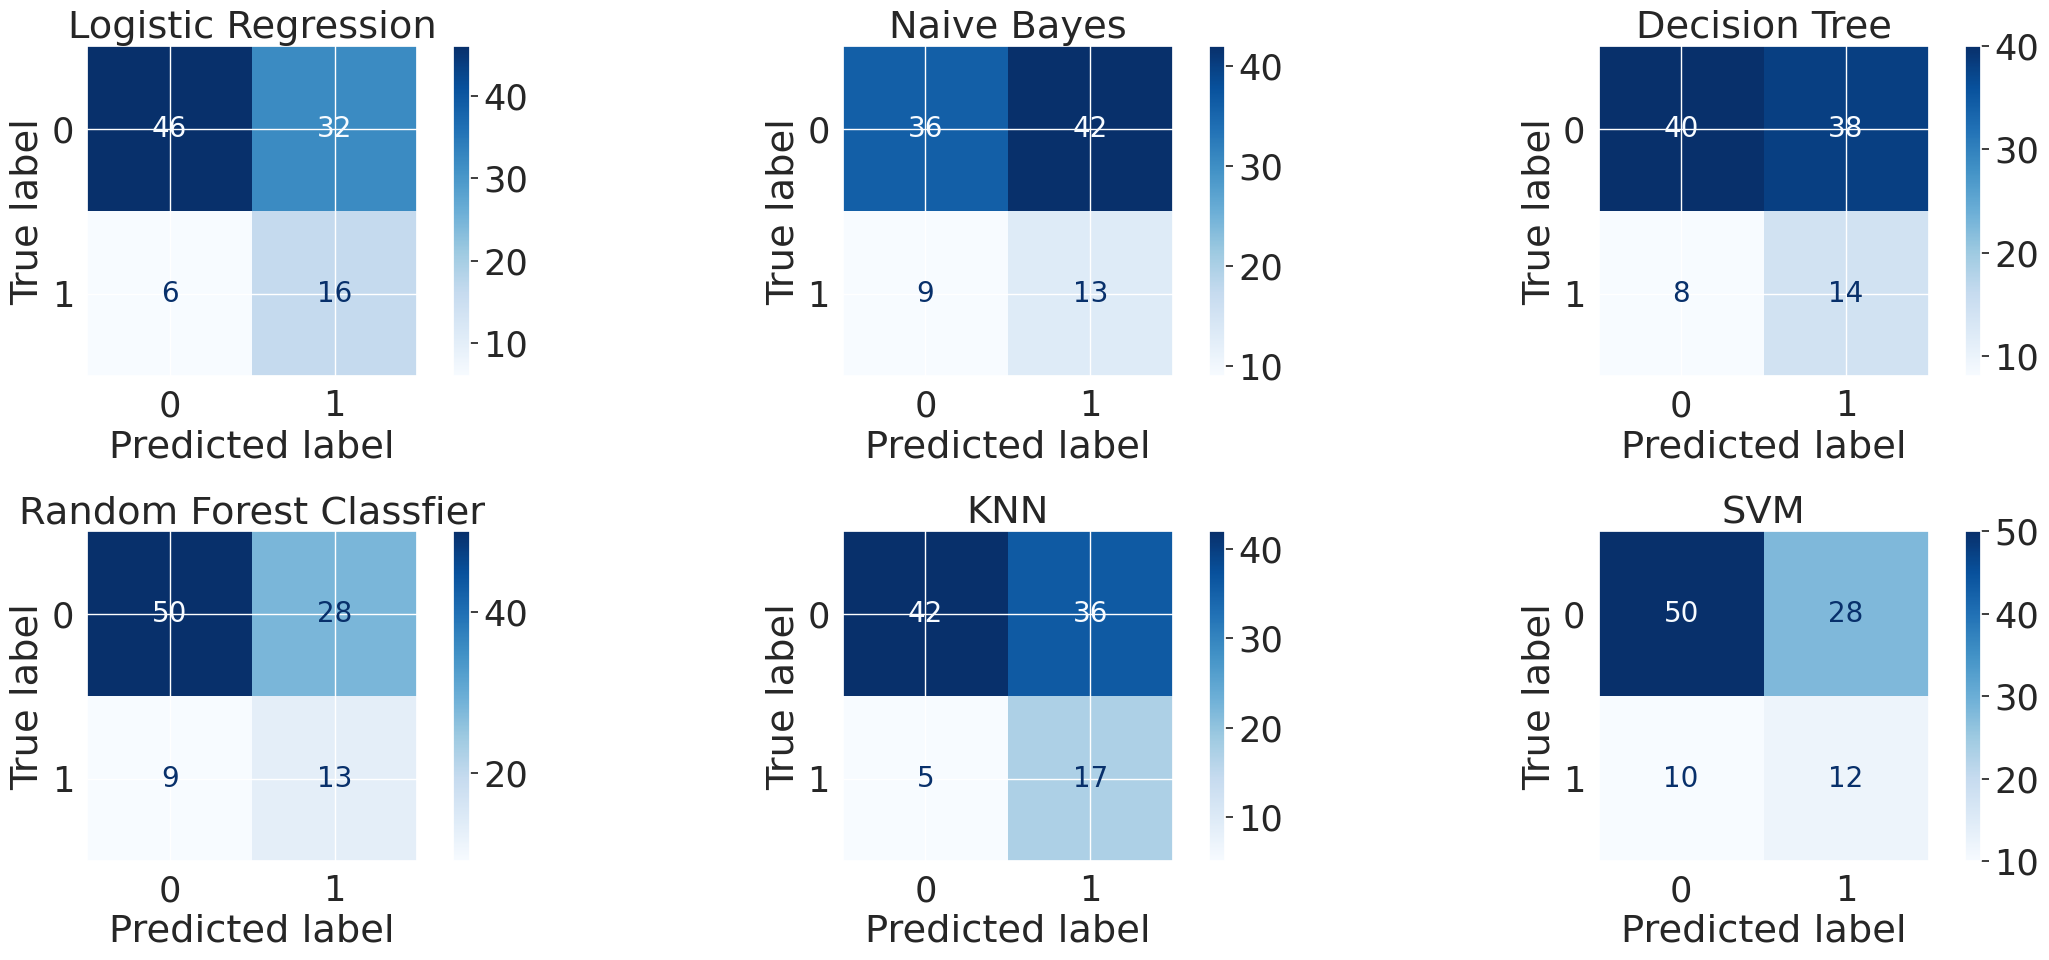

In [ ]:
plot_conf_matrix(nomi_modelli, cm_list, nrows=2, ncols=3, fig_a=23, fig_b=10)

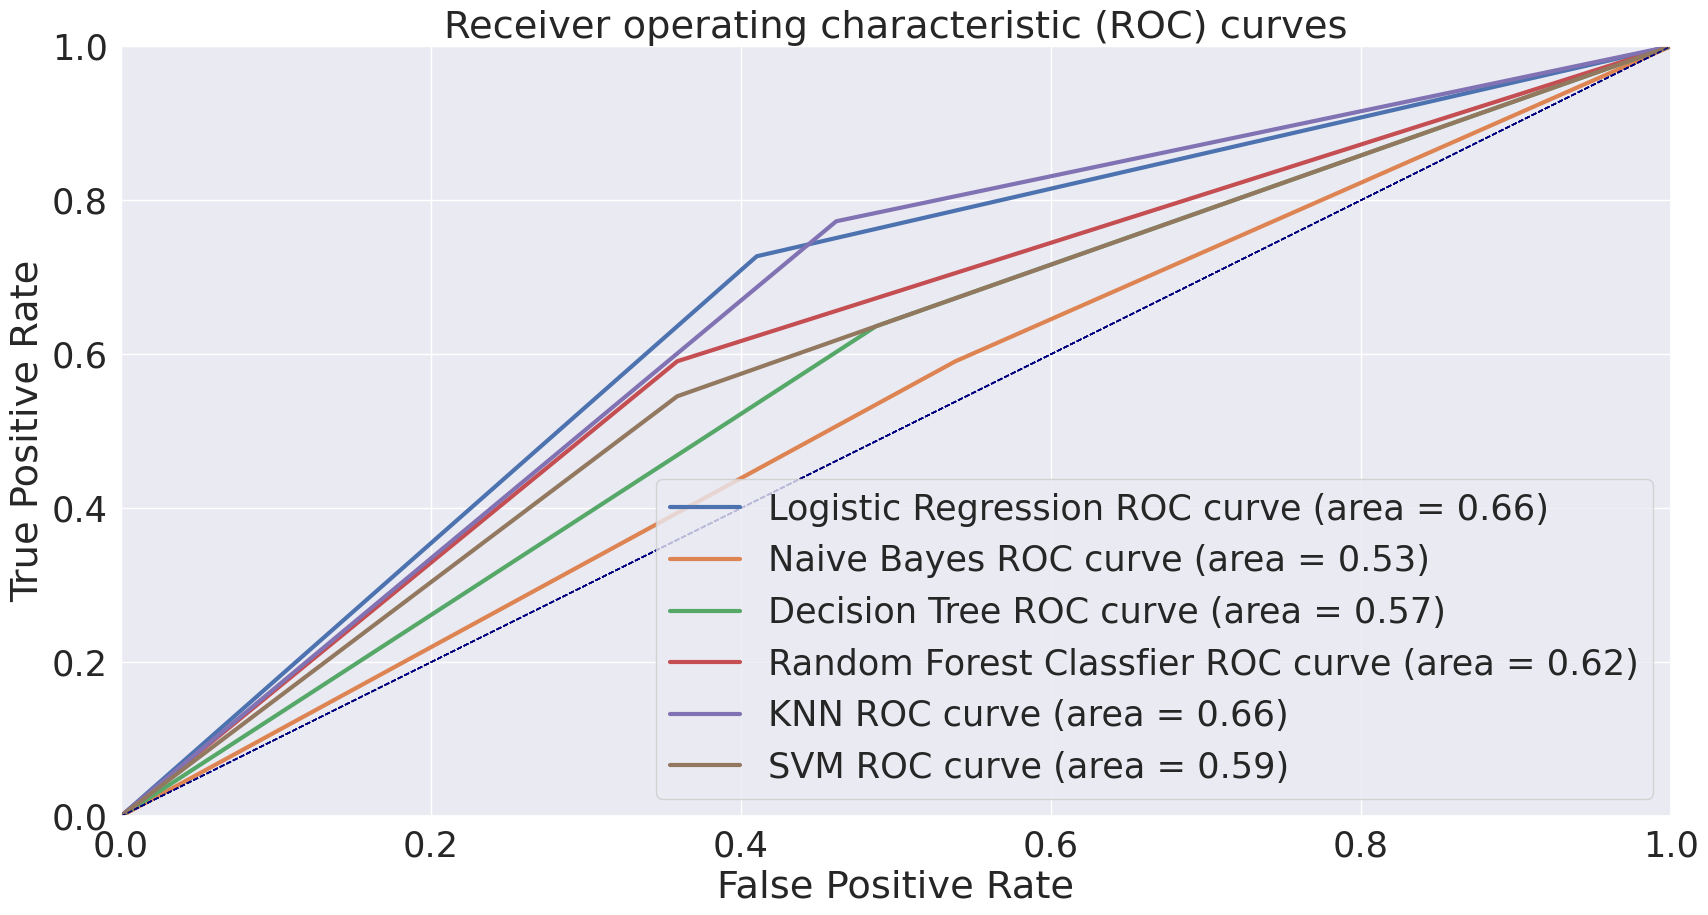

In [ ]:
roc_auc_curve(nomi_modelli, pred_list, y_test)

Come si può notare, l'ottimizzazione degli iperparametri porta ad un ulteriore aumento dei valori di recall. Tuttavia, come accennato in precedenza, forzando i modelli ad ottimizzare tale metrica, essi si concentrano fortemente sulla classe minoritaria, portando ad un incremento dei falsi positivi e, di conseguenza, ad una precision inferiore. Chiaramente, questo influenza anche i valori di ROC-AUC, anch'essi inferiori rispetto ai modelli non ottimizzati. In ogni caso, in questo specifico ambito di studio, sembra consono privilegiare la recall rispetto alla precision, proprio per il fatto che un'errata classificazione di un cattivo debitore è molto più dannosa rispetto all'errata classificazione di un buon debitore. Tale ragionamento si basa proprio sul fatto che nel primo caso il costo associato all'errore sarebbe quello del mancato rimborso del capitale/mancato pagamento degli interessi, mentre nel secondo caso il costo associato all'errore sarebbe quello di un ipotetico controllo ulteriore sullo stato del debitore. Ovviamente questo approccio ha proprio lo svantaggio di avere valori di precision mediocri, e per questo, avendo a disposizione informazioni aggiuntive sul costo associato ai diversi errori, la soluzione ideale sarebbe quella di ottimizzare i modelli proprio per minimizzare il costo, piuttosto che concentrarsi sulle metriche fin qui considerate.

### Altri modelli

Come ultimo tentativo si valuta l'utilizzo di alcuni modelli più complessi, per verificare qualora possano essere una valida soluzione per la previsione della variabile target. I modelli valutati sono `XGBoost`, `ADABoost` e `GradientBoosting`. Sulla base di quanto mostrato in precedenza, anche in questo caso si decide di usare il dataset bilanciato. Si procede direttamente con l'ottimizzazione degli iperparametri.

#### XGBoost

In [ ]:
xgb_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                             XGBClassifier(random_state=RANDOM_STATE))

In [ ]:
xgb_parameters = {
    'xgbclassifier__objective': ["binary:logistic"],
    'xgbclassifier__learning_rate': [0.005, 0.05, 0.1, 0.5],
    'xgbclassifier__colsample_bytree': [0.2, 0.3, 0.4, 0.5],
    'xgbclassifier__gamma': [0.1, 0.2, 0.3, 0.4],
    "xgbclassifier__max_depth": [3, 5, 7, 9]
}

In [ ]:
xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid=xgb_parameters, cv=folds, scoring='recall',
                               return_train_score=True)

In [ ]:
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      f...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=4623, ...))]),
             param_grid={'xgbclassifier__colsample_bytree': [0.2, 0.3, 0.4,
                                                             0.5],
                         'xgbclassifier__gamma': [0.1, 0.2, 0.3, 0.4],
                         'xgbclassifier__learning_rate': [0.005, 0.05, 0.1,
                                                          0.5],
                         'xgbclassifier__max_depth': [3, 5, 7, 9],
                         'xgbclassifier__objective': ['binary:logistic']},
             return_train_score=True, scoring='recall')

In [ ]:
print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_)

{'xgbclassifier__colsample_bytree': 0.4, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 3, 'xgbclassifier__objective': 'binary:logistic'}
0.7194444444444443


In [ ]:
m7 = 'XGBoost'
xgb = XGBClassifier(colsample_bytree=xgb_grid_search.best_params_['xgbclassifier__colsample_bytree'], gamma=xgb_grid_search.best_params_['xgbclassifier__gamma'],
                    learning_rate=xgb_grid_search.best_params_['xgbclassifier__learning_rate'], max_depth=xgb_grid_search.best_params_['xgbclassifier__max_depth'],
                    objective=xgb_grid_search.best_params_['xgbclassifier__objective'], random_state=RANDOM_STATE)

# Fit
xgb_model = xgb.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predicted_xgb_train = xgb_model.predict(X_train_balanced)
predicted_xgb = xgb_model.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predicted_xgb_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_xgb))
acc_XGB, prec_XGB, rec_XGB, f1_XGB, roc_XGB, cm_XGB  = performance(y_test, predicted_xgb)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.87      0.72      0.79       622
           1       0.76      0.89      0.82       622

    accuracy                           0.81      1244
   macro avg       0.82      0.81      0.80      1244
weighted avg       0.82      0.81      0.80      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.86      0.62      0.72        78
           1       0.32      0.64      0.42        22

    accuracy                           0.62       100
   macro avg       0.59      0.63      0.57       100
weighted avg       0.74      0.62      0.65       100



#### ADABoost

In [ ]:
ada_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                             AdaBoostClassifier(random_state=RANDOM_STATE))

In [ ]:
ada_parameters = {
    'adaboostclassifier__n_estimators': [10, 20, 50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R']
}

In [ ]:
ada_grid_search = GridSearchCV(ada_pipeline, param_grid=ada_parameters, cv=folds, scoring='recall',
                               return_train_score=True)

In [ ]:
ada_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(random_state=4623))]),
             param_grid={'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
                         'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5,
                                                               1],
                         'adaboostclassifier__n_estimators': [10, 20, 50, 100,
                                                              200]},
             return_train_score=True, scoring='recall')

In [ ]:
print(ada_grid_search.best_params_)
print(ada_grid_search.best_score_)

{'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 10}
0.8526455026455027


In [ ]:
m8 = 'ADABoost'
ada = AdaBoostClassifier(algorithm=ada_grid_search.best_params_['adaboostclassifier__algorithm'], learning_rate=ada_grid_search.best_params_['adaboostclassifier__learning_rate'],
                         n_estimators=ada_grid_search.best_params_['adaboostclassifier__n_estimators'], random_state=RANDOM_STATE)

# Fit
ada_model = ada.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predicted_ada_train = ada_model.predict(X_train_balanced)
predicted_ada = ada_model.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predicted_ada_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_ada))
acc_ADA, prec_ADA, rec_ADA, f1_ADA, roc_ADA, cm_ADA  = performance(y_test, predicted_ada)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.85      0.50      0.63       622
           1       0.65      0.91      0.76       622

    accuracy                           0.71      1244
   macro avg       0.75      0.71      0.69      1244
weighted avg       0.75      0.71      0.69      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.88      0.49      0.63        78
           1       0.30      0.77      0.43        22

    accuracy                           0.55       100
   macro avg       0.59      0.63      0.53       100
weighted avg       0.75      0.55      0.58       100



#### Gradient Boosting

In [ ]:
gb_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                            GradientBoostingClassifier(random_state=RANDOM_STATE))

In [ ]:
gb_parameters = {
    'gradientboostingclassifier__loss': ['log_loss', 'deviance', 'exponential'],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 1],
    'gradientboostingclassifier__criterion': ['friedman_mse', 'squared_error'],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 3],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

In [ ]:
gb_grid_search = GridSearchCV(gb_pipeline, param_grid=gb_parameters, cv=folds, scoring='recall',
                              return_train_score=True)

In [ ]:
gb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4623)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=4623))]),
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'squared_error'],
                         'gradientboostingclassifier__learning_rate': [0.01,
                                                                       0.1, 1],
                         'gradientboostingclassifier__loss': ['log_loss',
                                                              'deviance',
                                                              'exponential'],
                         'gradientboostingclassifier__max_depth': [3, 5, 7],
                         'gradientboostingclassifier__min_samples_leaf': [1, 2,
                                                                          3],
                         'gradientboostingclassifier__min_samples_split': [2, 3,
                                                                           4]},
             return_train_score=True, scoring='recall')

In [ ]:
print(gb_grid_search.best_params_)
print(gb_grid_search.best_score_)

{'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2}
0.7694444444444444


In [ ]:
m9 = 'GradientBoosting'
gb = GradientBoostingClassifier(criterion=gb_grid_search.best_params_['gradientboostingclassifier__criterion'], learning_rate=gb_grid_search.best_params_['gradientboostingclassifier__learning_rate'],
                                loss=gb_grid_search.best_params_['gradientboostingclassifier__loss'], max_depth=gb_grid_search.best_params_['gradientboostingclassifier__max_depth'],
                                min_samples_leaf=gb_grid_search.best_params_['gradientboostingclassifier__min_samples_leaf'],
                                min_samples_split=gb_grid_search.best_params_['gradientboostingclassifier__min_samples_split'], random_state=RANDOM_STATE)

# Fit
gb_model = gb.fit(X_train_balanced, y_train_balanced)

# Previsioni su train e test
predicted_gb_train = gb_model.predict(X_train_balanced)
predicted_gb = gb_model.predict(X_test)

# Performance su train e test
print('Perfomance sul train set\n', classification_report(y_train_balanced, predicted_gb_train))
print('\nPerfomance sul test set\n', classification_report(y_test, predicted_gb))
acc_GB, prec_GB, rec_GB, f1_GB, roc_GB, cm_GB  = performance(y_test, predicted_gb)

Perfomance sul train set
               precision    recall  f1-score   support

           0       0.86      0.67      0.76       622
           1       0.73      0.89      0.81       622

    accuracy                           0.78      1244
   macro avg       0.80      0.78      0.78      1244
weighted avg       0.80      0.78      0.78      1244


Perfomance sul test set
               precision    recall  f1-score   support

           0       0.86      0.56      0.68        78
           1       0.31      0.68      0.42        22

    accuracy                           0.59       100
   macro avg       0.58      0.62      0.55       100
weighted avg       0.74      0.59      0.63       100



#### Comparison

In [ ]:
nomi_modelli = [m7, m8, m9]
cm_list = [cm_XGB, cm_ADA, cm_GB]
pred_list = [predicted_xgb, predicted_ada, predicted_gb]
recall_values = [rec_XGB, rec_ADA, rec_GB]
prec_values = [prec_XGB, prec_ADA, prec_GB]
acc_values = [acc_XGB, acc_ADA, acc_GB]
f1_values = [f1_XGB, f1_ADA, f1_GB]
roc_values = [roc_XGB, roc_ADA, roc_GB]

################################################################################

df_results = pd.DataFrame(list(zip(nomi_modelli, recall_values, prec_values, acc_values, f1_values, roc_values)),
               columns =['Name', 'Recall', 'Precision', 'Accuracy', 'F1', 'ROC value'])
df_results = df_results.set_index(df_results['Name'])
df_results = df_results[['Recall', 'Precision', 'Accuracy', 'F1', 'ROC value']]
df_results = df_results.astype(float)
df_results = np.round(df_results, 2)
df_results.sort_values(by='Recall' , ascending = False)

,Recall,Precision,Accuracy,F1,ROC value
Name,,,,,
ADABoost,0.77,0.30,0.55,0.43,0.63
GradientBoosting,0.68,0.31,0.59,0.42,0.62
XGBoost,0.64,0.32,0.62,0.42,0.63


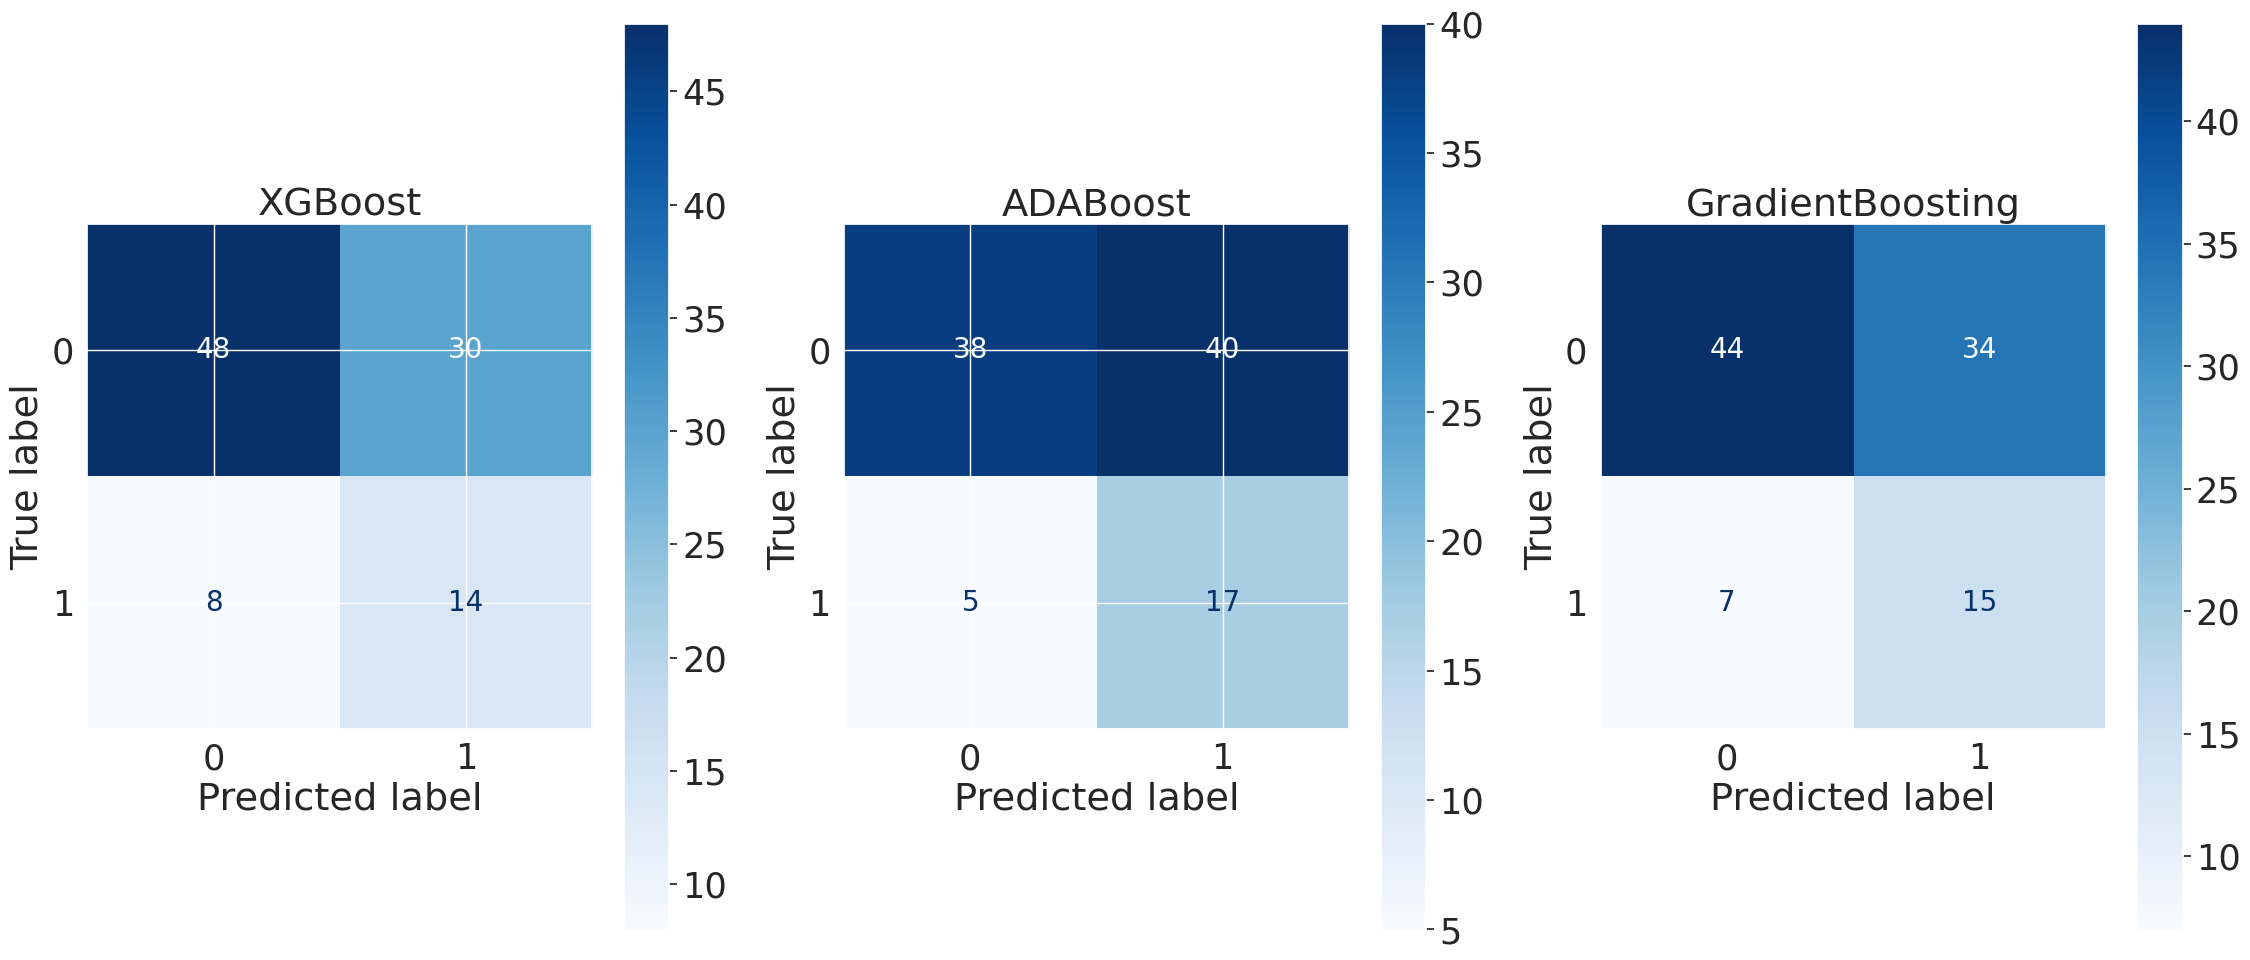

In [ ]:
plot_conf_matrix(nomi_modelli, cm_list, nrows=1, ncols=3, fig_a=23, fig_b=10)

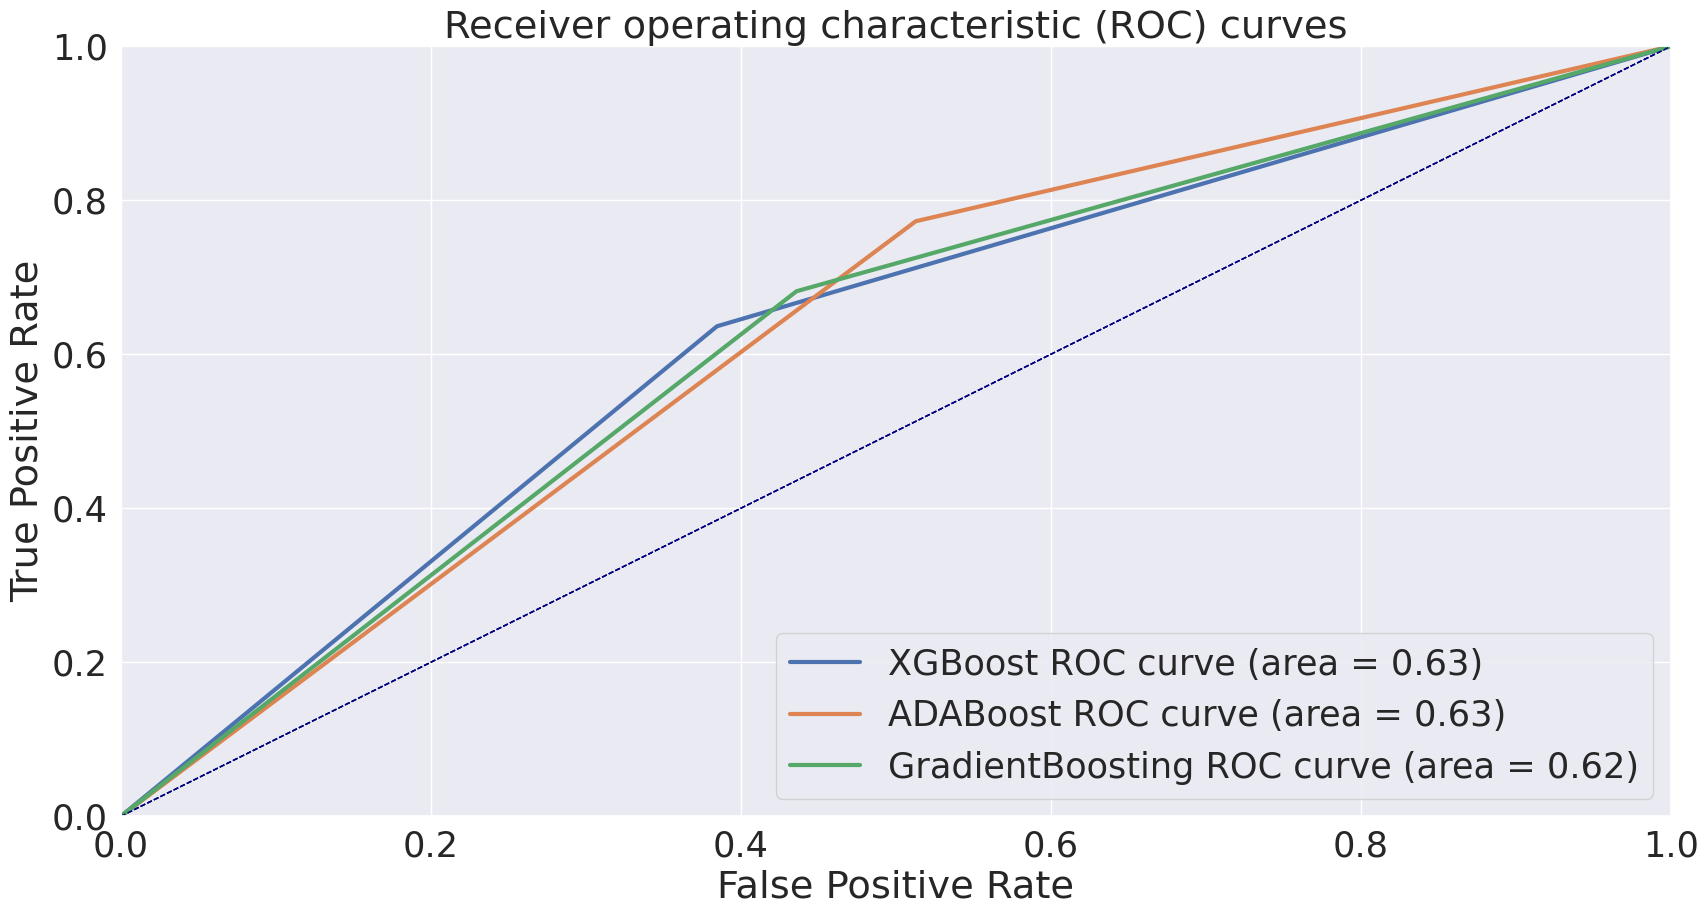

In [ ]:
roc_auc_curve(nomi_modelli, pred_list, y_test)

I 3 modelli appena testati si assestano sul comportamento dei modelli precedentemente considerati, e con essi condividono le caratteristiche rispetto alle varie metriche.

<a id="esercizio3"></a>
## Rete neurale custom

Si richiede di provare a careare una rete neurale con Tensorflow o PyTorch che apprenda a effettuare la clusterizzazione realizata nel punto precedente.

Commentare l'apprendiamento realizzato dalla rete e la qualità dei risultati della sua classificazione. Confrontare quindi i risultati della classificazione realizzata con questa rete custom con quelli ottenuti dai modelli descritti nel punto precedente.

Data la tipologia di dato che si vuole gestire, mi limiterò all'utilizzo di ANN con una serie di layer densi. Altre architetture deep più complesse (CNN, LSTM, ecc...) non sono particolarmente adatte per classificazione binaria su dati tabellari. Decido di lavorare con Tensorflow avendo una maggiore dimestichezza con tale libreria e per la sua, generale, facilità di implementazione. L'idea è quella di partire realizzando una rete molto semplice, con soli 3 layer densi, e di valutarla sia addestrandola sul dataset sbilanciato che su quello bilanciato. Successivamente, trovata la soluzione che meglio prevede i dati, si valuterà se aumentando la complessità della rete ci sono dei benefici in termini di metriche.

### Dataset sbilanciato - 3 layer

In [ ]:
# Definizione del modello
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1]))
model.add(ReLU())
model.add(Dense(units=16))
model.add(ReLU())
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Definizione metriche
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compilazione e fit del modello
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[callback])

Epoch 1/100
26/26 [==============================] - 2s 20ms/step - loss: 0.6624 - accuracy: 0.6247 - precision: 0.3030 - recall: 0.1587 - AUC: 0.4777 - val_loss: 0.5961 - val_accuracy: 0.7111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.5484
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.5856 - accuracy: 0.6938 - precision: 0.7000 - recall: 0.0278 - AUC: 0.6680 - val_loss: 0.5612 - val_accuracy: 0.7444 - val_precision: 1.0000 - val_recall: 0.1154 - val_AUC: 0.7040
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 0.5383 - accuracy: 0.7469 - precision: 0.7640 - recall: 0.2698 - AUC: 0.7724 - val_loss: 0.5303 - val_accuracy: 0.7333 - val_precision: 0.6667 - val_recall: 0.1538 - val_AUC: 0.7425
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.5012 - accuracy: 0.7568 - precision: 0.7723 - recall: 0.3095 - AUC: 0.8085 - val_loss: 0.5090 - val_accuracy: 0.7889 - val_precision: 0.8182 - val_reca

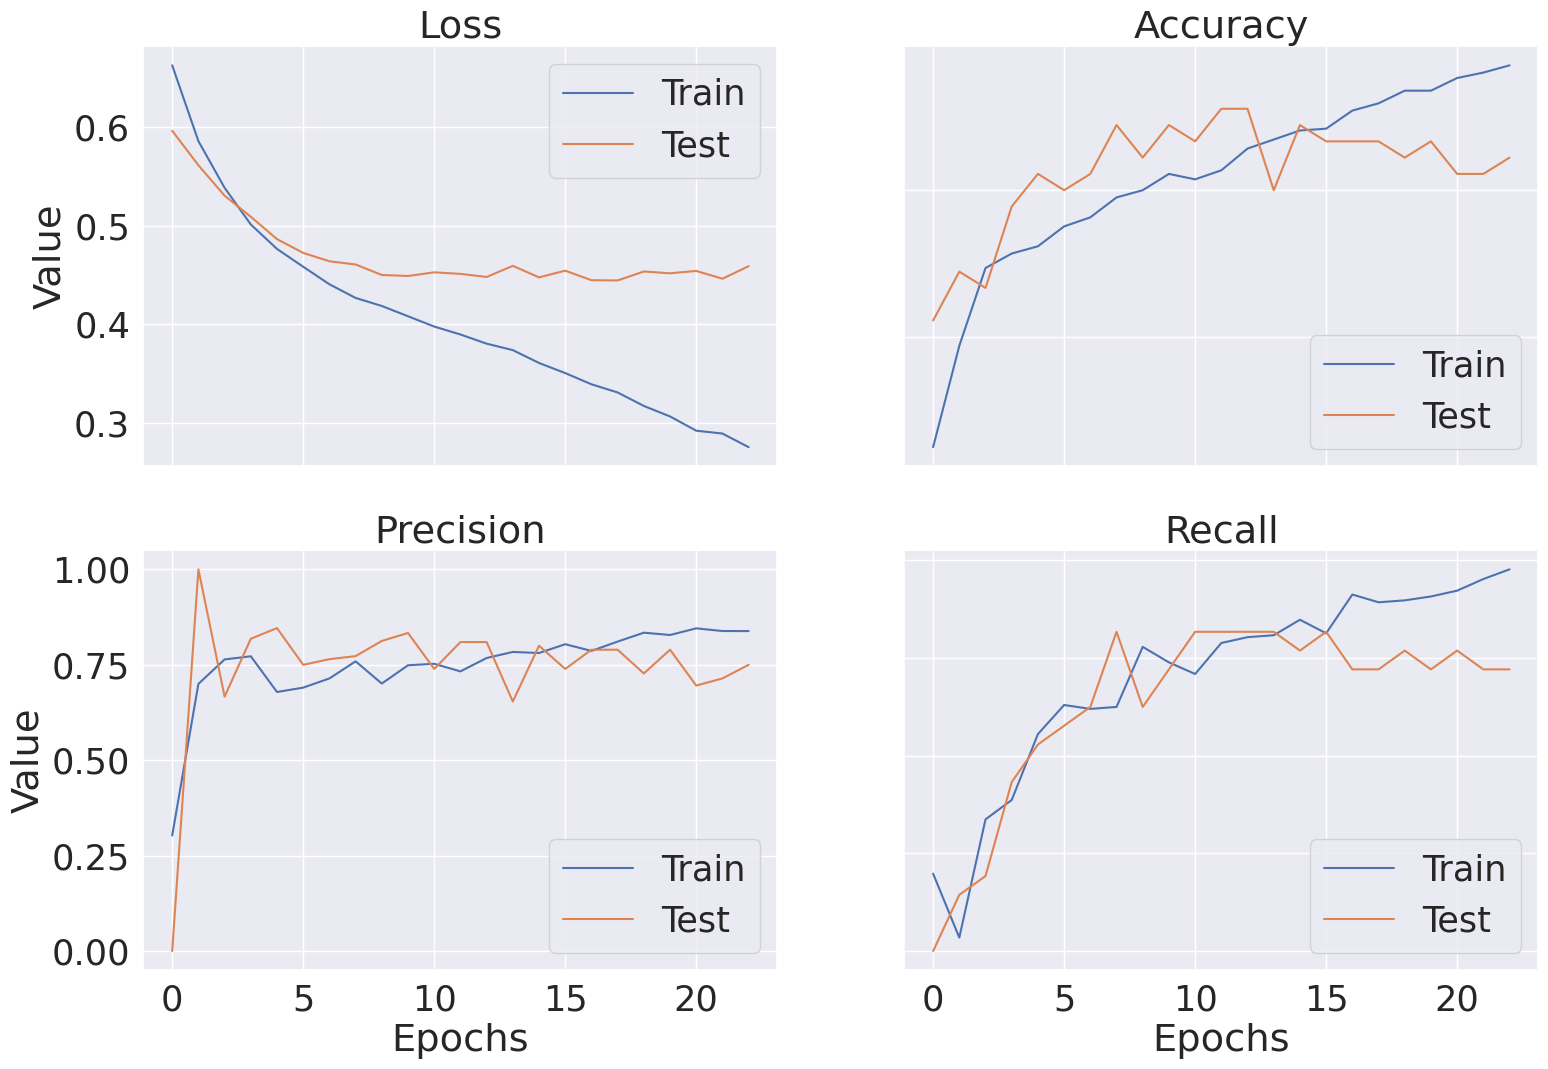

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['Train','Test'])
###############################################
axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['Train','Test'])
###############################################
axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['Train','Test'])
###############################################
axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['Train','Test'])

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

In [ ]:
y_train_hat = model.predict(X_train)
y_train_hat = [int(round(x[0])) for x in y_train_hat]
cm_train = confusion_matrix(y_train, y_train_hat)
y_test_hat = model.predict(X_test)
y_test_hat = [int(round(x[0])) for x in y_test_hat]
cm_test = confusion_matrix(y_test, y_test_hat)

4/4 [==============================] - 0s 3ms/step


In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", round(test_scores[0], 2), "\nTest Accuracy", round(test_scores[1], 2), "\nTest Precision", round(test_scores[2], 2),
      "\nTest Recall", round(test_scores[3], 2), "\nTest AUC", round(test_scores[4], 2))

Test loss: 0.54 
Test Accuracy 0.75 
Test Precision 0.42 
Test Recall 0.36 
Test AUC 0.7


Text(0.5, 109.44444444444444, 'Predicted Label')

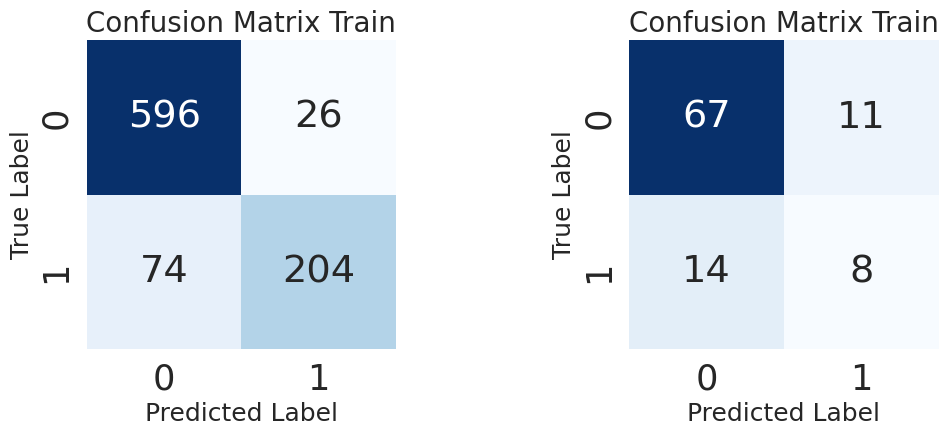

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(pad=3.0)
g1 = sns.heatmap(cm_train, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax1)
ax1.imshow(cm_train, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train", size=20)
ax1.set_ylabel("True Label", size=18)
ax1.set_xlabel("Predicted Label", size=18)
g2 = sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax2)
ax2.imshow(cm_test, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test", size=20)
ax2.set_ylabel("True Label", size=18)
ax2.set_xlabel("Predicted Label", size=18)

Notiamo come la rete tenda ad overfittare il train set molto rapidamente, nonostante la struttura molto semplice. La procedura di early stopping è quindi cruciale per ottenere una configurazione del modello con buone capacità di generalizzazione. Notiamo come il modello faccia abbastanza fatica a classificare correttamente le osservazioni appartenenti alla classe 1, ottenendo valori di recall inferiori ai precedenti modelli ottimizzati. Questo proprio perchè tali modelli erano stati "forzati" verso la massimizzazione della recall. Vediamo che anche sul training set il modello tende a dare parecchi falsi negativi, errore che vorremmo cercare di ridurre il più possibile.

### Dataset bilanciato - 3 layer

In [ ]:
# Definizione del modello
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1]))
model.add(ReLU())
model.add(Dense(units=16))
model.add(ReLU())
model.add(Dense(units=1, activation='sigmoid'))

Quando lavoro col dataset bilanciato voglio, come già sottolineato con i modelli precedenti di Machine Learning, che il bilanciamento venga applicato solamente al training set, con validation e test set lasciati invariati, con la proporzione originale fra le classi. Quindi, in questo caso, c'è la necessità di passare come validation set un gruppo di dati estratto precedentemente al bilanciamento.

In [ ]:
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train, y_train, test_size = 0.1, random_state=RANDOM_STATE*2)

# Dimensioni
print('New X_train: ', X_train_NN.shape)
print('New y_train: ', y_train_NN.shape)
print('New y_train distribution:\n', y_train_NN.value_counts())
print('X_val: ', X_val_NN.shape)
print('y_val: ', y_val_NN.shape)
print('y_val distribution:\n', y_val_NN.value_counts())

New X_train:  (810, 61)
New y_train:  (810,)
New y_train distribution:
 0    558
1    252
Name: label, dtype: int64
X_val:  (90, 61)
y_val:  (90,)
y_val distribution:
 0    64
1    26
Name: label, dtype: int64


In [ ]:
# Bilanciamento applicato solamente al nuovo training set

sm = SMOTE()
X_train_NN_balanced, y_train_NN_balanced = sm.fit_resample(X_train_NN, y_train_NN)

print("Prima/dopo bilanciamento")
unique, counts = np.unique(y_train_NN, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_NN_balanced, return_counts=True)
print(dict(zip(unique, counts)))

Prima/dopo bilanciamento
{0: 558, 1: 252}
{0: 558, 1: 558}


Ricapitolando, la rete neurale sui dati bilanciati sarà addestrata su un training set bilanciato, validata su un validation set sbilanciato e, infine, testata sul medesimo test set del caso precedente. Le dimensioni saranno:

In [ ]:
# Dimensioni
print('X_train: ', X_train_NN_balanced.shape)
print('y_train: ', y_train_NN_balanced.shape)
print('y_train distribution:\n', y_train_NN_balanced.value_counts())
print('X_val: ', X_val_NN.shape)
print('y_val: ', y_val_NN.shape)
print('y_val distribution:\n', y_val_NN.value_counts())
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('y_test distribution:\n', y_test.value_counts())

X_train:  (1116, 61)
y_train:  (1116,)
y_train distribution:
 0    558
1    558
Name: label, dtype: int64
X_val:  (90, 61)
y_val:  (90,)
y_val distribution:
 0    64
1    26
Name: label, dtype: int64
X_test:  (100, 61)
y_test:  (100,)
y_test distribution:
 0    78
1    22
Name: label, dtype: int64


In [ ]:
# Definizione metriche
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compilazione e fit del modello
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
history = model.fit(X_train_NN_balanced, y_train_NN_balanced, epochs=100, validation_data=(X_val_NN, y_val_NN), callbacks=[callback])

Epoch 1/100
35/35 [==============================] - 4s 28ms/step - loss: 0.6742 - accuracy: 0.5878 - precision: 0.5778 - recall: 0.6523 - AUC: 0.6252 - val_loss: 0.6745 - val_accuracy: 0.5889 - val_precision: 0.3721 - val_recall: 0.6154 - val_AUC: 0.6722
Epoch 2/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6068 - accuracy: 0.7303 - precision: 0.7083 - recall: 0.7832 - AUC: 0.8036 - val_loss: 0.6226 - val_accuracy: 0.6889 - val_precision: 0.4722 - val_recall: 0.6538 - val_AUC: 0.7166
Epoch 3/100
35/35 [==============================] - 0s 9ms/step - loss: 0.5408 - accuracy: 0.7679 - precision: 0.7674 - recall: 0.7688 - AUC: 0.8494 - val_loss: 0.5765 - val_accuracy: 0.7333 - val_precision: 0.5312 - val_recall: 0.6538 - val_AUC: 0.7350
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.4748 - accuracy: 0.8038 - precision: 0.8054 - recall: 0.8011 - AUC: 0.8733 - val_loss: 0.5460 - val_accuracy: 0.7333 - val_precision: 0.5333 - val_recall: 0.61

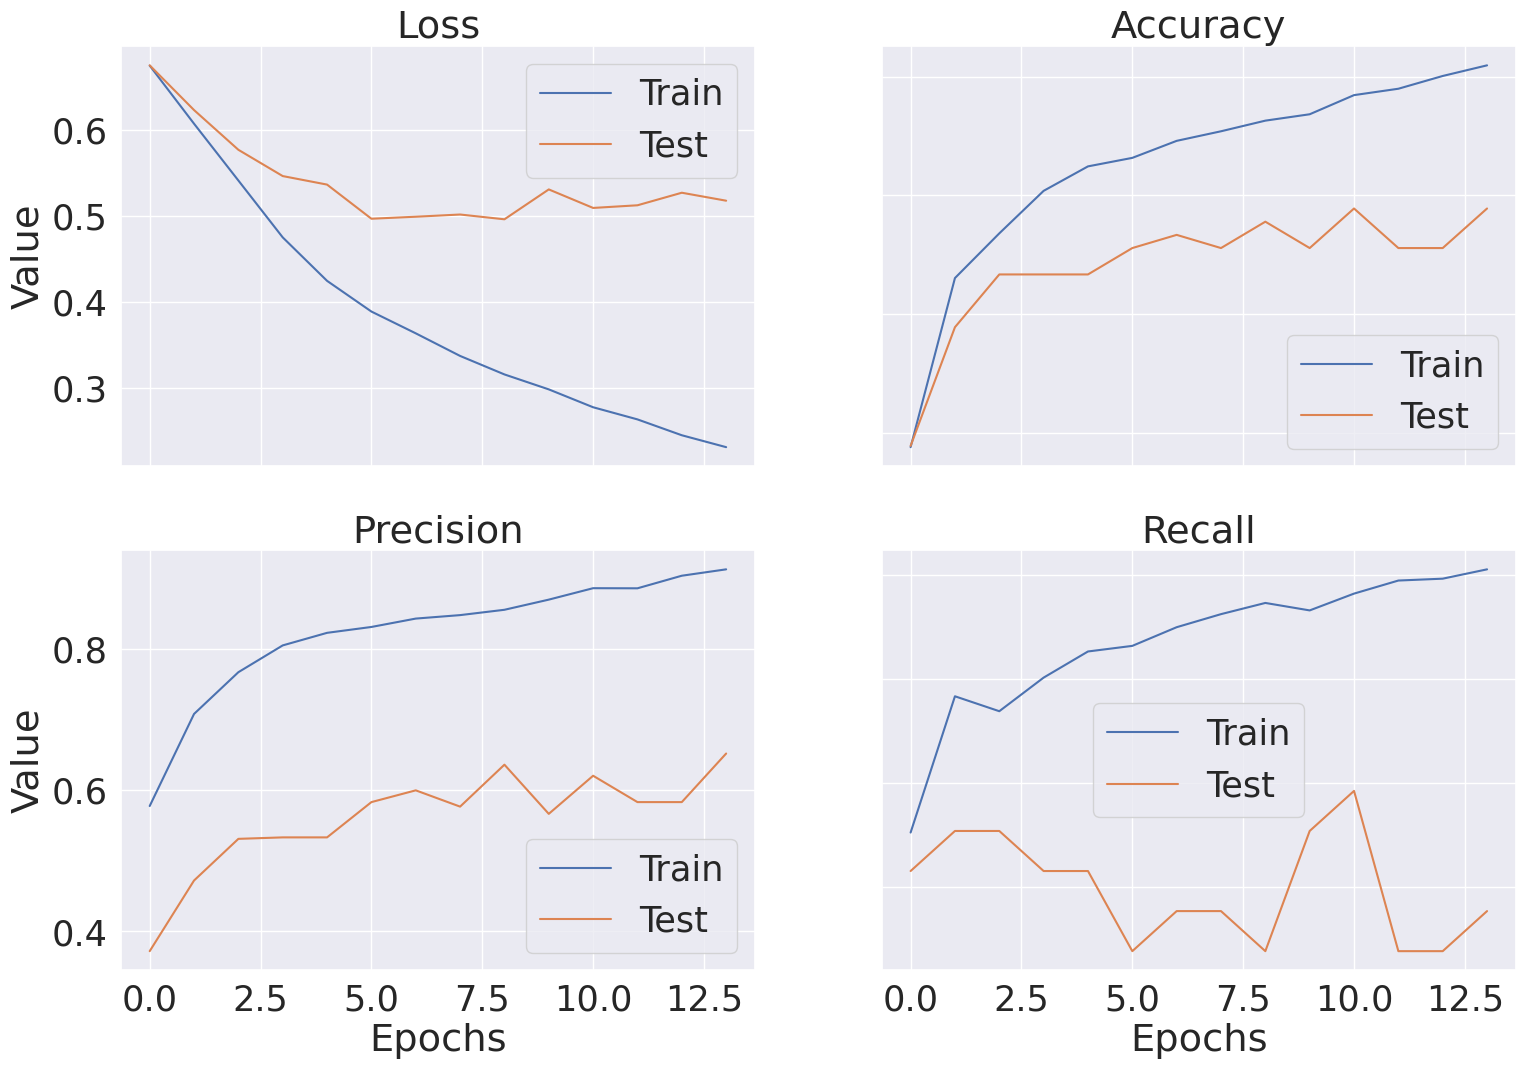

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['Train','Test'])
###############################################
axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['Train','Test'])
###############################################
axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['Train','Test'])
###############################################
axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['Train','Test'])

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

In [ ]:
y_train_hat = model.predict(X_train_NN_balanced)
y_train_hat = [int(round(x[0])) for x in y_train_hat]
cm_train = confusion_matrix(y_train_NN_balanced, y_train_hat)
y_test_hat = model.predict(X_test)
y_test_hat = [int(round(x[0])) for x in y_test_hat]
cm_test = confusion_matrix(y_test, y_test_hat)

4/4 [==============================] - 0s 3ms/step


In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", round(test_scores[0], 2), "\nTest Accuracy", round(test_scores[1], 2), "\nTest Precision", round(test_scores[2], 2),
      "\nTest Recall", round(test_scores[3], 2), "\nTest AUC", round(test_scores[4], 2))

Test loss: 0.61 
Test Accuracy 0.71 
Test Precision 0.35 
Test Recall 0.36 
Test AUC 0.67


Text(0.5, 109.44444444444444, 'Predicted Label')

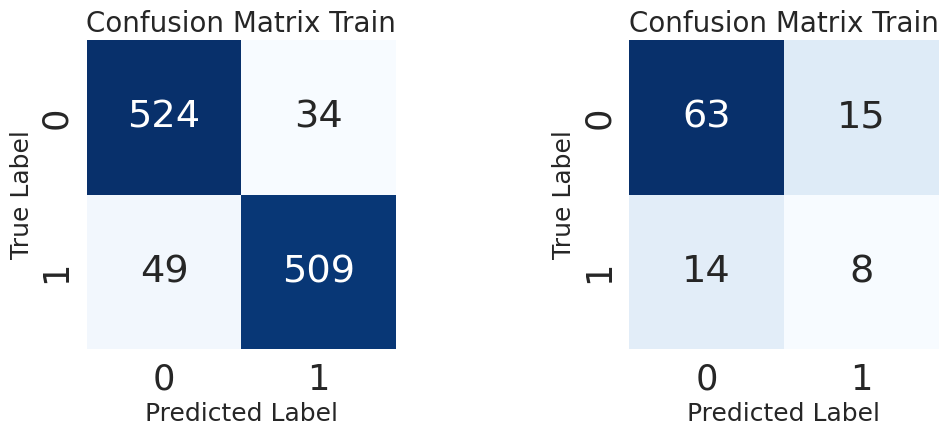

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(pad=3.0)
g1 = sns.heatmap(cm_train, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax1)
ax1.imshow(cm_train, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train", size=20)
ax1.set_ylabel("True Label", size=18)
ax1.set_xlabel("Predicted Label", size=18)
g2 = sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax2)
ax2.imshow(cm_test, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test", size=20)
ax2.set_ylabel("True Label", size=18)
ax2.set_xlabel("Predicted Label", size=18)

Il comportamento non varia di molto rispetto al dataset sbilanciato. Ci sono miglioramenti rispetto al training set, grazie al maggior numero di dati appartenenti alla classe maggioritaria da cui la rete può apprendere. Sul test set, tuttavia, i risultati sono pressochè analoghi. Non essendoci grosse differenze, quindi, in questo caso si decide di procedere col dataset sbilanciato.

### Dataset bilanciato - 6 layer

In [ ]:
# Definizione del modello
model = Sequential()

model.add(Dense(256, input_dim=X_train.shape[1]))
model.add(ReLU())
model.add(Dense(units=128))
model.add(ReLU())
model.add(Dense(units=64))
model.add(ReLU())
model.add(Dense(units=32))
model.add(ReLU())
model.add(Dense(units=16))
model.add(ReLU())
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Definizione metriche
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compilazione e fit del modello
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[callback])

Epoch 1/100
26/26 [==============================] - 3s 23ms/step - loss: 0.6034 - accuracy: 0.6889 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6218 - val_loss: 0.5532 - val_accuracy: 0.7111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.7737
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5233 - accuracy: 0.7185 - precision: 0.7727 - recall: 0.1349 - AUC: 0.7874 - val_loss: 0.5077 - val_accuracy: 0.7667 - val_precision: 0.5926 - val_recall: 0.6154 - val_AUC: 0.7846
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 0.4609 - accuracy: 0.7815 - precision: 0.6623 - recall: 0.6071 - AUC: 0.8367 - val_loss: 0.4879 - val_accuracy: 0.8000 - val_precision: 0.7857 - val_recall: 0.4231 - val_AUC: 0.8098
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 0.4320 - accuracy: 0.7975 - precision: 0.7095 - recall: 0.5913 - AUC: 0.8573 - val_loss: 0.4652 - val_accuracy: 0.8111 - val_precision: 0.7647 - 

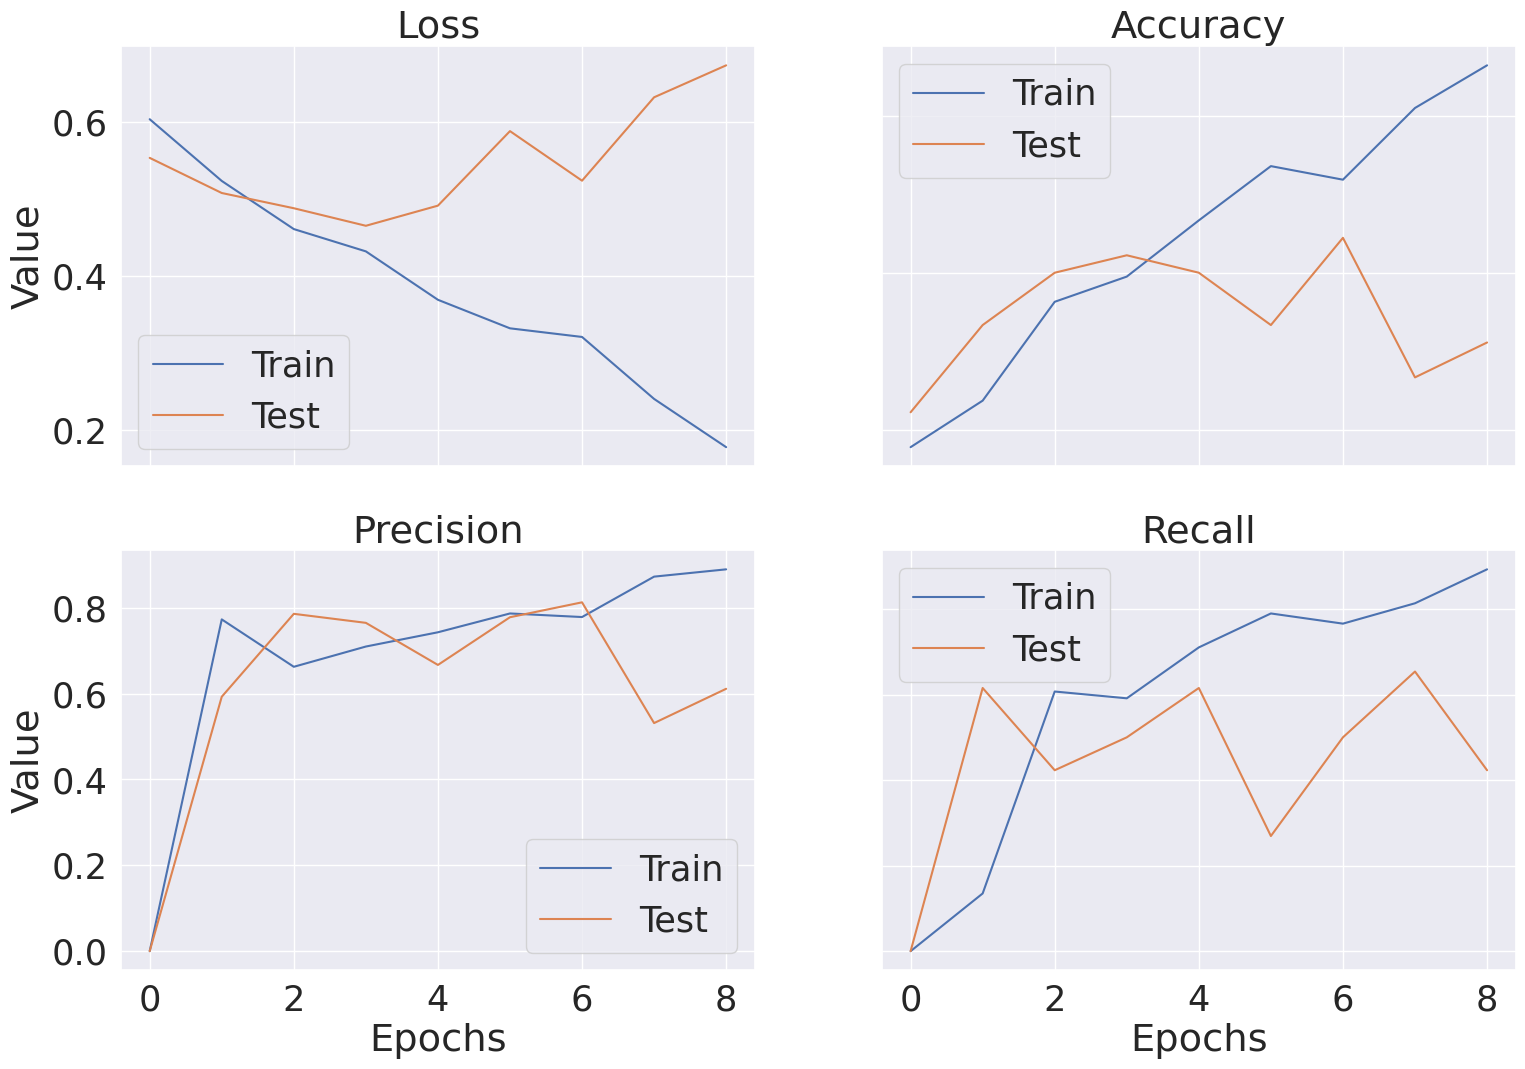

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['Train','Test'])
###############################################
axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['Train','Test'])
###############################################
axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['Train','Test'])
###############################################
axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['Train','Test'])

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

In [ ]:
y_train_hat = model.predict(X_train)
y_train_hat = [int(round(x[0])) for x in y_train_hat]
cm_train = confusion_matrix(y_train, y_train_hat)
y_test_hat = model.predict(X_test)
y_test_hat = [int(round(x[0])) for x in y_test_hat]
cm_test = confusion_matrix(y_test, y_test_hat)

4/4 [==============================] - 0s 7ms/step


In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", round(test_scores[0], 2), "\nTest Accuracy", round(test_scores[1], 2), "\nTest Precision", round(test_scores[2], 2),
      "\nTest Recall", round(test_scores[3], 2), "\nTest AUC", round(test_scores[4], 2))

Test loss: 0.71 
Test Accuracy 0.81 
Test Precision 0.6 
Test Recall 0.41 
Test AUC 0.71


Text(0.5, 109.44444444444444, 'Predicted Label')

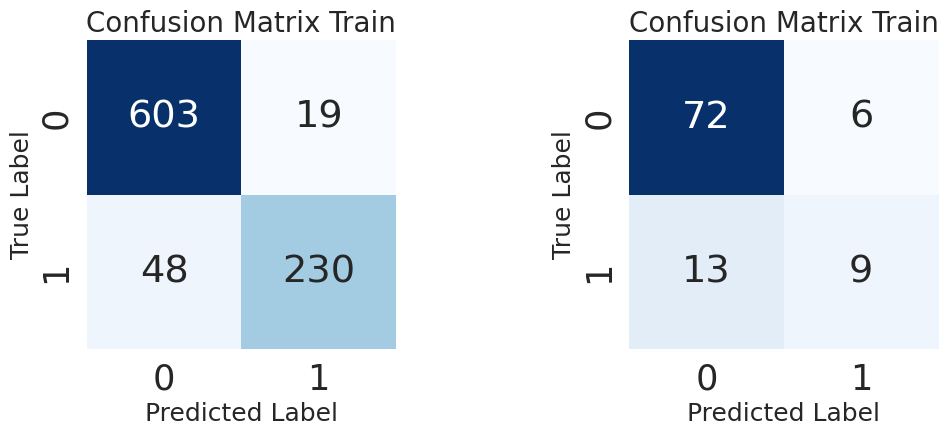

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(pad=3.0)
g1 = sns.heatmap(cm_train, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax1)
ax1.imshow(cm_train, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train", size=20)
ax1.set_ylabel("True Label", size=18)
ax1.set_xlabel("Predicted Label", size=18)
g2 = sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax2)
ax2.imshow(cm_test, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test", size=20)
ax2.set_ylabel("True Label", size=18)
ax2.set_xlabel("Predicted Label", size=18)

Nemmeno l'aumento della complessità della rete modifica significativamente la capacità predittiva del modello. Le performance sono migliori rispetto al training set, e migliorano leggermente sul test set, dove abbiamo comunque una recall poco soddisfacente. Nel caso in questione, quindi, per tutte le considerazioni fatte in precedenza, la soluzione migliore sembra essere quella di utilizzare metodi più semplici, ottimizzati, ma in grado di avere una buona recall. Le reti neurali sono comunque una valida alternativa, soprattutto qualora si potessero avere a disposizione molti più dati. Infatti, tali modelli beneficiano fortemente dall'avere tanti dati a disposizione da cui poter apprendere le caratteristiche del dataset. In questo caso, però, avendo a disposizione una quantità limitata di dati, la complessità della rete neurale sembra essere più uno svantaggio che altro.